Author: Rohan Krishna Balaji  <br>
Course : Simulation Science <br>
Date  : 25.06.2021  <br>
Project : ICTM Analysis, Master's Thesis at Fraunhofer IPT <br>
Email :  rohan.balaji@rwth-aachen.de <br>
Verion : 1.01 <br>

# Introduction
To obtain the complete data set which includes feature from both planning data used in CAM planning and machining data obtained from Parquet fles First is to convert the machining data in machine coordinate system to tool tip data in work space coordinate system through 'Forward Kinematic Transformations' on compensated data. Then each tool tip data is clusterd to the correspoding acqired data points. Then the obtained clasters are averged to generate combined dataset with both planning and machining data.
The dataset is filtered to remove the outliers

In [1]:
# Importing necessary libraries and general settings
import transformation
import compensation
import data_imports
import pandas as pd
import os
import glob
import math
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import numpy as np
from scipy.signal import find_peaks

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

Path locations (folder location) for respective files

In [2]:
dir_paraquet = 'Manufacturing_Data/'
dir_planning = 'Planing_Data/'
dir_final_save  = 'Final_df/' 
dir_paraquet = 'D:/rohan/thesis/Projects/Machine_Learning/Data/Manufacturing_Data/'
dir_planning = 'D:/rohan/thesis/Projects/Machine_Learning/Data/Planning_Data/'
dir_compensation = 'D:/rohan/thesis/Projects/Machine_Learning/Data/Compensation_Data/'

In [3]:
print('Enter the Block number, example 1030')
block = input()
block = int(block)

Enter the Block number, example 1030
1030


In [4]:
## print('Enter the blade angle, muliples of 12')
angle = input()
angle = int(angle)

12


In [5]:
# Importing all the data
df_m,df_p,compensation_values_df = data_imports.data_out(block,angle,dir_paraquet,dir_planning,dir_compensation)

In [6]:
df_p.columns

Index(['Leading angle', 'Side tilt angle', 'Surface Contact point X',
       'Surface contact point Y', 'Surface contact point z',
       'Surface Orietation X', 'Surface Orietation Y', 'Surface Orietation Z',
       'Tool Tip Point X', 'Tool Tip Point Y', 'Tool Tip Point Z',
       'Tool Orientation X', 'Tool Orientation Y', 'Tool Orientation Z',
       'Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)'],
      dtype='object')

In [7]:
df_m.columns

Index(['time', 'MachineX', 'MachineY', 'MachineZ', 'MachineA', 'MachineC',
       'LoadSpindle', 'TransfX', 'TransfY', 'TransfZ', 'TransfI', 'TransfJ',
       'TransfK', 'executionDuration', 'previousExecutionDuration',
       'relativeTimetoPreviousCall program number', 'timeStamp', 'Tool Length',
       'Tool Radius', 'G54-X', 'G54-Y', 'G54-Z', 'G54-A', 'G54-C',
       'ProgNumber', 'Blade', 'Step', 'Level', 'Fx_mean', 'Fy_mean', 'Fz_mean',
       'Mz_mean', 'Fc_mean', 'Fa_mean', 'FcN_mean', 'Fres_mean', 'Fx_sigma',
       'Fy_sigma', 'Fz_sigma', 'Mz_sigma', 'Fc_sigma', 'Fa_sigma', 'FcN_sigma',
       'Fres_sigma', 'Fx_max', 'Fy_max', 'Fz_max', 'Mz_max', 'Fc_max',
       'Fa_max', 'FcN_max', 'Fres_max'],
      dtype='object')

In [8]:
# Just copying machine data points linear(x,y,x) and rotart (a,c) into arrays.
# These machine points (x,y,x,a,c) are transformed from machine coordinate system to workpiece coordinate system by forward tramsformation

x = df_m['MachineX'].copy(deep=True)
y = df_m['MachineY'].copy(deep=True)
z = df_m['MachineZ'].copy(deep=True)
a = np.radians(df_m['MachineA']).copy(deep=True)
c = np.radians(df_m['MachineC']).copy(deep=True)

size1 = x.shape[0]

# converting pandas series to numpy array
x = x.to_numpy()
y = y.to_numpy()
z = z.to_numpy()
a = a.to_numpy()
c = c.to_numpy()

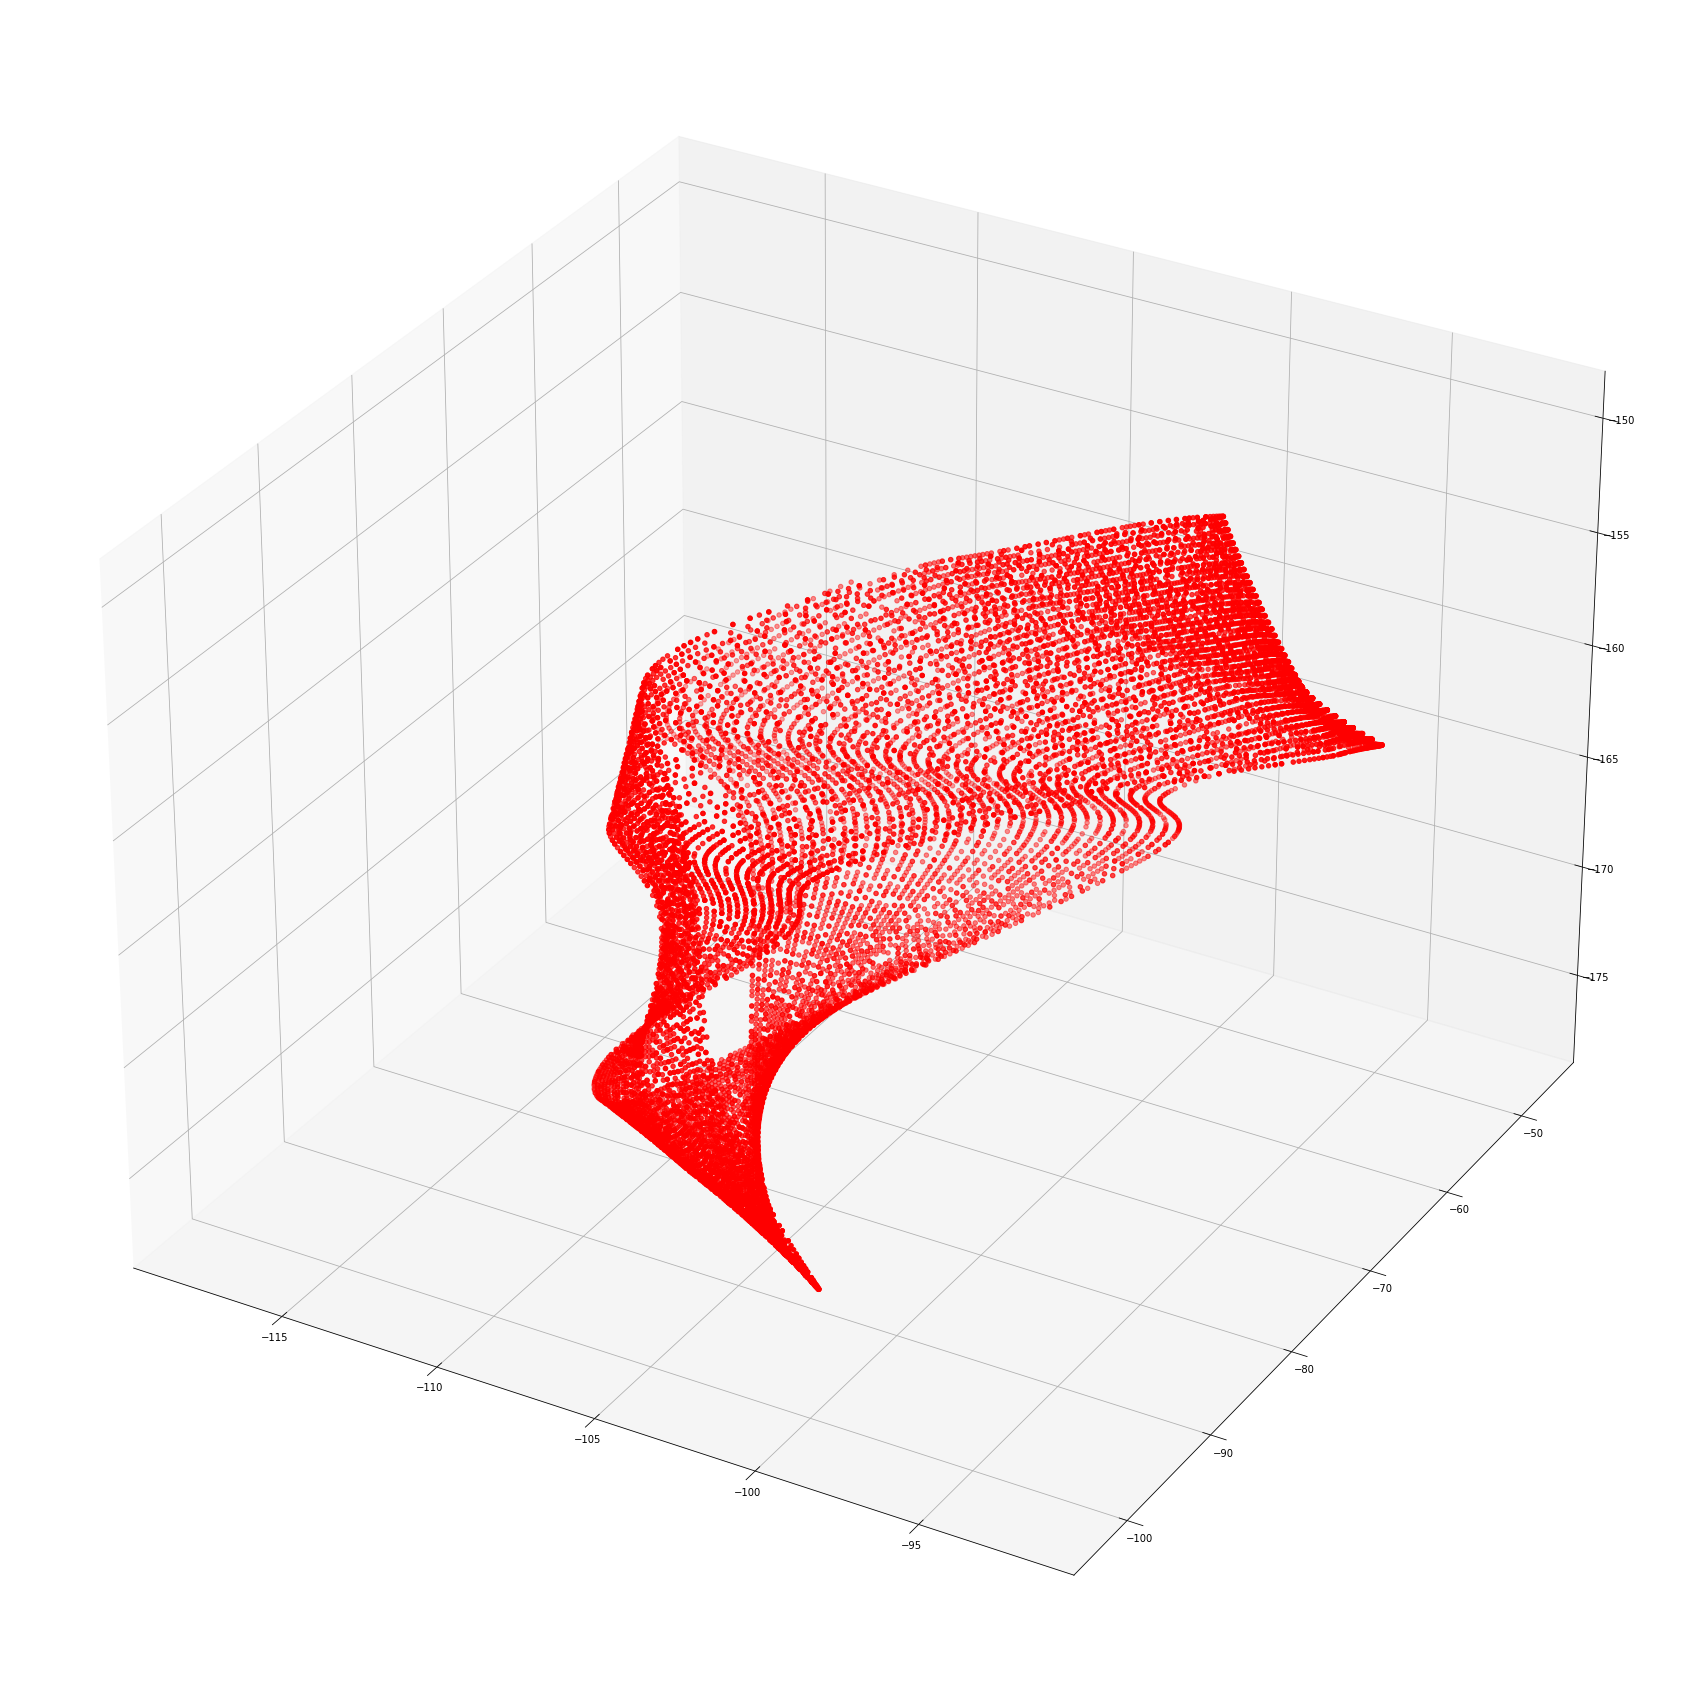

In [9]:
plt.figure(figsize=(30,45))
ax = plt.axes(projection='3d')
ax.scatter3D(x[10000:-10000], y[10000:-10000], z[10000:-10000], color = 'red',label = 'raw machine Data')
#ax.scatter3D(x, y, z, color = 'red',label = 'raw machine Data')

In [10]:
#compensation_values
compensation_values = compensation_values_df.to_numpy()

### Applying compensation on the Aquired Data
Based on the macine position compensation is applied to the machine datat, so that the errors are negated. This is implemented in the script compensation.py 
<img src="images/compensation.png">

In [11]:
# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3 = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1, deltaY1, deltaZ1,deltaI1,deltaJ1,deltaK1 = obj3.calculate(x,y,z)  
size3 = x.shape[0]

conc3 = np.concatenate((deltaX1.reshape(size3,1),deltaY1.reshape(size3,1),deltaZ1.reshape(size3,1),deltaI1.reshape(size3,1),deltaJ1.reshape(size3,1),deltaK1.reshape(size3,1)),axis=1)

# prininting the compensation error values
df_obj3 = pd.DataFrame(conc3, columns=['deltaX1','deltaY1','deltaZ1','deltaI1','deltaJ1','deltaK1'])
df_obj3.head(5)  
                          

deltaX1    deltaY1    deltaZ1  deltaI1  deltaJ1  deltaK1
0  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
1  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
2  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
3  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
4  26.443495 -11.914891 -10.001572      0.0      0.0      0.0

In [12]:
x_compensated = x + deltaX1*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated = y + deltaY1*10**-3
z_compensated = z + deltaZ1*10**-3

conc4 = np.concatenate((x_compensated.reshape(size3,1),y_compensated.reshape(size3,1),z_compensated.reshape(size3,1)),axis=1)
df_obj4 = pd.DataFrame(conc4, columns=['x_compensated','y_compensated','z_compensated'])
df_obj4.head(5)

x_compensated  y_compensated  z_compensated
0    -158.991757    -118.613215     -79.440502
1    -158.991757    -118.613215     -79.440502
2    -158.991757    -118.613215     -79.440502
3    -158.991757    -118.613215     -79.440502
4    -158.991757    -118.613215     -79.440502

In [13]:
df_m['compensation_x'] = deltaX1*10**-3
df_m['compensation_y'] = deltaY1*10**-3
df_m['compensation_z'] = deltaZ1*10**-3
df_m.iloc[10000:10010]

time  MachineX  MachineY  MachineZ  MachineA  MachineC  \
84.565002  84.565002 -111.1852  -53.8478 -161.7364  -72.8958  346.6374   
84.580002  84.580002 -111.5523  -53.7699 -162.1007  -72.9520  346.6663   
84.590004  84.590004 -111.9219  -53.7103 -162.4721  -73.0135  346.6941   
84.605003  84.605003 -112.0958  -53.6898 -162.6482  -73.0442  346.7065   
84.612503  84.612503 -112.0958  -53.6898 -162.6482  -73.0442  346.7065   
84.620003  84.620003 -112.4853  -53.6588 -163.0437  -73.1154  346.7313   
84.625000  84.625000 -112.6763  -53.6507 -163.2392  -73.1521  346.7427   
84.635002  84.635002 -112.6763  -53.6507 -163.2392  -73.1521  346.7427   
84.645004  84.645004 -113.0407  -53.6468 -163.6146  -73.2247  346.7634   
84.650002  84.650002 -113.0407  -53.6468 -163.6146  -73.2247  346.7634   

           LoadSpindle    TransfX     TransfY    TransfZ   TransfI   TransfJ  \
84.565002    10.168182 -64.995640  207.459380  24.068148  0.521028 -0.290476   
84.580002    10.168182 -65.506815  207.303095  23.703558  0.568362 -0.295670   
84.590004    10.168182 -66.016813  207.146038  23.337682  0.617726 -0.299835   
84.605003    10.168182 -66.254315  207.072564  23.166825  0.641298 -0.301510   
84.612503    10.168182 -66.254315  207.072564  23.166825  0.641298 -0.301510   
84.620003    10.168182 -66.775667  206.910115  22.790698  0.692874 -0.305014   
84.625000    10.168182 -67.028593  206.830918  22.607078  0.717887 -0.306304   
84.635002    10.145455 -67.028593  206.830918  22.607078  0.717887 -0.306304   
84.645004    10.145455 -67.507512  206.679789  22.259282  0.764234 -0.307541   
84.650002    10.145455 -67.507512  206.679789  22.259282  0.764234 -0.307541   

            TransfK  executionDuration  previousExecutionDuration  \
84.565002 -0.802592           0.002875                   0.006707   
84.580002 -0.767817           0.013677                   0.002875   
84.590004 -0.726989           0.009031                   0.013677   
84.605003 -0.705570           0.010228                   0.009031   
84.612503 -0.705570           0.001957                   0.010228   
84.620003 -0.653370           0.010968                   0.001957   
84.625000 -0.625153           0.002824                   0.010968   
84.635002 -0.625153           0.003247                   0.002824   
84.645004 -0.566891           0.007047                   0.003247   
84.650002 -0.566891           0.001922                   0.007047   

           relativeTimetoPreviousCall program number     timeStamp  \
84.565002                                   0.006987  6.375063e+10   
84.580002                                   0.007046  6.375063e+10   
84.590004                                   0.013801  6.375063e+10   
84.605003                                   0.010646  6.375063e+10   
84.612503                                   0.010315  6.375063e+10   
84.620003                                   0.007014  6.375063e+10   
84.625000                                   0.011056  6.375063e+10   
84.635002                                   0.010690  6.375063e+10   
84.645004                                   0.008155  6.375063e+10   
84.650002                                   0.007109  6.375063e+10   

           Tool Length  Tool Radius  G54-X  G54-Y    G54-Z  G54-A  G54-C  \
84.565002     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.580002     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.590004     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.605003     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.612503     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.620003     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.625000     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.635002     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.645004     226.4591          6.0    0.0    0.0 -510.483   12.0    0.0   
84.650002     226.4591       

### Forward Transformation:
Forward transformation is performed by applying rotational and transitional
transformations on the machine points and orientation in the machine coordi-
nate system.
There are two ways to interpret the transformations. Firstly, by pre-multiplication
of all the transformation matrices with respect to base coordinate system (i.e
Machine Coordinate System). Second method is the apply post- multiplica-
tion this can be understood as applying 'Relative Transformation'.
The notation used for machine data points obtained by paraqet fles are
x,y,z,a,c in machine coordinate system. The tool tip and orientations obtained
in workpiece coordinate system X,Y,Z,I,J,K. This is implemented in transformation.py script.

<img src="images/transformation.png">

In [15]:
obj = transformation.Transformation(size1,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS, tool_orientation_workpiece_CS = obj.forward(x_compensated,y_compensated,z_compensated,a,c)

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]
print(X.shape)

I = tool_orientation_workpiece_CS[0,0,:]
J = tool_orientation_workpiece_CS[1,0,:]
K = tool_orientation_workpiece_CS[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values or equivalent values i.e (cos(a or c),sin(a or c))
machine_points_xyz, machine_direction_ac = obj.backward(X,Y,Z,I,J,K)

x_out = machine_points_xyz[0,0,:]
y_out = machine_points_xyz[1,0,:]
z_out = machine_points_xyz[2,0,:]

a_out = machine_direction_ac[0,0,:]
c_out = machine_direction_ac[1,0,:]

conc1 = np.concatenate((x.reshape(size1,1),x_out.reshape(size1,1),y.reshape(size1,1),y_out.reshape(size1,1),z.reshape(size1,1),z_out.reshape(size1,1),a.reshape(size1,1),a_out.reshape(size1,1),c.reshape(size1,1),c_out.reshape(size1,1)),axis=1)

df_obj1 = pd.DataFrame(conc1, columns=['x','x_out','y','y_out','z','z_out','a','a_out','c','c_out'])

df_obj1.iloc[10000:10005]


(38610,)


x       x_out        y      y_out         z       z_out  \
10000 -111.1852 -147.576226 -53.8478 -61.858472 -161.7364 -187.737170   
10001 -111.5523 -147.890856 -53.7699 -61.776079 -162.1007 -188.177801   
10002 -111.9219 -148.207473 -53.7103 -61.709562 -162.4721 -188.626738   
10003 -112.0958 -148.356399 -53.6898 -61.684945 -162.6482 -188.839567   
10004 -112.0958 -148.356399 -53.6898 -61.684945 -162.6482 -188.839567   

              a     a_out         c     c_out  
10000 -1.272272 -1.272272  6.049964 -0.442661  
10001 -1.273253 -1.273253  6.050468 -0.442156  
10002 -1.274326 -1.274326  6.050954 -0.441671  
10003 -1.274862 -1.274862  6.051170 -0.441455  
10004 -1.274862 -1.274862  6.051170 -0.441455

In [16]:
conc11 = np.concatenate((x.reshape(size1,1),y.reshape(size1,1),z.reshape(size1,1),a.reshape(size1,1),c.reshape(size1,1),X.reshape(size1,1),Y.reshape(size1,1),Z.reshape(size1,1),I.reshape(size1,1),J.reshape(size1,1),K.reshape(size1,1)),axis=1)
dfout11 = pd.DataFrame(conc11, columns=['x','y','z','a','c','X','Y','Z','I','J','K'])
dfout11.head(10)


x         y        z         a         c          X           Y  \
0 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
1 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
2 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
3 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
4 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
5 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
6 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
7 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
8 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   
9 -159.0182 -118.6013 -79.4305 -1.313123  5.724465  62.413472  293.422047   

           Z         I         J         K  
0  99.941964  0.671874  0.695447  0.254831  
1  99.941964  0.671874  0.695447  0.254831  
2  99.941964  0.671874  0.695447  0.254831  
3  99.941964  0.671874  0.695447  0.254831  
4  99.941964  0.671874  0.695447  0.254831  
5  99.941964  0.671874  0.695447  0.254831  
6  99.941964  0.671874  0.695447  0.254831  
7  99.941964  0.671874  0.695447  0.254831  
8  99.941964  0.671874  0.695447  0.254831  
9  99.941964  0.671874  0.695447  0.254831

In [17]:
# example
n = 15000
distance1 = (((df_p['Tool Tip Point X']-X[n])**2+(df_p['Tool Tip Point Y']-Y[n])**2+(df_p['Tool Tip Point Z']-Z[n])**2)**(1/2))
distance1.min()

0.20622933987087583

In [18]:
tool_tip_X = df_p['Tool Tip Point X'].to_numpy()
tool_tip_Y = df_p['Tool Tip Point Y'].to_numpy()
tool_tip_Z = df_p['Tool Tip Point Z'].to_numpy()
X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

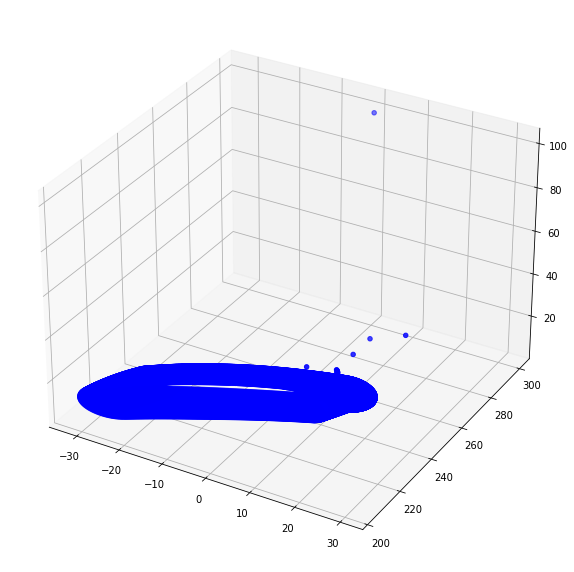

In [19]:
plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.scatter3D(X_inv, Y_inv, Z_inv, color = 'blue',label = 'raw Planning Data')

In [20]:
# Plotting the result obtained during the study
def subplotter(low,high,X,Y,Z,X_inv,Y_inv,Z_inv):
    
    range = np.arange(low,high)
    fig,axs = plt.subplots(3,figsize=(10,15))

    axs[0].plot(range,X[range],label = 'X acquired', color='blue')
    axs[0].plot(range,X_inv[range],label = 'X planning', color='red')
    axs[0].legend() 
    axs[0].set_xlabel('row index (dimension less)')
    axs[0].set_ylabel('X in mm')
    #axs[0].set_title('X data comparison')   
    
    axs[1].plot(range,Y[range], label = 'Y acquired', color='blue')
    axs[1].plot(range,Y_inv[range], label = 'Y planning', color='red') 
    axs[1].legend()
    axs[1].set_xlabel('row index (dimension less)')
    axs[1].set_ylabel('Y in mm')
   # axs[1].set_title('Y data comparison')   
    

    axs[2].plot(range,Z[range], label = 'Z acquired', color='blue')
    axs[2].plot(range,Z_inv[range] , label = 'Z planning', color='red')
    axs[2].legend()
    axs[2].set_xlabel('row index (dimension less)')
    axs[2].set_ylabel('Z in mm')
    #axs[2].set_title('Z data comparison')   
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()


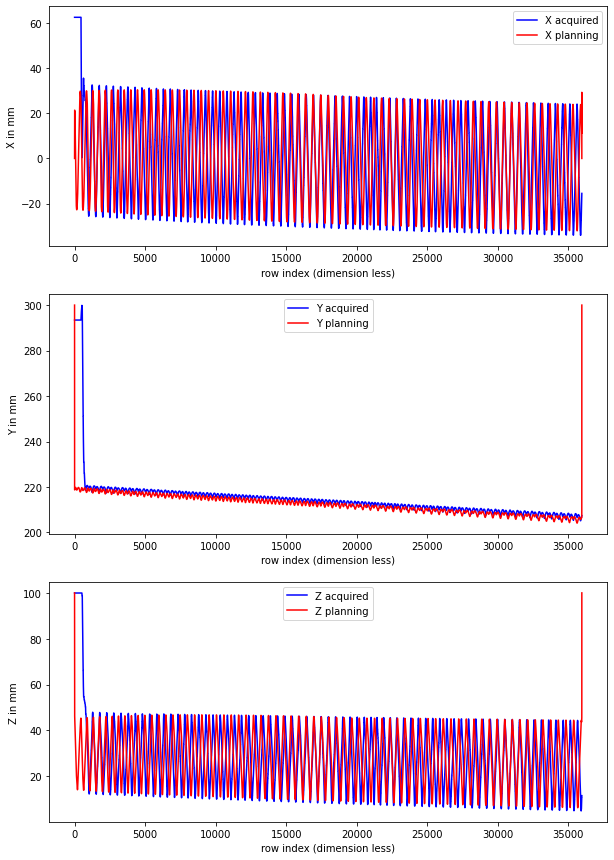

In [21]:
subplotter(0,df_p.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)

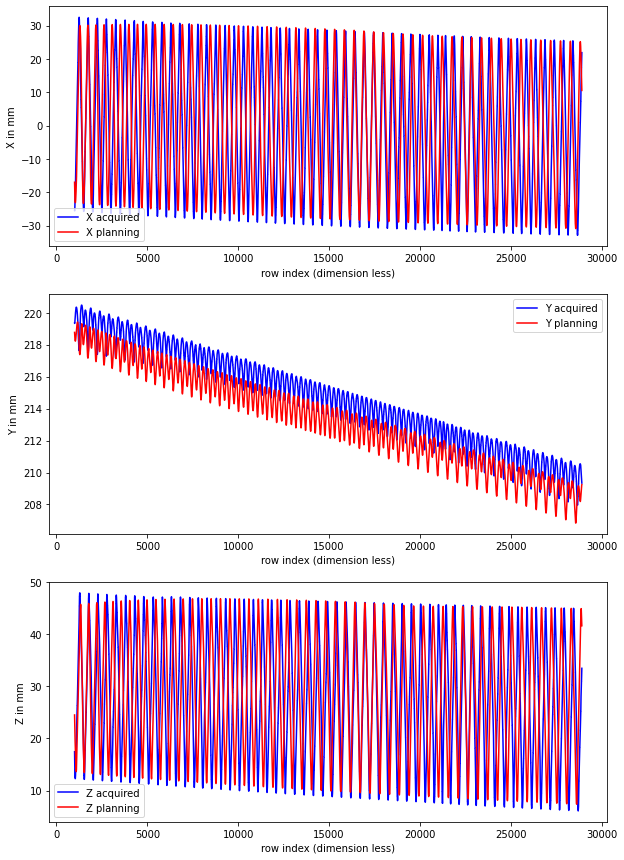

In [22]:
subplotter(1000,28900,X,Y,Z,X_inv,Y_inv,Z_inv)

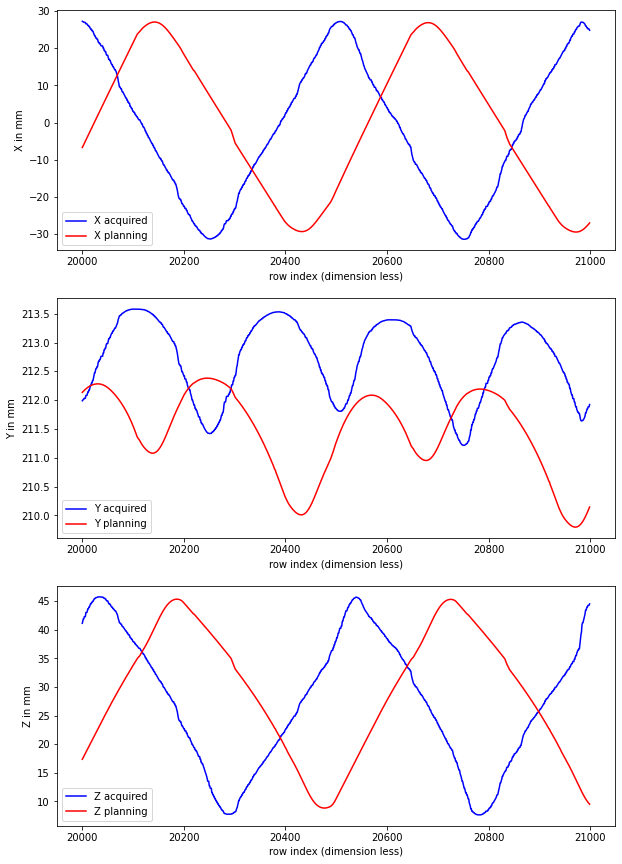

In [23]:
subplotter(20000,21000,X,Y,Z,X_inv,Y_inv,Z_inv)

In [24]:
"""
range1 = np.arange(1000,34900)
X = X[range1]
Y = Y[range1]
Z = Z[range1]

tool_tip_X = tool_tip_X[range1]
tool_tip_Y = tool_tip_Y[range1]
tool_tip_Z = tool_tip_Z[range1]
 
X_inv = tool_tip_X
Y_inv = tool_tip_Y
Z_inv = tool_tip_Z
"""

'\nrange1 = np.arange(1000,34900)\nX = X[range1]\nY = Y[range1]\nZ = Z[range1]\n\ntool_tip_X = tool_tip_X[range1]\ntool_tip_Y = tool_tip_Y[range1]\ntool_tip_Z = tool_tip_Z[range1]\n \nX_inv = tool_tip_X\nY_inv = tool_tip_Y\nZ_inv = tool_tip_Z\n'

### Finding the closest points
Here the distances are calculated, for each aquired data point, forward transformation was performed above, and now for each of those poits the disace for all planning points are calculated. Partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, we may match up with far way points, which were causing lots of outliers.the position closest the iterator is considered, since the far away values are thus avoided from matching. store both position and the value in two separate lists

In [25]:
# Here the distances are calculated, for each aquired data point, forward transformation was performed above,
# and now for each of those poits the disace for all planning points are calculated.
lst1 = []
lst2 = []

dist  = np.zeros(len(tool_tip_X))
print('Enter the tolerance number value, example 3 mm')
#tol = input()
tol = 3
count = 0 
k = 5

for i in np.arange(len(X)):   # 47917
    
    dist = (((tool_tip_X-X[i])**2+(tool_tip_Y-Y[i])**2+(tool_tip_Z-Z[i])**2)**(1/2))
    
    # partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, 
    # we may match up with far way points, which were causing lots of outliers
    
    pos = np.argpartition(dist, k)
    pos = pos[:k]
    min_val = dist[pos]
    #print(pos,min_val)
    
    # the position closest the iterator is considered, since the far away values are thus avoided from matching
    pos = pos[np.argmin(abs(pos - i))]
    min_val = dist[pos]
    
    #print(i,pos,min_val)
    # store both position and the value in two separate lists
    if(abs(min_val<=float(tol))): 
        lst1.append(pos)
        lst2.append(min_val)
        count = count+1
        print(i,pos,min_val,count)
    else:
        lst1.append(np.nan)
        lst2.append(np.nan)
   

Enter the tolerance number value, example 3 mm
783 2225 2.554572682099162 1
784 1784 2.232819507424781 2
785 1784 2.232819507424781 3
786 1786 2.1287583132452528 4
787 1787 2.0847028960216925 5
788 1787 2.0847028960216925 6
789 1787 2.0847028960216925 7
790 1788 2.071900438829497 8
791 1788 2.071900438829497 9
792 1789 2.069872062366995 10
793 1789 2.069872062366995 11
794 8 1.9391288310451462 12
795 8 1.9391288310451462 13
796 8 1.9391288310451462 14
797 8 1.9391288310451462 15
798 8 1.9391288310451462 16
799 8 1.9391288310451462 17
800 8 1.9391288310451462 18
801 8 1.9391288310451462 19
802 8 1.9391288310451462 20
803 8 1.9391288310451462 21
804 8 1.9391288310451462 22
805 8 1.9391288310451462 23
806 8 1.9391288310451462 24
807 8 1.9391288310451462 25
808 8 1.9391288310451462 26
809 8 1.9391288310451462 27
810 8 1.9391288310451462 28
811 8 1.9391288310451462 29
812 8 1.9391288310451462 30
813 8 1.3894009230490403 31
814 9 0.9813173399839475 32
815 9 0.746620459219921 33
816 10 0.9835

1081 1132 1.6182031096604528 299
1082 1134 1.6470761675697525 300
1083 1134 1.6470761675697525 301
1084 1135 1.639726265100419 302
1085 1136 1.6321354213556352 303
1086 1137 1.6247927666029094 304
1087 1138 1.6106258957271722 305
1088 1139 1.6028381639704978 306
1089 1139 1.6028381639704978 307
1090 1141 1.5882700204270594 308
1091 1142 1.5807955055254304 309
1092 1142 1.5807955055254304 310
1093 1144 1.5606300907237196 311
1094 1144 1.5606300907237196 312
1095 1146 1.5462164865533838 313
1096 1147 1.5396881657017796 314
1097 1148 1.5280418767134931 315
1098 1149 1.5213758307812146 316
1099 1150 1.5145306233965854 317
1100 1150 1.5145306233965854 318
1101 1150 1.5145306233965854 319
1102 1152 1.5006515155059152 320
1103 1152 1.5006515155059152 321
1104 1154 1.4835908913966545 322
1105 1155 1.477015858816145 323
1106 1155 1.477015858816145 324
1107 1157 1.4643328423943252 325
1108 1157 1.4643328423943252 326
1109 1157 1.4643328423943252 327
1110 1159 1.4490054235948502 328
1111 1160 1.4

1390 1401 2.00446956180085 608
1391 1402 2.009672266817894 609
1392 1403 1.998603643040985 610
1393 1403 2.0193958834056307 611
1394 1404 1.998771047308678 612
1395 1404 2.039584814708017 613
1396 1404 2.039584814708017 614
1397 1406 1.9905972111678014 615
1398 1406 1.9905972111678014 616
1399 1407 1.9936528945193261 617
1400 1407 1.9936528945193261 618
1401 1408 1.9831791319739323 619
1402 1408 2.0058661630044528 620
1403 1409 1.983405097724193 621
1404 1409 1.983405097724193 622
1405 1409 2.02162684376362 623
1406 1410 1.989453280864359 624
1407 1411 1.9732009766829728 625
1408 1412 1.9776590863086239 626
1409 1412 1.9776590863086239 627
1410 1413 1.9865782316649032 628
1411 1413 1.9865782316649032 629
1412 1414 2.006289682354801 630
1413 1414 2.006289682354801 631
1414 1416 1.9533964301034357 632
1415 1416 1.9533964301034357 633
1416 1417 1.9566830366109766 634
1417 1418 1.9444365645600459 635
1418 1418 1.9444365645600459 636
1419 1419 1.9495806678315097 637
1420 1419 1.949580667831

1690 1678 1.0994867489739892 908
1691 1679 1.101695687358046 909
1692 1680 1.1042608422848843 910
1693 1680 1.1042608422848843 911
1694 1681 1.1126624620592336 912
1695 1682 1.1159659510904818 913
1696 1682 1.1159659510904818 914
1697 1684 1.1234938213255183 915
1698 1684 1.1234938213255183 916
1699 1685 1.0742920872938846 917
1700 1685 1.0742920872938846 918
1701 1687 1.0772856856565667 919
1702 1687 1.0772856856565667 920
1703 1688 1.0796243848976248 921
1704 1688 1.0796243848976248 922
1705 1689 1.0818884609401154 923
1706 1690 1.0868627736482044 924
1707 1690 1.0868627736482044 925
1708 1691 1.0897327120972982 926
1709 1692 1.0938716400409312 927
1710 1692 1.0938716400409312 928
1711 1694 1.101973406037155 929
1712 1694 1.101973406037155 930
1713 1695 1.1109635118504309 931
1714 1696 1.1164152677797754 932
1715 1697 1.122356092820656 933
1716 1698 1.128333053275008 934
1717 1698 1.128333053275008 935
1718 1699 1.135200528326329 936
1719 1699 1.135200528326329 937
1720 1700 1.095395

1969 1897 1.7259990531166352 1187
1970 1897 1.7259990531166352 1188
1971 1900 1.7019100944279406 1189
1972 1900 1.7019100944279406 1190
1973 1458 1.683961816708194 1191
1974 1459 1.6629149367500782 1192
1975 1460 1.6528370989325605 1193
1976 1462 1.6647127012987737 1194
1977 1464 1.6840505899749754 1195
1978 1465 1.6860595550203954 1196
1979 1912 1.7597597823247735 1197
1980 1912 1.7597597823247735 1198
1981 1914 1.7912041754867325 1199
1982 1914 1.7912041754867325 1200
1983 1918 1.8770120905117689 1201
1984 1918 1.8770120905117689 1202
1985 1919 1.919934975221012 1203
1986 1921 1.9908988624974397 1204
1987 1922 2.033418151474209 1205
1988 1924 2.1126449337475375 1206
1989 1924 2.1126449337475375 1207
1990 2370 2.254855693841833 1208
1991 2370 2.254855693841833 1209
1992 2372 2.3253789681955404 1210
1993 2372 2.3253789681955404 1211
1994 2819 2.3844102300292613 1212
1995 2821 2.4384161377918856 1213
1996 2821 2.4384161377918856 1214
1997 2823 2.4911959514655644 1215
1998 2823 2.4911959

2289 2230 1.740127441092703 1507
2290 2230 1.740127441092703 1508
2291 2232 1.7397120470893603 1509
2292 2234 1.702515797594726 1510
2293 2234 1.702515797594726 1511
2294 2234 1.702515797594726 1512
2295 8 1.5318456199705495 1513
2296 9 1.32338107611032 1514
2297 9 1.32338107611032 1515
2298 9 1.0200985360062105 1516
2299 10 0.4613584652525743 1517
2300 10 0.4613584652525743 1518
2301 10 0.4791270298511015 1519
2302 10 0.4791270298511015 1520
2303 12 0.9783500584601563 1521
2304 13 1.2122439554505324 1522
2305 13 1.2122439554505324 1523
2306 14 1.454424664284482 1524
2307 2244 1.7078660187668964 1525
2308 2245 1.7330954003458503 1526
2309 2245 1.705673456318354 1527
2310 2245 1.705673456318354 1528
2311 2246 1.7199139423398822 1529
2312 2247 1.7138122371336493 1530
2313 2247 1.7138122371336493 1531
2314 2248 1.7110797248471477 1532
2315 2249 1.728089632902682 1533
2316 2250 1.7634304821862294 1534
2317 2250 1.7207776407726063 1535
2318 2251 1.7449337230099424 1536
2319 2251 1.719469281

2644 2524 1.0283520111841031 1862
2645 2525 1.0267914561488856 1863
2646 2526 1.0235844552366975 1864
2647 2527 1.0206195243148348 1865
2648 2527 1.0206195243148348 1866
2649 2528 1.018031748353916 1867
2650 2528 1.018031748353916 1868
2651 2530 1.0152963246386344 1869
2652 2531 1.012701665432692 1870
2653 2532 1.0102114753289464 1871
2654 2533 1.007902784495201 1872
2655 2533 1.007902784495201 1873
2656 2092 0.9621210938513102 1874
2657 2092 0.9621210938513102 1875
2658 2094 0.9593247463497037 1876
2659 2094 0.9593247463497037 1877
2660 2095 0.9580802191714841 1878
2661 2095 0.9580802191714841 1879
2662 2096 0.957277369522841 1880
2663 2097 0.9642788180279469 1881
2664 2098 0.9640701485285159 1882
2665 2099 0.9639358727731876 1883
2666 2099 0.9639358727731876 1884
2667 2100 0.9636879308697504 1885
2668 2101 0.9641295176777029 1886
2669 2101 0.9641295176777029 1887
2670 2102 0.973605419303952 1888
2671 2102 0.973605419303952 1889
2672 2546 0.9705754254712972 1890
2673 2546 0.9705754254

2988 2815 2.103484880510741 2206
2989 2817 2.1870476993626795 2207
2990 2817 2.1870476993626795 2208
2991 3271 2.252203584009342 2209
2992 3271 2.252203584009342 2210
2993 3273 2.321087896208758 2211
2994 3273 2.321087896208758 2212
2995 3275 2.390323564458331 2213
2996 3275 2.390323564458331 2214
2997 3745 2.4924316136497526 2215
2998 3745 2.4924316136497526 2216
2999 3745 2.4924316136497526 2217
3000 3746 2.5528723294717763 2218
3001 3748 2.598588258031576 2219
3002 3748 2.598588258031576 2220
3003 4223 2.618138787999209 2221
3004 4223 2.618138787999209 2222
3005 4224 2.6550345015153094 2223
3006 4226 2.6725782687101574 2224
3007 4226 2.6725782687101574 2225
3008 4227 2.692448386658416 2226
3009 4227 2.692448386658416 2227
3010 4230 2.697272381680333 2228
3011 4230 2.697272381680333 2229
3012 4231 2.690421034678536 2230
3013 4232 2.6771465789458238 2231
3014 4232 2.6771465789458238 2232
3015 4233 2.6575093343076843 2233
3016 4233 2.6575093343076843 2234
3017 4235 2.613683348976846 22

3353 3161 1.5550859094807594 2571
3354 3162 1.579842858882802 2572
3355 3162 1.552958203823591 2573
3356 3163 1.5652129882671806 2574
3357 3163 1.5652129882671806 2575
3358 3164 1.5560046093225308 2576
3359 3164 1.5560046093225308 2577
3360 3165 1.5735948049710993 2578
3361 3165 1.5589458785779031 2579
3362 3165 1.5589458785779031 2580
3363 3166 1.5625462863413035 2581
3364 3166 1.5693169367531574 2582
3365 3167 1.5587163478388935 2583
3366 3168 1.5682918568231325 2584
3367 3168 1.5682918568231325 2585
3368 3168 1.5665582290960098 2586
3369 3168 1.5665582290960098 2587
3370 3169 1.561446122128609 2588
3371 3170 1.5783684199606267 2589
3372 3170 1.5783684199606267 2590
3373 3171 1.5643391998295095 2591
3374 3171 1.5643391998295095 2592
3375 3172 1.585614105206717 2593
3376 3172 1.5620313983669534 2594
3377 3173 1.57027302995898 2595
3378 3173 1.57027302995898 2596
3379 3174 1.5626930893748756 2597
3380 3174 1.5626930893748756 2598
3381 3175 1.5748325142860635 2599
3382 3175 1.5653480464

3709 3004 0.7825140744392799 2927
3710 3005 0.783370320549738 2928
3711 3006 0.7851626389593155 2929
3712 2562 0.7417084976770527 2930
3713 2563 0.7448574793919243 2931
3714 3008 0.783244574050942 2932
3715 3009 0.7810809528647342 2933
3716 3009 0.7810809528647342 2934
3717 2566 0.7571029645305776 2935
3718 2567 0.7702919423586921 2936
3719 3012 0.7740753033592096 2937
3720 3013 0.7733789806357075 2938
3721 3013 0.7733789806357075 2939
3722 3014 0.7725448287877535 2940
3723 3014 0.7725448287877535 2941
3724 3015 0.7723987108421264 2942
3725 3015 0.7723987108421264 2943
3726 3017 0.7741775085048652 2944
3727 3017 0.7741775085048652 2945
3728 3018 0.7755988504386065 2946
3729 3019 0.7773525051001555 2947
3730 3019 0.7773525051001555 2948
3731 3020 0.7795390163227894 2949
3732 3021 0.7847324757984486 2950
3733 3021 0.7847324757984486 2951
3734 3021 0.7847324757984486 2952
3735 2578 0.7354278814550996 2953
3736 2579 0.7418147340401463 2954
3737 2579 0.7418147340401463 2955
3738 2580 0.7489

4048 4718 2.5861637546175644 3266
4049 4718 2.5861637546175644 3267
4050 4719 2.535739055512899 3268
4051 4719 2.535739055512899 3269
4052 4719 2.535739055512899 3270
4053 4720 2.4831485550543353 3271
4054 4721 2.4318097345493834 3272
4055 4245 2.22487045811843 3273
4056 4248 2.081702207014764 3274
4057 4248 2.081702207014764 3275
4058 3781 1.841992305299839 3276
4059 3781 1.841992305299839 3277
4060 3782 1.7827615999187378 3278
4061 3783 1.7296049431939577 3279
4062 3784 1.6808978967712909 3280
4063 3318 1.587436164142058 3281
4064 3319 1.5326828938404309 3282
4065 2867 1.4705681703823736 3283
4066 2867 1.4705681703823736 3284
4067 2868 1.386278429432619 3285
4068 2868 1.386278429432619 3286
4069 2872 1.2872371006181829 3287
4070 2872 1.2872371006181829 3288
4071 2875 1.2140199829795992 3289
4072 2876 1.170205206656484 3290
4073 2877 1.1463897608468792 3291
4074 2877 1.1463897608468792 3292
4075 2879 1.1603896879028226 3293
4076 2881 1.1426655418289922 3294
4077 2881 1.142665541828992

4389 3630 1.3503353148741726 3607
4390 3630 1.3568344388798232 3608
4391 3631 1.3442049483303096 3609
4392 3632 1.3575475302484936 3610
4393 3632 1.3575475302484936 3611
4394 3632 1.3492989526096784 3612
4395 3633 1.3445210738443953 3613
4396 3634 1.3623318028291425 3614
4397 3634 1.3623318028291425 3615
4398 3635 1.3478870164864045 3616
4399 3635 1.3478870164864045 3617
4400 3635 1.3584171305254629 3618
4401 3636 1.342980222630297 3619
4402 3637 1.3500745871947786 3620
4403 3637 1.35060608562988 3621
4404 3639 1.3565790311658268 3622
4405 3640 1.3430430367697055 3623
4406 3641 1.3443201531864857 3624
4407 3182 1.302027200318013 3625
4408 3644 1.350691726688247 3626
4409 3645 1.3418389216727913 3627
4410 3646 1.35261578589271 3628
4411 3186 1.3074667210752886 3629
4412 3186 1.3074667210752886 3630
4413 3187 1.2904804346945842 3631
4414 3187 1.2904804346945842 3632
4415 3188 1.314894278912664 3633
4416 3649 1.342484884109555 3634
4417 3189 1.2893011739623301 3635
4418 3650 1.34020152899

4758 3050 0.5857801619036945 3976
4759 3052 0.6189716277514269 3977
4760 3056 0.6776832675212283 3978
4761 3056 0.6776832675212283 3979
4762 3056 0.6776832675212283 3980
4763 3058 0.7172077452626588 3981
4764 3060 0.7646843389518513 3982
4765 3060 0.7646843389518513 3983
4766 3062 0.8175736706922339 3984
4767 3062 0.8175736706922339 3985
4768 3065 0.8909311885499185 3986
4769 3065 0.8909311885499185 3987
4770 3069 1.0034283519811413 3988
4771 3069 1.0034283519811413 3989
4772 3071 1.0584487435673786 3990
4773 3071 1.0584487435673786 3991
4774 3073 1.1110695742530325 3992
4775 3073 1.1110695742530325 3993
4776 3073 1.1110695742530325 3994
4777 3075 1.160803948689943 3995
4778 3075 1.160803948689943 3996
4779 3078 1.219347646239208 3997
4780 3078 1.219347646239208 3998
4781 3078 1.219347646239208 3999
4782 3078 1.219347646239208 4000
4783 3082 1.285682631133722 4001
4784 3082 1.285682631133722 4002
4785 3084 1.3130531769963556 4003
4786 3084 1.3130531769963556 4004
4787 3085 1.3089549499

5104 3808 0.9636088770909332 4322
5105 3809 0.9575870320282016 4323
5106 3810 0.9532038087526936 4324
5107 3811 0.9467359466200467 4325
5108 3812 0.9408415897733478 4326
5109 3812 0.9408415897733478 4327
5110 3348 0.8703357144200524 4328
5111 3348 0.8703357144200524 4329
5112 3351 0.8593561794857334 4330
5113 3353 0.8464311104603496 4331
5114 3356 0.837769075982583 4332
5115 3359 0.8309154976828906 4333
5116 3362 0.8130309770059555 4334
5117 3362 0.8130309770059555 4335
5118 3363 0.8071219734404423 4336
5119 3364 0.8141100621160212 4337
5120 3365 0.8082262746233468 4338
5121 3365 0.8082262746233468 4339
5122 3367 0.7965917705016421 4340
5123 3368 0.791146526377827 4341
5124 3368 0.791146526377827 4342
5125 3369 0.7995777901859412 4343
5126 3369 0.7995777901859412 4344
5127 3371 0.7885979480989513 4345
5128 3371 0.7885979480989513 4346
5129 3372 0.7828121393334894 4347
5130 3373 0.7777605885379879 4348
5131 3374 0.7877726240842859 4349
5132 3375 0.782299427554454 4350
5133 3376 0.776927

5442 4122 1.143412310649855 4660
5443 3651 1.1197154811195702 4661
5444 4124 1.1344741749507201 4662
5445 4124 1.1344741749507201 4663
5446 4124 1.1348922671104913 4664
5447 4125 1.1250444653478358 4665
5448 4126 1.140381835655056 4666
5449 4126 1.140381835655056 4667
5450 4127 1.1242270871365583 4668
5451 3656 1.0947667783779174 4669
5452 4129 1.1256549391707829 4670
5453 4129 1.1256549391707829 4671
5454 3657 1.0626500114283952 4672
5455 3658 1.0953708209492548 4673
5456 4131 1.1293389436868695 4674
5457 4131 1.1293389436868695 4675
5458 3659 1.0663114104945237 4676
5459 3660 1.106765488348315 4677
5460 4133 1.1303642329307408 4678
5461 3661 1.0653634167651074 4679
5462 4134 1.1195094288021457 4680
5463 3662 1.047145804811736 4681
5464 3663 1.0720812087027596 4682
5465 3663 1.0720812087027596 4683
5466 4136 1.1188638270370814 4684
5467 3664 1.0448440690283487 4685
5468 3664 1.0448440690283487 4686
5469 3665 1.0815355249013272 4687
5470 4138 1.121349938268415 4688
5471 3667 1.08312943

5779 3489 0.5146455024513873 4997
5780 3489 0.5146455024513873 4998
5781 3489 0.5146455024513873 4999
5782 3491 0.38791373158390824 5000
5783 3491 0.38791373158390824 5001
5784 3494 0.3775059549534475 5002
5785 3494 0.3775059549534475 5003
5786 3497 0.3677022006006072 5004
5787 3497 0.3677022006006072 5005
5788 3499 0.3946971907519714 5006
5789 3499 0.3946971907519714 5007
5790 3500 0.36660911566047755 5008
5791 3503 0.37810609977260345 5009
5792 3505 0.39331496265863525 5010
5793 3508 0.4376215184092163 5011
5794 3508 0.4376215184092163 5012
5795 3512 0.48126397364048795 5013
5796 3512 0.48126397364048795 5014
5797 3515 0.5481929206575843 5015
5798 3515 0.5481929206575843 5016
5799 3517 0.5803208580423168 5017
5800 3517 0.5803208580423168 5018
5801 3521 0.6630991632869706 5019
5802 3521 0.6630991632869706 5020
5803 3523 0.708626900652361 5021
5804 3523 0.708626900652361 5022
5805 3525 0.7549351622064266 5023
5806 3527 0.7998961791966102 5024
5807 3529 0.8422557403579399 5025
5808 3529

6120 4290 0.7266057641303745 5338
6121 4290 0.7266057641303745 5339
6122 4291 0.7210408012797882 5340
6123 4292 0.715268180205183 5341
6124 4294 0.7068664423798838 5342
6125 4294 0.7068664423798838 5343
6126 4296 0.695681229372084 5344
6127 4297 0.6903559427946347 5345
6128 4298 0.6894525537031592 5346
6129 4299 0.6838487660410788 5347
6130 4299 0.6838487660410788 5348
6131 4300 0.6789030278458397 5349
6132 4300 0.6789030278458397 5350
6133 4302 0.6683889669677738 5351
6134 4302 0.6683889669677738 5352
6135 4304 0.6642647716823428 5353
6136 4304 0.6642647716823428 5354
6137 4306 0.6537745659100738 5355
6138 4306 0.6537745659100738 5356
6139 4307 0.6489290123723777 5357
6140 4307 0.6489290123723777 5358
6141 4309 0.6465798263486356 5359
6142 4309 0.6465798263486356 5360
6143 4310 0.6416912585394922 5361
6144 4311 0.6369145848034269 5362
6145 4312 0.6318297072962888 5363
6146 4312 0.6318297072962888 5364
6147 4313 0.6295419195303545 5365
6148 4313 0.6295419195303545 5366
6149 4314 0.6260

6471 4145 0.8197941077004628 5689
6472 4145 0.8197941077004628 5690
6473 4147 0.8744666721884172 5691
6474 4147 0.8744666721884172 5692
6475 4148 0.8305662497549885 5693
6476 4150 0.8629177109010593 5694
6477 4150 0.8629177109010593 5695
6478 4150 0.8130846060718943 5696
6479 4151 0.8229180824873944 5697
6480 4151 0.8229180824873944 5698
6481 4152 0.8670764779655906 5699
6482 4153 0.8526831284320517 5700
6483 4154 0.8313598394997969 5701
6484 4155 0.808663209839565 5702
6485 4155 0.808663209839565 5703
6486 4157 0.8347227542268062 5704
6487 4158 0.8248953949959762 5705
6488 4159 0.8122932644226034 5706
6489 4160 0.8067114738042146 5707
6490 4161 0.8082205068777609 5708
6491 3690 0.7953388663658583 5709
6492 3690 0.7953388663658583 5710
6493 4165 0.8069699795781807 5711
6494 4165 0.8069699795781807 5712
6495 4166 0.809913274765412 5713
6496 3695 0.7898455963877485 5714
6497 4169 0.8091343347473514 5715
6498 4170 0.8091644946935063 5716
6499 4171 0.8134925549019525 5717
6500 3700 0.80149

6827 4510 0.8186305342146878 6045
6828 4510 0.8186305342146878 6046
6829 4512 0.8497151132234613 6047
6830 4513 0.8575149926927559 6048
6831 4513 0.8575149926927559 6049
6832 4514 0.8724095564644084 6050
6833 4514 0.8724095564644084 6051
6834 4517 0.9567025088473116 6052
6835 4517 0.9567025088473116 6053
6836 4518 0.9573530130621113 6054
6837 4518 0.9573530130621113 6055
6838 4520 1.0038005145613615 6056
6839 4521 1.0001135645644783 6057
6840 4522 0.9872715436449121 6058
6841 4522 0.9872715436449121 6059
6842 4524 1.0191316561126857 6060
6843 4525 1.0022617750330485 6061
6844 4526 0.993149215563189 6062
6845 4526 0.993149215563189 6063
6846 4528 0.9751465796769766 6064
6847 4530 1.004294556803112 6065
6848 4531 0.9892877964175876 6066
6849 4532 0.9808036107735316 6067
6850 4533 0.9718975463115437 6068
6851 4535 1.0035367471554428 6069
6852 4536 0.9867298676468933 6070
6853 4537 0.9732002759751601 6071
6854 4537 0.9732002759751601 6072
6855 4540 0.9591938467587283 6073
6856 4540 0.95919

7175 4815 0.35486676212439955 6393
7176 4816 0.35227652096538226 6394
7177 4817 0.34961981724185603 6395
7178 4818 0.3476711264517581 6396
7179 4819 0.34151703812701456 6397
7180 4820 0.3389598453555514 6398
7181 4820 0.3389598453555514 6399
7182 4821 0.3365951980524615 6400
7183 4822 0.3342301664787623 6401
7184 4822 0.3342301664787623 6402
7185 4824 0.328381517639599 6403
7186 4824 0.328381517639599 6404
7187 4825 0.3258167230054457 6405
7188 4826 0.3233842430880094 6406
7189 4827 0.32082722289865423 6407
7190 4827 0.32082722289865423 6408
7191 4829 0.3176278569998866 6409
7192 4830 0.31520753988339034 6410
7193 4831 0.31271538726178355 6411
7194 4832 0.3104260964192683 6412
7195 4833 0.30840522058021663 6413
7196 4833 0.30840522058021663 6414
7197 4833 0.30840522058021663 6415
7198 4835 0.30772021476843464 6416
7199 4835 0.30772021476843464 6417
7200 4837 0.30299632183572023 6418
7201 4837 0.30299632183572023 6419
7202 4838 0.3007053099711529 6420
7203 4839 0.30556912659990376 6421


7469 5096 0.7168532018344841 6687
7470 5096 0.7168532018344841 6688
7471 5098 0.7143616458949449 6689
7472 5099 0.7359882256510594 6690
7473 5102 0.7126477302321602 6691
7474 4622 0.6368814148368144 6692
7475 5105 0.7106788302646496 6693
7476 5106 0.7398235120112964 6694
7477 5106 0.7186682081126251 6695
7478 5108 0.7155896398420418 6696
7479 5108 0.7155896398420418 6697
7480 4629 0.6838811675638803 6698
7481 4629 0.6838811675638803 6699
7482 4629 0.6838811675638803 6700
7483 5111 0.7187073266530009 6701
7484 4632 0.705471268360906 6702
7485 4633 0.6710441719996568 6703
7486 4633 0.6710441719996568 6704
7487 4637 0.6768219260020005 6705
7488 4637 0.6768219260020005 6706
7489 4639 0.6361048516276253 6707
7490 4639 0.6361048516276253 6708
7491 4640 0.6199130274849463 6709
7492 4640 0.6199130274849463 6710
7493 4641 0.6132876355916014 6711
7494 4643 0.6411791224259615 6712
7495 4644 0.6306058051588528 6713
7496 4647 0.661606060840454 6714
7497 4648 0.6379214425485406 6715
7498 4648 0.6379

7809 4989 0.5891561958903736 7027
7810 4990 0.587602488698071 7028
7811 4993 0.6550518250768418 7029
7812 4993 0.6550518250768418 7030
7813 5484 0.7250050717082621 7031
7814 5485 0.7485606214665708 7032
7815 5485 0.7485606214665708 7033
7816 5486 0.7748061929349636 7034
7817 4998 0.7828716377804747 7035
7818 4998 0.7828716377804747 7036
7819 5489 0.8107295908314563 7037
7820 5490 0.8190895402784303 7038
7821 5002 0.8187261225124364 7039
7822 5493 0.8178306091225425 7040
7823 5493 0.8178306091225425 7041
7824 5494 0.8199518153615286 7042
7825 5495 0.823430541983294 7043
7826 5007 0.8102568472798545 7044
7827 5498 0.8171912027051043 7045
7828 5499 0.8163893461419974 7046
7829 5012 0.813355144027195 7047
7830 5012 0.813355144027195 7048
7831 5503 0.8140995098809412 7049
7832 5504 0.8112134272870545 7050
7833 5505 0.8129356390720752 7051
7834 5017 0.8089850499888678 7052
7835 5510 0.804463586810614 7053
7836 5510 0.804463586810614 7054
7837 5511 0.8038987331637368 7055
7838 5512 0.80914943

8142 5811 0.3418318525626582 7360
8143 5811 0.3418318525626582 7361
8144 5812 0.3409528788611868 7362
8145 5814 0.3395507074593111 7363
8146 5815 0.3552892279579059 7364
8147 5815 0.3552892279579059 7365
8148 5816 0.35203445618603363 7366
8149 5817 0.3486115972266832 7367
8150 5818 0.34538110160349245 7368
8151 5818 0.34538110160349245 7369
8152 5819 0.34232891868900994 7370
8153 5819 0.30217424129904463 7371
8154 5820 0.3005852374310321 7372
8155 5822 0.2979017464529366 7373
8156 5822 0.2979017464529366 7374
8157 5824 0.3481899601047046 7375
8158 5824 0.2839380256065897 7376
8159 5826 0.2810064914395997 7377
8160 5827 0.27972638799655036 7378
8161 5828 0.2783617232599313 7379
8162 5829 0.2682667882540296 7380
8163 5830 0.266735990871299 7381
8164 5831 0.2654282242363288 7382
8165 5832 0.26440806868245814 7383
8166 5833 0.2632890652480991 7384
8167 5833 0.2632890652480991 7385
8168 5835 0.2571663990134991 7386
8169 5835 0.2571663990134991 7387
8170 5836 0.25661230178601546 7388
8171 58

8465 5141 0.48116913407323775 7683
8466 5637 0.5466735170729672 7684
8467 5638 0.5435033933881219 7685
8468 5639 0.5500403103785372 7686
8469 5641 0.5590944210730029 7687
8470 5642 0.5517503022489951 7688
8471 5642 0.5517503022489951 7689
8472 5644 0.5590181192171818 7690
8473 5644 0.5590181192171818 7691
8474 5646 0.5689374519783766 7692
8475 5647 0.5617939122087182 7693
8476 5647 0.5617939122087182 7694
8477 5648 0.5628985122742891 7695
8478 5155 0.512556561271895 7696
8479 5651 0.5770551602295457 7697
8480 5652 0.5788654734031632 7698
8481 5161 0.60506732987233 7699
8482 5658 0.7590932557565871 7700
8483 6158 0.9364098987988994 7701
8484 6162 1.0985383938845903 7702
8485 6666 1.2012166193652485 7703
8486 6165 1.2426250518087791 7704
8487 6669 1.317859652076801 7705
8488 6670 1.3695599160171885 7706
8489 6672 1.4625924175639125 7707
8490 6673 1.523830858831302 7708
8491 7185 1.7438157265121716 7709
8492 7185 1.7438157265121716 7710
8493 7185 1.7438157265121716 7711
8494 7697 1.816807

8835 6019 0.6823976016522685 8053
8836 6021 0.6488524082535915 8054
8837 6024 0.6772668028170246 8055
8838 6527 0.6851747823217181 8056
8839 6029 0.6703655399353021 8057
8840 6030 0.6445355981484001 8058
8841 6030 0.6445355981484001 8059
8842 6031 0.6235617309840548 8060
8843 6032 0.6125231415951122 8061
8844 6034 0.6619336979609685 8062
8845 6035 0.6338227923718324 8063
8846 6035 0.6338227923718324 8064
8847 6036 0.6114443487141634 8065
8848 6537 0.6560712553387236 8066
8849 6039 0.6521461189977396 8067
8850 6039 0.6521461189977396 8068
8851 6041 0.5985116264402087 8069
8852 6041 0.5985116264402087 8070
8853 6542 0.6420730603791572 8071
8854 6542 0.6420730603791572 8072
8855 6044 0.6295130070743093 8073
8856 6044 0.6295130070743093 8074
8857 6045 0.6097605590628976 8075
8858 6045 0.6097605590628976 8076
8859 6547 0.6296556929976349 8077
8860 6547 0.6296556929976349 8078
8861 6049 0.6164210863524644 8079
8862 6050 0.5871085902071669 8080
8863 6050 0.5871085902071669 8081
8864 6051 0.57

9158 6312 0.17844255047330007 8376
9159 6313 0.17531509576960613 8377
9160 6817 0.31712355873762993 8378
9161 6818 0.31441486439865896 8379
9162 6819 0.3116420593487082 8380
9163 6819 0.3116420593487082 8381
9164 6821 0.3061890970099645 8382
9165 6821 0.3061890970099645 8383
9166 6821 0.3061890970099645 8384
9167 6822 0.30551359958491014 8385
9168 6824 0.3000349174618774 8386
9169 6825 0.29720776112644903 8387
9170 6825 0.29720776112644903 8388
9171 6827 0.29805632731897713 8389
9172 6829 0.29249885934021963 8390
9173 6829 0.29249885934021963 8391
9174 6829 0.29249885934021963 8392
9175 6830 0.2898507117821853 8393
9176 6832 0.29447588079634307 8394
9177 6833 0.2918845612409139 8395
9178 6834 0.2894182861178724 8396
9179 6835 0.2875330381153144 8397
9180 6835 0.2875330381153144 8398
9181 6837 0.2981547050499479 8399
9182 6837 0.2981547050499479 8400
9183 6837 0.2981547050499479 8401
9184 6838 0.2973325027764328 8402
9185 6839 0.29738341426764625 8403
9186 6840 0.2978598138040445 8404
9

9498 6661 0.7262766819670059 8716
9499 6661 0.7262766819670059 8717
9500 6662 0.778353640470948 8718
9501 7170 0.9521637796582865 8719
9502 7170 0.9521637796582865 8720
9503 7171 1.0030340616145743 8721
9504 7174 1.1212267171490355 8722
9505 7174 1.1212267171490355 8723
9506 7177 1.273325641402572 8724
9507 7177 1.273325641402572 8725
9508 7689 1.3471047240690774 8726
9509 7690 1.4092730587181255 8727
9510 7693 1.5011345906174571 8728
9511 8205 1.5809491143811896 8729
9512 8207 1.6393907975937834 8730
9513 8211 1.7827924252973946 8731
9514 8211 1.7827924252973946 8732
9515 8724 1.8533972043001599 8733
9516 8727 1.9757178659332706 8734
9517 8727 1.9757178659332706 8735
9518 9245 2.115078866149712 8736
9519 9245 2.115078866149712 8737
9520 9247 2.1953623880393702 8738
9521 9247 2.1953623880393702 8739
9522 9768 2.2839668378929026 8740
9523 9769 2.361911751525429 8741
9524 9771 2.419165492060627 8742
9525 9771 2.419165492060627 8743
9526 9773 2.4753023390222144 8744
9527 9774 2.5400097999

9843 7002 0.5836627777897354 9061
9844 7004 0.5828604971611996 9062
9845 7004 0.5828604971611996 9063
9846 7007 0.6145899895974949 9064
9847 6506 0.5456064686945777 9065
9848 7009 0.5761694198577652 9066
9849 7011 0.575893086745092 9067
9850 7013 0.6011606980955044 9068
9851 7014 0.5809378786323229 9069
9852 7015 0.5701072724876345 9070
9853 7015 0.5701072724876345 9071
9854 7018 0.5999040133429876 9072
9855 7019 0.5796537120442519 9073
9856 7020 0.5651509874302569 9074
9857 7020 0.5651509874302569 9075
9858 7021 0.5574491323604209 9076
9859 7021 0.5574491323604209 9077
9860 7024 0.5765261988561614 9078
9861 7024 0.5765261988561614 9079
9862 7025 0.5587453414821827 9080
9863 7026 0.5478898638076802 9081
9864 7028 0.588374170819462 9082
9865 7029 0.564284020421007 9083
9866 7030 0.5508228307422718 9084
9867 7031 0.5371770122657503 9085
9868 7033 0.5835245573270409 9086
9869 7034 0.5564982740680655 9087
9870 7034 0.5564982740680655 9088
9871 7035 0.5357404733344577 9089
9872 7036 0.52519

10200 7862 0.2893514615183366 9418
10201 7862 0.2893514615183366 9419
10202 7863 0.28883244240083517 9420
10203 7864 0.28876943700828317 9421
10204 7865 0.2888481501005448 9422
10205 7865 0.2888481501005448 9423
10206 7865 0.2888481501005448 9424
10207 7866 0.2896713133896041 9425
10208 7867 0.29501704208383944 9426
10209 7868 0.2972207391272774 9427
10210 7869 0.30041834272741763 9428
10211 7869 0.30041834272741763 9429
10212 7870 0.3037223362497683 9430
10213 7871 0.30792756233758206 9431
10214 7872 0.32186252497668894 9432
10215 7872 0.32186252497668894 9433
10216 7873 0.32794062494063186 9434
10217 7873 0.32794062494063186 9435
10218 7875 0.34169236322842295 9436
10219 7875 0.34169236322842295 9437
10220 7875 0.344137240702721 9438
10221 7875 0.344137240702721 9439
10222 7876 0.33175650788926403 9440
10223 7876 0.33175650788926403 9441
10224 7877 0.3305609806559299 9442
10225 7878 0.32998070886151043 9443
10226 7878 0.32998070886151043 9444
10227 7879 0.3298474108753952 9445
10228 

10534 10291 2.1604104999809253 9752
10535 10293 2.2400467311759384 9753
10536 10293 2.2400467311759384 9754
10537 10295 2.322035949569952 9755
10538 10296 2.3915874622263513 9756
10539 10296 2.3915874622263513 9757
10540 10297 2.464920091102702 9758
10541 10821 2.510111573717387 9759
10542 10821 2.510111573717387 9760
10543 10822 2.5703394222940537 9761
10544 10824 2.613279541642784 9762
10545 10824 2.613279541642784 9763
10546 10825 2.660406304829442 9764
10547 10825 2.660406304829442 9765
10548 11349 2.6777217223299288 9766
10549 11350 2.707791334394814 9767
10550 11352 2.7132584525754155 9768
10551 11352 2.7132584525754155 9769
10552 11353 2.72476112491762 9770
10553 11353 2.72476112491762 9771
10554 11354 2.729735674353018 9772
10555 11355 2.7276808833555646 9773
10556 11355 2.7276808833555646 9774
10557 11357 2.6957648677444364 9775
10558 11357 2.6957648677444364 9776
10559 11358 2.6757190384497953 9777
10560 11359 2.6509777626349456 9778
10561 10838 2.611727974028468 9779
10562 1

10898 8076 0.4093530994100675 10116
10899 8079 0.40072218230077716 10117
10900 8079 0.40072218230077716 10118
10901 8079 0.40072218230077716 10119
10902 8080 0.395175266417846 10120
10903 8083 0.40424684940908034 10121
10904 8083 0.40424684940908034 10122
10905 8084 0.38762149174183563 10123
10906 8084 0.38762149174183563 10124
10907 8086 0.4389812369804408 10125
10908 8086 0.4389812369804408 10126
10909 8086 0.39393898243546566 10127
10910 8086 0.39393898243546566 10128
10911 8090 0.46482570416984165 10129
10912 8091 0.4240484183473904 10130
10913 8091 0.4240484183473904 10131
10914 8092 0.3747536858722079 10132
10915 8092 0.3747536858722079 10133
10916 8093 0.4489603349067955 10134
10917 8093 0.4489603349067955 10135
10918 8094 0.3830097951921946 10136
10919 8094 0.3830097951921946 10137
10920 8095 0.3725444931794527 10138
10921 8095 0.3725444931794527 10139
10922 8096 0.39938304028700006 10140
10923 8096 0.4080864484668208 10141
10924 8097 0.3711111182989742 10142
10925 8097 0.37111

11273 8419 0.3441704585422661 10491
11274 8421 0.3438231277477584 10492
11275 8422 0.34463849343440206 10493
11276 8422 0.34463849343440206 10494
11277 8423 0.3464899859865981 10495
11278 8423 0.3464899859865981 10496
11279 8425 0.35232816483062573 10497
11280 8425 0.35232816483062573 10498
11281 8427 0.36208633020408443 10499
11282 8427 0.36208633020408443 10500
11283 8429 0.36036685925603523 10501
11284 8429 0.36036685925603523 10502
11285 8430 0.35375910239008596 10503
11286 8431 0.33313056644923106 10504
11287 8432 0.3135819899472818 10505
11288 7921 0.19010700873231323 10506
11289 7923 0.21738022044374894 10507
11290 7923 0.21738022044374894 10508
11291 7925 0.1885319619049202 10509
11292 7927 0.30631683866048504 10510
11293 7928 0.3085514559453741 10511
11294 7929 0.3358032275875769 10512
11295 7931 0.4065247561759215 10513
11296 7932 0.42816075649419627 10514
11297 7934 0.4860131319714678 10515
11298 7936 0.5314424505065617 10516
11299 7939 0.605202558384253 10517
11300 7939 0.6

11630 8295 0.18162946064828148 10848
11631 8296 0.18072422600070454 10849
11632 8296 0.18072422600070454 10850
11633 8297 0.17983674663239038 10851
11634 8298 0.1791490513489912 10852
11635 8300 0.19686295655983663 10853
11636 8301 0.1969504738859663 10854
11637 8302 0.19703716157218898 10855
11638 8303 0.19718141595728958 10856
11639 8303 0.19718141595728958 10857
11640 8305 0.2237931072550774 10858
11641 8306 0.2241550356997644 10859
11642 8306 0.2241550356997644 10860
11643 8308 0.2251905280202902 10861
11644 8308 0.2251905280202902 10862
11645 8309 0.22561605552803157 10863
11646 8310 0.25671719866530823 10864
11647 8311 0.2572381407258923 10865
11648 8311 0.2572381407258923 10866
11649 8312 0.2577722998356178 10867
11650 8312 0.2577722998356178 10868
11651 8314 0.258940740025027 10869
11652 8314 0.258940740025027 10870
11653 8316 0.2930459611305929 10871
11654 8316 0.2930459611305929 10872
11655 8318 0.29428829928548494 10873
11656 8318 0.29428829928548494 10874
11657 8318 0.29428

11964 8125 0.25141844696596866 11182
11965 8125 0.25141844696596866 11183
11966 8640 0.254760052453002 11184
11967 8641 0.26202713087842283 11185
11968 8643 0.2848612950695218 11186
11969 8645 0.26631557562539343 11187
11970 8645 0.26631557562539343 11188
11971 8134 0.24548338626190336 11189
11972 8648 0.28603378589054473 11190
11973 8649 0.2720644695585485 11191
11974 8650 0.27922247250311016 11192
11975 8139 0.2284372398217846 11193
11976 8653 0.28192735178752903 11194
11977 8653 0.28192735178752903 11195
11978 8653 0.28192735178752903 11196
11979 8143 0.28421563703442965 11197
11980 8143 0.28421563703442965 11198
11981 8658 0.28910545529854403 11199
11982 8658 0.28910545529854403 11200
11983 8148 0.27310192248474796 11201
11984 8149 0.2063135863565438 11202
11985 8663 0.297152990897597 11203
11986 8663 0.297152990897597 11204
11987 8152 0.30007868373014435 11205
11988 8154 0.20150724153872127 11206
11989 8154 0.20150724153872127 11207
11990 8668 0.3053630677761449 11208
11991 8157 0

12320 9507 0.9368802231062493 11538
12321 9507 0.9368802231062493 11539
12322 9510 0.9267883489325245 11540
12323 9512 0.9154807328233576 11541
12324 8998 0.873522837384304 11542
12325 9001 0.866984035135645 11543
12326 9001 0.866984035135645 11544
12327 9003 0.832643860427834 11545
12328 9005 0.7993113413352462 11546
12329 9008 0.7849066153399176 11547
12330 9008 0.7849066153399176 11548
12331 9010 0.7405372672031687 11549
12332 9014 0.654688375430265 11550
12333 9014 0.654688375430265 11551
12334 9017 0.6214238511617641 11552
12335 8506 0.5575617051911177 11553
12336 9021 0.5084424919808027 11554
12337 9021 0.5084424919808027 11555
12338 9023 0.4631030777028858 11556
12339 9023 0.4631030777028858 11557
12340 9024 0.4284675497642926 11558
12341 9026 0.3853085079133624 11559
12342 9029 0.3124713869523609 11560
12343 9029 0.3124713869523609 11561
12344 9030 0.27038611586097455 11562
12345 9032 0.2768346123634199 11563
12346 9032 0.2768346123634199 11564
12347 9033 0.2345523593848515 115

12687 9894 0.2735195994469066 11905
12688 9895 0.2691307003835819 11906
12689 9897 0.2526812523789435 11907
12690 9898 0.2485741815514402 11908
12691 9900 0.24047215186328463 11909
12692 9900 0.24047215186328463 11910
12693 9901 0.23669060352040078 11911
12694 9901 0.23669060352040078 11912
12695 9903 0.2282056018331172 11913
12696 9904 0.224718878236506 11914
12697 9904 0.224718878236506 11915
12698 9906 0.21805841974241305 11916
12699 9906 0.21805841974241305 11917
12700 9908 0.21926074828028286 11918
12701 9908 0.21926074828028286 11919
12702 9908 0.21926074828028286 11920
12703 9909 0.21652417565812507 11921
12704 9910 0.21410892090587116 11922
12705 9910 0.21410892090587116 11923
12706 9912 0.22446801820430826 11924
12707 9913 0.22266689956528904 11925
12708 9914 0.2210012804874593 11926
12709 9914 0.2210012804874593 11927
12710 9915 0.21966322093277965 11928
12711 9915 0.21966322093277965 11929
12712 9919 0.23776008763896905 11930
12713 9921 0.23879876102332911 11931
12714 9923 0

13053 10275 1.1509692189540344 12271
13054 10275 1.1509692189540344 12272
13055 10800 1.2835698182866404 12273
13056 11325 1.468933295978725 12274
13057 11325 1.468933295978725 12275
13058 11327 1.542326239822262 12276
13059 11329 1.6247407662175686 12277
13060 11329 1.6247407662175686 12278
13061 11329 1.6247407662175686 12279
13062 11858 1.772423429551716 12280
13063 11859 1.8311192549028235 12281
13064 11859 1.8311192549028235 12282
13065 11861 1.9089970993523335 12283
13066 12388 1.9728725739448676 12284
13067 12391 2.0962465857137023 12285
13068 12391 2.0962465857137023 12286
13069 12922 2.1716529562073212 12287
13070 12925 2.260605216978812 12288
13071 12925 2.260605216978812 12289
13072 12925 2.260605216978812 12290
13073 12928 2.400103969333413 12291
13074 12928 2.400103969333413 12292
13075 12929 2.461909581034528 12293
13076 12929 2.461909581034528 12294
13077 13460 2.5783636063341504 12295
13078 13463 2.6603403829705607 12296
13079 13465 2.684981406688786 12297
13080 13468 2

13398 10096 0.349416545463589 12616
13399 10097 0.3393671358010846 12617
13400 10099 0.41968389416112256 12618
13401 10100 0.3601406890485366 12619
13402 10100 0.3601406890485366 12620
13403 10103 0.41597699835399365 12621
13404 10104 0.3829592212265171 12622
13405 10105 0.35773300314394796 12623
13406 10106 0.34642437429167994 12624
13407 10107 0.3359882609137022 12625
13408 10109 0.3935728039098945 12626
13409 10109 0.3935728039098945 12627
13410 10111 0.34108777249273314 12628
13411 10114 0.4006383577818525 12629
13412 10115 0.3654776644748123 12630
13413 10115 0.3654776644748123 12631
13414 10116 0.33891393881551174 12632
13415 10117 0.32215798409899243 12633
13416 10119 0.404386516013247 12634
13417 10644 0.4134949813793273 12635
13418 10121 0.33397057392688645 12636
13419 10646 0.41013685965809643 12637
13420 10646 0.41013685965809643 12638
13421 10124 0.38766168899832515 12639
13422 10649 0.4051443534577751 12640
13423 10650 0.39523330393421363 12641
13424 10651 0.39553184487304

13744 10963 0.2528735146615758 12962
13745 10965 0.2737447815304653 12963
13746 10965 0.2737447815304653 12964
13747 10966 0.2748671926907179 12965
13748 10967 0.2765662640814836 12966
13749 10967 0.2765662640814836 12967
13750 10968 0.2788175090536845 12968
13751 10969 0.2819244982877037 12969
13752 10969 0.2819244982877037 12970
13753 10970 0.30896263842303223 12971
13754 10970 0.30896263842303223 12972
13755 10972 0.3185550349588346 12973
13756 10972 0.3185550349588346 12974
13757 10973 0.3244336523934253 12975
13758 10973 0.3244336523934253 12976
13759 10973 0.2403193405867188 12977
13760 10973 0.2403193405867188 12978
13761 10973 0.2403193405867188 12979
13762 10974 0.2313967547136978 12980
13763 10975 0.23285339802975288 12981
13764 10976 0.2343172243564842 12982
13765 10977 0.23633592797254352 12983
13766 10977 0.23633592797254352 12984
13767 10978 0.23933346996511787 12985
13768 10979 0.24399648737389626 12986
13769 10979 0.24399648737389626 12987
13770 10981 0.2546517316568562

14116 14535 2.731553092313184 13334
14117 14537 2.7127321492191663 13335
14118 14537 2.7127321492191663 13336
14119 14538 2.693745804657071 13337
14120 14538 2.693745804657071 13338
14121 14539 2.6682022546123547 13339
14122 14540 2.637589219545521 13340
14123 14541 2.603632334360381 13341
14124 14009 2.55369540334176 13342
14125 14009 2.55369540334176 13343
14126 14010 2.4909432757842564 13344
14127 14010 2.4909432757842564 13345
14128 14012 2.428911230106507 13346
14129 14012 2.428911230106507 13347
14130 14014 2.368409315920063 13348
14131 14015 2.286046691731151 13349
14132 14015 2.286046691731151 13350
14133 14017 2.2176843830431943 13351
14134 14017 2.2176843830431943 13352
14135 14018 2.134080074321688 13353
14136 14018 2.134080074321688 13354
14137 13491 1.9823233928673991 13355
14138 13491 1.9823233928673991 13356
14139 13491 1.9823233928673991 13357
14140 12963 1.8479555315426 13358
14141 12963 1.8479555315426 13359
14142 12964 1.7785782137431014 13360
14143 12967 1.651137178

14479 11203 0.24498210146767904 13697
14480 11203 0.24498210146767904 13698
14481 11203 0.24498210146767904 13699
14482 11205 0.1863513539076821 13700
14483 11208 0.22671187399306925 13701
14484 11731 0.34808262205294704 13702
14485 11731 0.34808262205294704 13703
14486 11734 0.3514518294308675 13704
14487 11734 0.3514518294308675 13705
14488 11735 0.3629334128039633 13706
14489 11735 0.3629334128039633 13707
14490 11213 0.2699351076655385 13708
14491 11214 0.1909047264330216 13709
14492 11214 0.1909047264330216 13710
14493 11214 0.1909047264330216 13711
14494 11215 0.2808738294316832 13712
14495 11738 0.41439970571268525 13713
14496 11216 0.2108655894354801 13714
14497 11216 0.2108655894354801 13715
14498 11216 0.2108655894354801 13716
14499 11217 0.2081493680601056 13717
14500 11217 0.2081493680601056 13718
14501 11218 0.22176099893458667 13719
14502 11219 0.36269183031198066 13720
14503 11219 0.20508466580074486 13721
14504 11743 0.3974071438808758 13722
14505 11221 0.37681736165636

14825 11521 0.35307867649550206 14043
14826 11522 0.3759972789731832 14044
14827 11522 0.3759972789731832 14045
14828 11524 0.39994994829494646 14046
14829 11524 0.39994994829494646 14047
14830 11525 0.4124035815465042 14048
14831 11525 0.4124035815465042 14049
14832 11526 0.424645682588224 14050
14833 11527 0.4524463213300862 14051
14834 11527 0.3464800132518489 14052
14835 11528 0.34989487320621765 14053
14836 11530 0.35831843019534054 14054
14837 11530 0.35831843019534054 14055
14838 11532 0.37312093964507803 14056
14839 11532 0.37312093964507803 14057
14840 11533 0.37965908336270826 14058
14841 11534 0.38661598508281 14059
14842 11535 0.39407928204476056 14060
14843 11536 0.410634655474807 14061
14844 11536 0.410634655474807 14062
14845 11538 0.4281945932341826 14063
14846 11538 0.4281945932341826 14064
14847 11540 0.44678954273558885 14065
14848 11541 0.3835234163755326 14066
14849 11542 0.382693288639573 14067
14850 11542 0.382693288639573 14068
14851 11543 0.3825296221720314 140

15198 11927 0.4083101094863519 14416
15199 11927 0.4083101094863519 14417
15200 11928 0.38150741804017113 14418
15201 11930 0.34095601320359487 14419
15202 11931 0.33429021484070515 14420
15203 11932 0.3116586178593892 14421
15204 11932 0.3116586178593892 14422
15205 11934 0.3036324760994693 14423
15206 11934 0.3036324760994693 14424
15207 11936 0.2971637781092152 14425
15208 11936 0.2971637781092152 14426
15209 11937 0.2866519301845224 14427
15210 11937 0.2866519301845224 14428
15211 11938 0.284208802358451 14429
15212 11939 0.28218370286445843 14430
15213 11940 0.2806035229494182 14431
15214 11940 0.2806035229494182 14432
15215 11942 0.2833527281272102 14433
15216 11942 0.2833527281272102 14434
15217 11944 0.28446918137874444 14435
15218 11944 0.28446918137874444 14436
15219 11946 0.2866628406694137 14437
15220 11946 0.2866628406694137 14438
15221 11946 0.2866628406694137 14439
15222 11947 0.30382358298612694 14440
15223 11948 0.30634034805475896 14441
15224 11949 0.308999860478199 1

15534 12275 0.43223812769474257 14752
15535 12275 0.43223812769474257 14753
15536 12275 0.24519301942790284 14754
15537 12276 0.31975969840978347 14755
15538 12276 0.27673560053869317 14756
15539 12277 0.25759775776540184 14757
15540 12277 0.3504608603521441 14758
15541 12278 0.2686507829994013 14759
15542 12280 0.281000968970404 14760
15543 12280 0.281000968970404 14761
15544 12282 0.2755459066789966 14762
15545 12282 0.2755459066789966 14763
15546 12283 0.28958850128665015 14764
15547 12283 0.28958850128665015 14765
15548 12285 0.2861182394233602 14766
15549 12286 0.28007456443219997 14767
15550 11762 0.28522488344960856 14768
15551 12289 0.30106817465908786 14769
15552 11764 0.18191565885865055 14770
15553 11764 0.18191565885865055 14771
15554 11767 0.2692155879612191 14772
15555 11768 0.2032524140114488 14773
15556 11768 0.2032524140114488 14774
15557 11768 0.2032524140114488 14775
15558 11770 0.12951446840303796 14776
15559 11772 0.257406383958983 14777
15560 11774 0.1482541229175

15899 13691 0.9274623733791908 15117
15900 13691 0.9274623733791908 15118
15901 13694 0.9952509548788094 15119
15902 13694 0.9952509548788094 15120
15903 13699 1.0955392062405322 15121
15904 13699 1.0955392062405322 15122
15905 13702 1.146323198159422 15123
15906 13702 1.146323198159422 15124
15907 14235 1.1807212610215048 15125
15908 14235 1.1807212610215048 15126
15909 14237 1.2001219513962826 15127
15910 14240 1.2167204751133627 15128
15911 14243 1.2307078920456993 15129
15912 14243 1.2307078920456993 15130
15913 14245 1.2259935041922179 15131
15914 14248 1.2256153683791953 15132
15915 14248 1.2256153683791953 15133
15916 14250 1.2102792953838901 15134
15917 14250 1.2102792953838901 15135
15918 14253 1.1972395455527198 15136
15919 14253 1.1972395455527198 15137
15920 13727 1.1211658103810342 15138
15921 13727 1.1211658103810342 15139
15922 13727 1.1211658103810342 15140
15923 13730 1.0931883615729412 15141
15924 13732 1.0440824615308932 15142
15925 13734 0.9962240294671103 15143
159

16262 13020 0.2784817862495643 15480
16263 13020 0.2784817862495643 15481
16264 13021 0.2720360583446726 15482
16265 13021 0.2720360583446726 15483
16266 13023 0.24847696553680657 15484
16267 13023 0.24847696553680657 15485
16268 13025 0.23882198164676707 15486
16269 13025 0.23882198164676707 15487
16270 13026 0.23432765837089722 15488
16271 13028 0.226857986164271 15489
16272 13028 0.226857986164271 15490
16273 13029 0.22458716134645537 15491
16274 13030 0.22264087229112356 15492
16275 13032 0.2313330267298622 15493
16276 13032 0.2313330267298622 15494
16277 13034 0.2321215557832687 15495
16278 13034 0.2321215557832687 15496
16279 13035 0.23298986626380172 15497
16280 13035 0.23298986626380172 15498
16281 13036 0.23410044956045917 15499
16282 13036 0.23410044956045917 15500
16283 13038 0.2602445006353122 15501
16284 13038 0.2602445006353122 15502
16285 13040 0.26611851988975505 15503
16286 13040 0.26611851988975505 15504
16287 13041 0.2695927297102458 15505
16288 13042 0.2090517708705

16631 12878 0.20145399240542738 15849
16632 12878 0.20145399240542738 15850
16633 12879 0.20529474657857208 15851
16634 12881 0.2568850586280873 15852
16635 12883 0.21604814973368489 15853
16636 12883 0.21604814973368489 15854
16637 12884 0.2063978718459648 15855
16638 12885 0.21635171304033415 15856
16639 12887 0.27275129897985206 15857
16640 12888 0.23167057082293874 15858
16641 12888 0.23167057082293874 15859
16642 12888 0.23167057082293874 15860
16643 12890 0.261601170072362 15861
16644 12890 0.261601170072362 15862
16645 12892 0.34796157552666346 15863
16646 12893 0.35720011365186777 15864
16647 13424 0.48411566018353086 15865
16648 13424 0.48411566018353086 15866
16649 13425 0.5222928038210873 15867
16650 13425 0.5222928038210873 15868
16651 13428 0.6188732909618887 15869
16652 13431 0.753336413630647 15870
16653 13965 1.064062228932878 15871
16654 13967 1.1728890006490018 15872
16655 14505 1.3833320568843996 15873
16656 14507 1.4671654154236322 15874
16657 14507 1.46716541542363

17006 13788 0.48323687406397986 16224
17007 13790 0.46630755166810284 16225
17008 13790 0.46630755166810284 16226
17009 13794 0.4786181336078876 16227
17010 13797 0.5226305614977943 16228
17011 13799 0.48299521930338263 16229
17012 13803 0.49931684480117977 16230
17013 13805 0.4619395443370419 16231
17014 13806 0.44885934568786945 16232
17015 13808 0.4982396790408988 16233
17016 13809 0.4693668334762815 16234
17017 13810 0.44751650208219157 16235
17018 13810 0.44751650208219157 16236
17019 13811 0.4373188086239509 16237
17020 13814 0.4599967788660543 16238
17021 13814 0.4599967788660543 16239
17022 13815 0.43423214861460285 16240
17023 13816 0.4167577342159146 16241
17024 13817 0.4089732990007447 16242
17025 13819 0.4474809059929828 16243
17026 13820 0.41778369071769444 16244
17027 13820 0.41778369071769444 16245
17028 13821 0.3965970289676746 16246
17029 13821 0.3965970289676746 16247
17030 13825 0.39872760812637925 16248
17031 13826 0.3740088987359646 16249
17032 13827 0.359978434908

17304 14095 0.3221568160143821 16522
17305 14095 0.3221568160143821 16523
17306 14095 0.2662952214599196 16524
17307 14096 0.24921856512796942 16525
17308 14096 0.24921856512796942 16526
17309 14097 0.24584337207283008 16527
17310 14098 0.24307783326951668 16528
17311 14099 0.24082534313162296 16529
17312 14100 0.23896043177391124 16530
17313 14101 0.2366870542440108 16531
17314 14101 0.2366870542440108 16532
17315 14103 0.23796162623906894 16533
17316 14103 0.23796162623906894 16534
17317 14104 0.23945493662615047 16535
17318 14104 0.23945493662615047 16536
17319 14106 0.25436065780667916 16537
17320 14107 0.25823557866765695 16538
17321 14109 0.2672308949385334 16539
17322 14109 0.2672308949385334 16540
17323 14110 0.2720048078168652 16541
17324 14111 0.295831828014166 16542
17325 14112 0.3021223421551674 16543
17326 14113 0.30853767622903344 16544
17327 14114 0.315018982035785 16545
17328 14115 0.27938338498471155 16546
17329 14115 0.27938338498471155 16547
17330 14117 0.28219630811

17636 13922 0.22079897617287614 16854
17637 13924 0.25854267825141397 16855
17638 13925 0.22643603971331855 16856
17639 13926 0.21150488380857435 16857
17640 13927 0.2168012921590537 16858
17641 13930 0.24291456340738235 16859
17642 13930 0.24291456340738235 16860
17643 13931 0.21960741911352336 16861
17644 13932 0.21387308947688147 16862
17645 13933 0.2269916321356648 16863
17646 13933 0.2269916321356648 16864
17647 13934 0.2287047431962662 16865
17648 13934 0.2287047431962662 16866
17649 13936 0.21642716516040558 16867
17650 13937 0.22015970645249894 16868
17651 13938 0.21544557984722662 16869
17652 13939 0.2279037808524216 16870
17653 13941 0.2505126667663625 16871
17654 13941 0.2505126667663625 16872
17655 13943 0.221221535444143 16873
17656 13944 0.21949088283287857 16874
17657 13944 0.21949088283287857 16875
17658 13945 0.2347454323251826 16876
17659 13947 0.2518982801437501 16877
17660 13948 0.23837537133407233 16878
17661 13948 0.23837537133407233 16879
17662 13950 0.2423874619

17970 17477 1.0308787360188754 17188
17971 17479 1.008957080587024 17189
17972 17479 1.008957080587024 17190
17973 16944 0.9614339809219975 17191
17974 16944 0.9614339809219975 17192
17975 16944 0.9614339809219975 17193
17976 16410 0.924564304949267 17194
17977 15877 0.8559534720563332 17195
17978 15877 0.8559534720563332 17196
17979 15879 0.7731001736180109 17197
17980 15346 0.6822478485493105 17198
17981 15348 0.6173736772976721 17199
17982 15348 0.6173736772976721 17200
17983 15350 0.46014126965172536 17201
17984 15350 0.46014126965172536 17202
17985 15350 0.46014126965172536 17203
17986 15352 0.43020659171341397 17204
17987 15354 0.3105355149254797 17205
17988 15354 0.3105355149254797 17206
17989 15355 0.29085639489686615 17207
17990 14821 0.11026237831029292 17208
17991 14821 0.11026237831029292 17209
17992 14822 0.11117962859259464 17210
17993 14822 0.11117962859259464 17211
17994 14823 0.15540239580909704 17212
17995 14823 0.15540239580909704 17213
17996 14825 0.3321803023878948

18315 15160 0.2997333924600803 17533
18316 15160 0.2997333924600803 17534
18317 15162 0.3049164819476561 17535
18318 15162 0.3049164819476561 17536
18319 14628 0.3171048694211056 17537
18320 14628 0.3171048694211056 17538
18321 14629 0.32699388118890166 17539
18322 15165 0.32376491622035447 17540
18323 15165 0.32376491622035447 17541
18324 15165 0.32376491622035447 17542
18325 15167 0.30213136002290075 17543
18326 15167 0.30213136002290075 17544
18327 15169 0.2981845065027 17545
18328 15169 0.2981845065027 17546
18329 15171 0.2969555784206605 17547
18330 15171 0.2969555784206605 17548
18331 15172 0.29303790214852093 17549
18332 15173 0.2946066191447998 17550
18333 15174 0.2969530005234594 17551
18334 15174 0.2969530005234594 17552
18335 15176 0.3033299874027551 17553
18336 15176 0.3033299874027551 17554
18337 15177 0.31293378248383247 17555
18338 15178 0.31797544287744467 17556
18339 15179 0.32383105630081493 17557
18340 15180 0.32982746267498386 17558
18341 15180 0.32982746267498386 1

18659 14982 0.2205736969044206 17877
18660 14983 0.21452118504346587 17878
18661 14985 0.24424284615339742 17879
18662 14989 0.22982918405994 17880
18663 14992 0.2487589707833006 17881
18664 14995 0.2449735572671082 17882
18665 14999 0.22982153941308028 17883
18666 14999 0.22982153941308028 17884
18667 15000 0.23436595052186276 17885
18668 15003 0.23015106732902813 17886
18669 15003 0.23015106732902813 17887
18670 15004 0.24683697118835468 17888
18671 15005 0.2321162685748443 17889
18672 15006 0.23313357602129062 17890
18673 15007 0.24940009637114666 17891
18674 15008 0.25962060687929384 17892
18675 15010 0.24830864752670537 17893
18676 15011 0.23488625851474165 17894
18677 15011 0.23488625851474165 17895
18678 15012 0.23686204645200143 17896
18679 15012 0.23686204645200143 17897
18680 15015 0.272140368087123 17898
18681 15015 0.272140368087123 17899
18682 15017 0.24734812778667115 17900
18683 15017 0.24734812778667115 17901
18684 15018 0.26532022257612736 17902
18685 15018 0.265320222

19005 18552 0.8187841186017115 18223
19006 18552 0.8187841186017115 18224
19007 18018 0.7884399334663007 18225
19008 18018 0.7884399334663007 18226
19009 18020 0.7545768879124248 18227
19010 18022 0.7236845095608307 18228
19011 18022 0.7236845095608307 18229
19012 18024 0.6965168878268221 18230
19013 18024 0.6965168878268221 18231
19014 16956 0.550444956306624 18232
19015 16956 0.550444956306624 18233
19016 16957 0.4880177764624512 18234
19017 16957 0.4880177764624512 18235
19018 16424 0.347572314053484 18236
19019 16426 0.2696213729402384 18237
19020 16429 0.24970355535332908 18238
19021 16430 0.2719667044734601 18239
19022 15896 0.27973483162161417 18240
19023 15898 0.37554629397999995 18241
19024 15901 0.49593523303022663 18242
19025 15901 0.49593523303022663 18243
19026 15901 0.49593523303022663 18244
19027 15902 0.5077610421901783 18245
19028 15902 0.5077610421901783 18246
19029 15905 0.5735744125072304 18247
19030 15905 0.5735744125072304 18248
19031 15906 0.5705622529507711 1824

19353 15702 0.32492256520257934 18571
19354 15703 0.3363340849903359 18572
19355 15704 0.34796954385454526 18573
19356 15704 0.34796954385454526 18574
19357 16241 0.3677487117562425 18575
19358 16242 0.36655452790994936 18576
19359 16243 0.3661604481600271 18577
19360 15707 0.21378948442063403 18578
19361 15708 0.2221554533922864 18579
19362 15709 0.2416547665138396 18580
19363 15710 0.25190645868834916 18581
19364 15710 0.25190645868834916 18582
19365 15711 0.2624721266043309 18583
19366 15712 0.2735231950288536 18584
19367 15713 0.2847273377128477 18585
19368 15713 0.2847273377128477 18586
19369 16253 0.39536059657403094 18587
19370 16255 0.40992376296199445 18588
19371 15721 0.42042526126602 18589
19372 15723 0.4452728685354473 18590
19373 16261 0.4626894399737632 18591
19374 16262 0.467394447091117 18592
19375 16263 0.47245935681523454 18593
19376 16264 0.47808872490352833 18594
19377 16265 0.47794415898209364 18595
19378 16265 0.47794415898209364 18596
19379 16266 0.48492759737098

19688 16063 0.2511779825851673 18906
19689 16064 0.24067152976004139 18907
19690 16065 0.24765390563134235 18908
19691 16066 0.25620778794573107 18909
19692 16069 0.24866896446734119 18910
19693 16069 0.24866896446734119 18911
19694 16070 0.24469332450323764 18912
19695 16070 0.24469332450323764 18913
19696 16072 0.2659665964140805 18914
19697 16075 0.25893778710737025 18915
19698 16076 0.28777599222230815 18916
19699 16076 0.28777599222230815 18917
19700 16078 0.26246495035354744 18918
19701 16078 0.26246495035354744 18919
19702 16081 0.2526271622278245 18920
19703 16082 0.24729643558662767 18921
19704 16084 0.26379268800271477 18922
19705 16084 0.26379268800271477 18923
19706 16084 0.26379268800271477 18924
19707 16087 0.2577762655268922 18925
19708 16087 0.2577762655268922 18926
19709 16089 0.2687192888741696 18927
19710 16089 0.2687192888741696 18928
19711 16092 0.29367509061162106 18929
19712 16093 0.295484940019841 18930
19713 16093 0.295484940019841 18931
19714 16094 0.316159584

20012 19085 0.6417882397497955 19230
20013 19087 0.6186301327337521 19231
20014 19087 0.6186301327337521 19232
20015 19089 0.5981348807116756 19233
20016 19091 0.5801561172281218 19234
20017 19091 0.5801561172281218 19235
20018 19093 0.5656094211525916 19236
20019 19093 0.5656094211525916 19237
20020 19095 0.5547539387056075 19238
20021 19095 0.5547539387056075 19239
20022 18561 0.5223067105390776 19240
20023 18562 0.43020903415121486 19241
20024 18564 0.4093663229020092 19242
20025 18564 0.4093663229020092 19243
20026 18566 0.3995950262072846 19244
20027 18031 0.30066416198488605 19245
20028 18031 0.30066416198488605 19246
20029 18032 0.2858259610519715 19247
20030 18032 0.2858259610519715 19248
20031 17500 0.21018211689870106 19249
20032 17501 0.1512421842542537 19250
20033 17501 0.1512421842542537 19251
20034 17502 0.14988519449618073 19252
20035 17502 0.14988519449618073 19253
20036 17504 0.2349723734926146 19254
20037 17505 0.2355207856607949 19255
20038 17505 0.2355207856607949 1

20350 16762 0.18608041962804522 19568
20351 16763 0.18337591550139085 19569
20352 16763 0.18337591550139085 19570
20353 16764 0.18191450715125526 19571
20354 16765 0.1827132006221503 19572
20355 16765 0.1827132006221503 19573
20356 16767 0.19047525413511926 19574
20357 16767 0.19047525413511926 19575
20358 16768 0.1961948723499949 19576
20359 16769 0.20247736201730904 19577
20360 16769 0.20247736201730904 19578
20361 16770 0.2260320453260218 19579
20362 16771 0.235076685253434 19580
20363 16772 0.24456597999993634 19581
20364 16773 0.2544682545950943 19582
20365 16773 0.2544682545950943 19583
20366 16774 0.26475159818259514 19584
20367 16775 0.2995749571524249 19585
20368 16776 0.31077093847117154 19586
20369 16777 0.32236729534955616 19587
20370 16778 0.3338222943225926 19588
20371 16778 0.3338222943225926 19589
20372 16779 0.34596702042182786 19590
20373 16780 0.3849696061350302 19591
20374 17318 0.39660287252603665 19592
20375 17319 0.3943446031163887 19593
20376 17320 0.39272087359

20688 17135 0.25556193384431464 19906
20689 16600 0.26950148082814795 19907
20690 17138 0.2695049435825403 19908
20691 17138 0.2695049435825403 19909
20692 17140 0.2604371851228974 19910
20693 17140 0.2604371851228974 19911
20694 17141 0.2670164885498216 19912
20695 17141 0.2670164885498216 19913
20696 17144 0.26749075429243285 19914
20697 17144 0.26749075429243285 19915
20698 17145 0.25985701041935383 19916
20699 17147 0.27333748001203806 19917
20700 17147 0.27333748001203806 19918
20701 17150 0.2820241243188865 19919
20702 17150 0.2820241243188865 19920
20703 17152 0.26316472410581687 19921
20704 17152 0.26316472410581687 19922
20705 17154 0.28470782994650073 19923
20706 17154 0.28470782994650073 19924
20707 17156 0.27846838123953616 19925
20708 17157 0.264881189513447 19926
20709 17157 0.264881189513447 19927
20710 17159 0.26748731151026495 19928
20711 16624 0.26589423221869013 19929
20712 17162 0.28498288195534477 19930
20713 17163 0.2749443301494088 19931
20714 17164 0.27191852426

21054 19152 0.5992579807532917 20272
21055 19154 0.5993472561819326 20273
21056 19155 0.596905450900409 20274
21057 19156 0.6023567272538873 20275
21058 19156 0.6023567272538873 20276
21059 18621 0.609892951835448 20277
21060 19159 0.6093572911784239 20278
21061 19159 0.6093572911784239 20279
21062 19161 0.6139032741021164 20280
21063 19161 0.6139032741021164 20281
21064 19163 0.6224912070744409 20282
21065 19163 0.6224912070744409 20283
21066 18627 0.5829547510403502 20284
21067 18629 0.5581637094325766 20285
21068 18629 0.5581637094325766 20286
21069 18632 0.571402477174786 20287
21070 18633 0.562862389662917 20288
21071 18633 0.562862389662917 20289
21072 18636 0.5836688552161251 20290
21073 18636 0.5836688552161251 20291
21074 18637 0.5642546745725084 20292
21075 18639 0.5497764782078958 20293
21076 18640 0.5527017726717605 20294
21077 18640 0.5527017726717605 20295
21078 18640 0.5527017726717605 20296
21079 18643 0.543422328109764 20297
21080 18643 0.543422328109764 20298
21081 18

21411 20156 0.43672592559416934 20629
21412 20156 0.43672592559416934 20630
21413 20158 0.40739456275445135 20631
21414 20158 0.40739456275445135 20632
21415 20160 0.38020578853042103 20633
21416 20162 0.35538555950204026 20634
21417 20162 0.35538555950204026 20635
21418 20164 0.33371366742642133 20636
21419 20164 0.33371366742642133 20637
21420 20164 0.33371366742642133 20638
21421 20168 0.3004599757992507 20639
21422 20168 0.3004599757992507 20640
21423 20170 0.29072618676174866 20641
21424 20170 0.29072618676174866 20642
21425 20172 0.2861978970019833 20643
21426 20172 0.2861978970019833 20644
21427 20174 0.28714770362091163 20645
21428 20174 0.28714770362091163 20646
21429 19640 0.26756947708288387 20647
21430 19640 0.26756947708288387 20648
21431 19642 0.2409132802657078 20649
21432 19644 0.22403065981262082 20650
21433 19644 0.22403065981262082 20651
21434 19644 0.22403065981262082 20652
21435 19646 0.18009842516137162 20653
21436 19646 0.18009842516137162 20654
21437 19648 0.227

21769 18949 0.44529120866496974 20987
21770 18949 0.44529120866496974 20988
21771 18950 0.4507362070236874 20989
21772 18951 0.4661456352611888 20990
21773 18952 0.47247508139382033 20991
21774 18952 0.47247508139382033 20992
21775 18954 0.48576776694428164 20993
21776 18955 0.4926905301885742 20994
21777 18955 0.4926905301885742 20995
21778 18955 0.4926905301885742 20996
21779 18956 0.47185775665756086 20997
21780 18956 0.47185775665756086 20998
21781 18958 0.47756799028593605 20999
21782 18958 0.47756799028593605 21000
21783 18960 0.4809813193072582 21001
21784 18960 0.4809813193072582 21002
21785 18961 0.4852814001408445 21003
21786 18961 0.4852814001408445 21004
21787 18962 0.48980185123095993 21005
21788 18962 0.48980185123095993 21006
21789 18964 0.4995992420293973 21007
21790 18964 0.4995992420293973 21008
21791 18966 0.5133903543150307 21009
21792 18966 0.5133903543150307 21010
21793 18967 0.5202173408190555 21011
21794 18967 0.5202173408190555 21012
21795 18969 0.5345578800039

22061 18755 0.2859577664678262 21279
22062 18756 0.2820119976345437 21280
22063 18757 0.28462502313436233 21281
22064 18222 0.2892798784516695 21282
22065 18222 0.2892798784516695 21283
22066 18760 0.30280717749559805 21284
22067 18761 0.2872075393043775 21285
22068 18761 0.2872075393043775 21286
22069 18226 0.25269871338665034 21287
22070 18763 0.2839493520101114 21288
22071 18228 0.31111858049673713 21289
22072 18229 0.25534490450716857 21290
22073 18767 0.2949699908239172 21291
22074 18768 0.28511771752988935 21292
22075 18769 0.2847128389233079 21293
22076 18770 0.2907822716863716 21294
22077 18770 0.2907822716863716 21295
22078 18773 0.3013328353110632 21296
22079 18773 0.3013328353110632 21297
22080 18774 0.2892702403348197 21298
22081 18774 0.2892702403348197 21299
22082 18776 0.29412317600645255 21300
22083 18776 0.29412317600645255 21301
22084 18779 0.309240852033538 21302
22085 18779 0.309240852033538 21303
22086 18779 0.309240852033538 21304
22087 18780 0.30486123394854425 2

22427 20244 0.5105520909222235 21645
22428 20245 0.4965289565295545 21646
22429 20246 0.49385412239979615 21647
22430 20248 0.5326067635121732 21648
22431 20250 0.5001763011184831 21649
22432 20250 0.5001763011184831 21650
22433 20250 0.5001763011184831 21651
22434 20251 0.4990801850503621 21652
22435 20252 0.5039567309223708 21653
22436 20254 0.5108487817289349 21654
22437 20255 0.5015851278953508 21655
22438 20256 0.5023482504025426 21656
22439 20256 0.5023482504025426 21657
22440 20257 0.5129388061873253 21658
22441 20257 0.5129388061873253 21659
22442 20260 0.5007606830507401 21660
22443 20260 0.5007606830507401 21661
22444 20261 0.5031773767726261 21662
22445 20263 0.5131158619840005 21663
22446 20264 0.5009892264041785 21664
22447 19729 0.49773823784318544 21665
22448 19729 0.49773823784318544 21666
22449 19730 0.4595526666697494 21667
22450 19730 0.4595526666697494 21668
22451 19732 0.41005295384046686 21669
22452 19736 0.41071470938599364 21670
22453 19737 0.39099534063291363 2

22758 20610 0.6473902860859175 21976
22759 20611 0.6450519344550841 21977
22760 20611 0.6450519344550841 21978
22761 20612 0.6481318780797061 21979
22762 20613 0.6454318611007629 21980
22763 20614 0.6419814853416234 21981
22764 20616 0.634441240317313 21982
22765 20616 0.634441240317313 21983
22766 20616 0.634441240317313 21984
22767 20617 0.6370315057398619 21985
22768 20620 0.6225138137709848 21986
22769 21163 0.677846783911017 21987
22770 21165 0.6632887675878245 21988
22771 21170 0.6238501339381098 21989
22772 21171 0.6148221222647418 21990
22773 21173 0.5996366700186291 21991
22774 21174 0.5898624946307565 21992
22775 21175 0.5800843104665424 21993
22776 21175 0.5800843104665424 21994
22777 21176 0.5698039344759251 21995
22778 21177 0.5648076807530422 21996
22779 21178 0.5547258017896805 21997
22780 21178 0.5547258017896805 21998
22781 21180 0.533573078460719 21999
22782 21180 0.533573078460719 22000
22783 21181 0.5226154651903222 22001
22784 21181 0.5226154651903222 22002
22785 2

23097 21556 1.549781860453003 22315
23098 21019 1.295814346827426 22316
23099 21021 1.2273866817180068 22317
23100 20483 1.0452347855821509 22318
23101 20486 0.8995834412595262 22319
23102 19949 0.7035481897207602 22320
23103 19952 0.5850486123473928 22321
23104 19953 0.549832016900123 22322
23105 19954 0.4655504495223199 22323
23106 19954 0.4655504495223199 22324
23107 19955 0.3710304476037004 22325
23108 19955 0.3710304476037004 22326
23109 19956 0.33900318942026575 22327
23110 19956 0.33900318942026575 22328
23111 19958 0.3017232970369599 22329
23112 19959 0.29634763073492554 22330
23113 19959 0.29634763073492554 22331
23114 19961 0.2985823351512092 22332
23115 19425 0.3165345259420501 22333
23116 19425 0.3165345259420501 22334
23117 19964 0.33375019461600186 22335
23118 19964 0.3250696080804747 22336
23119 19965 0.3147636626066208 22337
23120 19966 0.2947416564109523 22338
23121 19968 0.285328356406202 22339
23122 19968 0.285328356406202 22340
23123 19969 0.2828963881082251 22341
2

23429 20829 0.35357368319321825 22647
23430 20830 0.35745759207693995 22648
23431 20832 0.38578202118553 22649
23432 20832 0.3939808751544832 22650
23433 20834 0.39639010466442964 22651
23434 20834 0.39639010466442964 22652
23435 20835 0.364662650369975 22653
23436 20836 0.4255403511228862 22654
23437 20836 0.4255403511228862 22655
23438 20837 0.37302789877492465 22656
23439 20837 0.37302789877492465 22657
23440 20300 0.37103983085289516 22658
23441 20300 0.37103983085289516 22659
23442 20300 0.2216980258720437 22660
23443 20302 0.2282477127811078 22661
23444 20302 0.2282477127811078 22662
23445 20304 0.3234552326119747 22663
23446 20307 0.2204229959316593 22664
23447 20310 0.2593903668317403 22665
23448 20313 0.22275664636522863 22666
23449 20317 0.22197322344542517 22667
23450 20321 0.22984208936766587 22668
23451 20321 0.22984208936766587 22669
23452 20322 0.23206441498617034 22670
23453 20325 0.2531004701628746 22671
23454 20325 0.2531004701628746 22672
23455 20326 0.23676163517326

23775 21717 0.4785541203383644 22993
23776 21719 0.47307146511442927 22994
23777 21719 0.47307146511442927 22995
23778 21719 0.47307146511442927 22996
23779 21720 0.46397143671660257 22997
23780 21720 0.46397143671660257 22998
23781 21722 0.44587043542289156 22999
23782 21722 0.44587043542289156 23000
23783 21724 0.44450830151540033 23001
23784 21724 0.44450830151540033 23002
23785 22265 0.4679345964226497 23003
23786 22265 0.4679345964226497 23004
23787 22266 0.44393048692778675 23005
23788 22266 0.44393048692778675 23006
23789 22268 0.4049910988720355 23007
23790 22268 0.4049910988720355 23008
23791 21730 0.3531193193815148 23009
23792 21731 0.2376550402369222 23010
23793 21733 0.2083463263109769 23011
23794 21733 0.2083463263109769 23012
23795 21737 0.16025501737526346 23013
23796 22283 0.2473499327607753 23014
23797 22287 0.27434045391635925 23015
23798 22291 0.23011776497621075 23016
23799 22293 0.25670470176179044 23017
23800 22298 0.3138848634306708 23018
23801 22298 0.313884863

24129 21564 1.0891106507322659 23347
24130 21565 1.0043461512431098 23348
24131 21027 0.8463439259210848 23349
24132 21027 0.8463439259210848 23350
24133 21027 0.8463439259210848 23351
24134 21029 0.6722811764944323 23352
24135 21029 0.6722811764944323 23353
24136 21031 0.5165526779587848 23354
24137 21031 0.5165526779587848 23355
24138 21032 0.4616310366192639 23356
24139 21032 0.4616310366192639 23357
24140 21034 0.3831737619545147 23358
24141 21034 0.3831737619545147 23359
24142 21036 0.3502453858822103 23360
24143 21036 0.3502453858822103 23361
24144 21037 0.34748296344879515 23362
24145 20498 0.3257219881884911 23363
24146 21038 0.35051761111825364 23364
24147 21039 0.3395514032526011 23365
24148 20500 0.13870203568721082 23366
24149 20500 0.13870203568721082 23367
24150 20502 0.1571138382443911 23368
24151 20502 0.1571138382443911 23369
24152 21044 0.3131632954473328 23370
24153 21044 0.3131632954473328 23371
24154 21046 0.31820714976091746 23372
24155 21046 0.31820714976091746 2

24505 20869 0.25642066513456474 23723
24506 21410 0.26882605120042063 23724
24507 21411 0.2618007497204048 23725
24508 21412 0.26685376583829484 23726
24509 20874 0.2537196410259307 23727
24510 21415 0.27711801478569476 23728
24511 21416 0.27146878300235355 23729
24512 21416 0.27146878300235355 23730
24513 21417 0.2845290099113948 23731
24514 20879 0.25698863423967894 23732
24515 21420 0.28658139896413926 23733
24516 21421 0.28076819887866433 23734
24517 21421 0.28076819887866433 23735
24518 21422 0.2927971788124366 23736
24519 21422 0.2927971788124366 23737
24520 21425 0.29714390091039145 23738
24521 21425 0.29714390091039145 23739
24522 20887 0.1067914089091681 23740
24523 20887 0.1067914089091681 23741
24524 21431 0.2982853843749827 23742
24525 20894 0.27251714827789175 23743
24526 20897 0.14393234910923652 23744
24527 20901 0.1916008832012749 23745
24528 20902 0.14826588445461564 23746
24529 20905 0.2835523794048752 23747
24530 20905 0.2835523794048752 23748
24531 20907 0.180560726

24841 22809 0.2522329662875213 24059
24842 22813 0.23858374736934465 24060
24843 22813 0.23858374736934465 24061
24844 22816 0.2154428683162881 24062
24845 22816 0.2154428683162881 24063
24846 22817 0.14960960492848602 24064
24847 22819 0.2238465853971247 24065
24848 22820 0.13774007474020766 24066
24849 22822 0.21515262154147163 24067
24850 22823 0.11984038442369759 24068
24851 22825 0.19082483075438425 24069
24852 23366 0.2667139575274023 24070
24853 23368 0.25604625339656456 24071
24854 23369 0.2649489624606077 24072
24855 23371 0.24949275401420956 24073
24856 23373 0.26821148022699887 24074
24857 23373 0.26821148022699887 24075
24858 23377 0.28800649602119344 24076
24859 23379 0.2659820202275956 24077
24860 23381 0.25034794076714895 24078
24861 23381 0.25034794076714895 24079
24862 23386 0.3098644969991342 24080
24863 23386 0.3098644969991342 24081
24864 23388 0.28999497255072254 24082
24865 23388 0.28999497255072254 24083
24866 23388 0.28999497255072254 24084
24867 23390 0.2725228

25215 21625 0.1675782299819526 24433
25216 21626 0.17392622763579704 24434
25217 21629 0.21614643620082746 24435
25218 22171 0.3270979632100779 24436
25219 22173 0.33463908766777345 24437
25220 22174 0.3370676584899816 24438
25221 22175 0.3395300165387814 24439
25222 22176 0.34258235022457306 24440
25223 21637 0.34518784632927 24441
25224 21637 0.34518784632927 24442
25225 21639 0.3650628179334777 24443
25226 21639 0.3650628179334777 24444
25227 22179 0.3631313677963306 24445
25228 22180 0.3596714601671075 24446
25229 22181 0.3450999339661916 24447
25230 22182 0.3431076951772454 24448
25231 22183 0.34167421660113595 24449
25232 22184 0.3406414574781115 24450
25233 22185 0.33969009319051396 24451
25234 22185 0.33969009319051396 24452
25235 22186 0.3345936882806336 24453
25236 22188 0.3361920779550265 24454
25237 22188 0.3361920779550265 24455
25238 22190 0.33951537982937935 24456
25239 22190 0.33951537982937935 24457
25240 22192 0.3473833084442801 24458
25241 22192 0.3473833084442801 24

25581 25302 2.131681810197182 24799
25582 25303 2.182804075671321 24800
25583 25304 2.2340197329435365 24801
25584 25848 2.3236550670477665 24802
25585 25849 2.388852262573001 24803
25586 25849 2.388852262573001 24804
25587 25850 2.457437248162857 24805
25588 25850 2.457437248162857 24806
25589 25852 2.5070449070377423 24807
25590 25852 2.5070449070377423 24808
25591 25853 2.563698030689843 24809
25592 25854 2.616944561968371 24810
25593 25854 2.616944561968371 24811
25594 25856 2.640790325026032 24812
25595 25858 2.66458959340359 24813
25596 25858 2.66458959340359 24814
25597 25859 2.6865390665475886 24815
25598 25859 2.6865390665475886 24816
25599 25860 2.7018444409908167 24817
25600 25860 2.7018444409908167 24818
25601 25862 2.6995651312485673 24819
25602 25862 2.6995651312485673 24820
25603 25863 2.694840435749049 24821
25604 25863 2.694840435749049 24822
25605 25864 2.6835294601434434 24823
25606 25864 2.6835294601434434 24824
25607 25865 2.6664350685248475 24825
25608 25865 2.666

25920 24017 0.31301607426487754 25138
25921 24019 0.37050560052217235 25139
25922 24020 0.3475131341177951 25140
25923 24020 0.3475131341177951 25141
25924 24021 0.3382755197846354 25142
25925 24022 0.3421476937510824 25143
25926 24022 0.3421476937510824 25144
25927 24025 0.37182106352329586 25145
25928 24026 0.3662892396924192 25146
25929 24026 0.3662892396924192 25147
25930 24028 0.3887921988144533 25148
25931 24028 0.3887921988144533 25149
25932 24031 0.3938915771902238 25150
25933 24031 0.3938915771902238 25151
25934 24032 0.40462399225718526 25152
25935 23493 0.37307469229493895 25153
25936 23494 0.353241587244736 25154
25937 24036 0.4184879240550837 25155
25938 24036 0.4184879240550837 25156
25939 23498 0.37365858376415634 25157
25940 23499 0.34555410166690864 25158
25941 23499 0.34555410166690864 25159
25942 23502 0.4099052966420126 25160
25943 23503 0.3736281991594011 25161
25944 23504 0.34845154583664834 25162
25945 23504 0.34845154583664834 25163
25946 23505 0.336948877872030

26252 23270 0.35385149854865616 25470
26253 23270 0.35385149854865616 25471
26254 23272 0.3536043262789427 25472
26255 23274 0.35605759147113925 25473
26256 23274 0.35605759147113925 25474
26257 23276 0.3589442599569654 25475
26258 23278 0.3695878332323746 25476
26259 23282 0.3921063272988188 25477
26260 23283 0.3959703880974071 25478
26261 23285 0.4043763019570095 25479
26262 23286 0.4088602641488182 25480
26263 23286 0.38941711709331084 25481
26264 23287 0.3899731809184037 25482
26265 23288 0.39026387684277586 25483
26266 23288 0.39026387684277586 25484
26267 23289 0.3913196688718194 25485
26268 23292 0.4737793865474075 25486
26269 23292 0.4737793865474075 25487
26270 23293 0.4787012836741248 25488
26271 23294 0.48301268218806925 25489
26272 23294 0.48301268218806925 25490
26273 23295 0.48696230549420677 25491
26274 23296 0.4907541058144131 25492
26275 23296 0.39505269727922226 25493
26276 23296 0.39505269727922226 25494
26277 23297 0.3965145626115862 25495
26278 23298 0.397675171303

26574 23093 0.16276999500751813 25792
26575 23095 0.2953256370196244 25793
26576 23096 0.24403411297285646 25794
26577 23096 0.24403411297285646 25795
26578 23098 0.18458413008552396 25796
26579 23099 0.18888881987385056 25797
26580 23100 0.20200014073023212 25798
26581 23100 0.20200014073023212 25799
26582 23102 0.28564605968563667 25800
26583 23102 0.28564605968563667 25801
26584 23105 0.42638903014603474 25802
26585 23105 0.42638903014603474 25803
26586 23106 0.4533055839056816 25804
26587 23648 0.5312016481264697 25805
26588 23648 0.5312016481264697 25806
26589 23649 0.5895332580037388 25807
26590 23651 0.6685670136885413 25808
26591 23653 0.7643471984634866 25809
26592 23654 0.8190400414494654 25810
26593 23656 0.9142998528020508 25811
26594 23656 0.9142998528020508 25812
26595 24198 0.9977575197306403 25813
26596 24200 1.077075412012691 25814
26597 24202 1.170360525608013 25815
26598 24203 1.2334564900681881 25816
26599 24745 1.3416152798572234 25817
26600 24745 1.341615279857223

26911 25603 0.25360323743896407 26129
26912 25603 0.25360323743896407 26130
26913 25603 0.25360323743896407 26131
26914 25603 0.25360323743896407 26132
26915 25605 0.25603995302200516 26133
26916 25607 0.2780189566947931 26134
26917 25607 0.2780189566947931 26135
26918 25608 0.2737999255950697 26136
26919 25610 0.28589097360029175 26137
26920 25610 0.28589097360029175 26138
26921 25070 0.25972869479746336 26139
26922 25070 0.25972869479746336 26140
26923 25613 0.28444152712463405 26141
26924 25614 0.28662366669759215 26142
26925 25615 0.2986476107537824 26143
26926 25615 0.2986476107537824 26144
26927 25075 0.2805527602151989 26145
26928 25076 0.2502727960046992 26146
26929 25619 0.3123992147570068 26147
26930 25620 0.3202363443613114 26148
26931 25080 0.3079292445699593 26149
26932 25082 0.23285117062440855 26150
26933 25082 0.23285117062440855 26151
26934 25084 0.18539907996940957 26152
26935 25084 0.18539907996940957 26153
26936 25089 0.2374193330380085 26154
26937 25091 0.316352759

27277 23814 0.3044641535991637 26495
27278 23814 0.3044641535991637 26496
27279 23815 0.31109718338648923 26497
27280 23816 0.3177535419161293 26498
27281 23818 0.3551702853564945 26499
27282 23818 0.3551702853564945 26500
27283 23819 0.36159845694804055 26501
27284 23820 0.3683743409048441 26502
27285 23820 0.3683743409048441 26503
27286 23822 0.38164700392719225 26504
27287 24364 0.3972417541559176 26505
27288 24365 0.39506753517166415 26506
27289 24365 0.39506753517166415 26507
27290 24366 0.3930762879934391 26508
27291 24367 0.3912620024809696 26509
27292 24369 0.3797001050445262 26510
27293 24369 0.3797001050445262 26511
27294 24370 0.3790688925536838 26512
27295 24371 0.3784707109400929 26513
27296 24373 0.377989478842219 26514
27297 24373 0.377989478842219 26515
27298 24373 0.377989478842219 26516
27299 24375 0.37546211985241035 26517
27300 24376 0.3759896202762602 26518
27301 24377 0.3762663717211726 26519
27302 24377 0.3762663717211726 26520
27303 24378 0.37687524006029016 265

27644 27484 2.4879529009171537 26862
27645 27486 2.555244664238862 26863
27646 27487 2.594903074154219 26864
27647 27488 2.6310371375955137 26865
27648 27489 2.661746607476174 26866
27649 27489 2.661746607476174 26867
27650 28033 2.682271084054846 26868
27651 27492 2.7032582337001148 26869
27652 27492 2.7032582337001148 26870
27653 28036 2.694760165396147 26871
27654 28036 2.694760165396147 26872
27655 28037 2.6987372810872077 26873
27656 27495 2.6929240073353475 26874
27657 27495 2.6929240073353475 26875
27658 27495 2.6929240073353475 26876
27659 27497 2.669284190457015 26877
27660 27497 2.669284190457015 26878
27661 27498 2.638661949018119 26879
27662 27498 2.638661949018119 26880
27663 27500 2.603161683521272 26881
27664 27500 2.603161683521272 26882
27665 27501 2.5542940216046826 26883
27666 27501 2.5542940216046826 26884
27667 27503 2.506833052708178 26885
27668 27505 2.4587678655999463 26886
27669 27508 2.321960308603404 26887
27670 27509 2.2352154778682367 26888
27671 26968 2.05

27982 25657 0.24801441266116583 27200
27983 25658 0.23731238166738303 27201
27984 25660 0.31145007715033207 27202
27985 25662 0.2670563092840685 27203
27986 25662 0.2670563092840685 27204
27987 25665 0.3217449047707 27205
27988 25665 0.3217449047707 27206
27989 25666 0.2935496664807316 27207
27990 25667 0.2853502846483044 27208
27991 25667 0.2853502846483044 27209
27992 25669 0.29982196069717887 27210
27993 25669 0.29982196069717887 27211
27994 25672 0.2995328284225094 27212
27995 25672 0.2995328284225094 27213
27996 25673 0.30436971638196475 27214
27997 25674 0.3226376018178623 27215
27998 25676 0.3213520664769421 27216
27999 25677 0.31650276790398785 27217
28000 25678 0.32814430959506513 27218
28001 25138 0.32568888094875403 27219
28002 25681 0.333550268250461 27220
28003 25682 0.332168756763512 27221
28004 25142 0.3452920365548163 27222
28005 25142 0.3452920365548163 27223
28006 25685 0.3498380977770351 27224
28007 25686 0.3447407209401545 27225
28008 25687 0.34662218196238714 27226

28316 24916 0.40056122226734375 27534
28317 24916 0.40056122226734375 27535
28318 24917 0.4064154692965296 27536
28319 25460 0.3978311502444568 27537
28320 25461 0.3956955733307368 27538
28321 25461 0.3956955733307368 27539
28322 25462 0.39359665704668056 27540
28323 25463 0.3911849754932019 27541
28324 25464 0.38930574960052616 27542
28325 25464 0.38930574960052616 27543
28326 25466 0.377095968589391 27544
28327 25466 0.377095968589391 27545
28328 25467 0.3747351261713079 27546
28329 25467 0.3747351261713079 27547
28330 25468 0.37253394146334645 27548
28331 25469 0.3700893305891107 27549
28332 25471 0.36021756898603763 27550
28333 25471 0.36021756898603763 27551
28334 25471 0.36021756898603763 27552
28335 25472 0.3574935551019 27553
28336 25473 0.3544187221038413 27554
28337 25474 0.3513521638040474 27555
28338 25475 0.3458260202477081 27556
28339 25476 0.34217675565585765 27557
28340 25476 0.34217675565585765 27558
28341 25478 0.4533762309449335 27559
28342 25479 0.4493873971121968 2

28657 28567 2.21891254821863 27875
28658 28567 2.21891254821863 27876
28659 28570 2.3521362370003764 27877
28660 28570 2.3521362370003764 27878
28661 28573 2.4789480132168538 27879
28662 28573 2.4789480132168538 27880
28663 28575 2.546673239021609 27881
28664 28575 2.546673239021609 27882
28665 28576 2.5856948941939053 27883
28666 28577 2.6206793708100617 27884
28667 28577 2.6206793708100617 27885
28668 28578 2.651260350425042 27886
28669 28578 2.651260350425042 27887
28670 28578 2.651260350425042 27888
28671 28581 2.6929539412694674 27889
28672 28581 2.6929539412694674 27890
28673 28582 2.6972879425569896 27891
28674 28582 2.6972879425569896 27892
28675 28583 2.694396613629887 27893
28676 28583 2.694396613629887 27894
28677 28584 2.6848466037527503 27895
28678 28584 2.6848466037527503 27896
28679 28584 2.6848466037527503 27897
28680 28586 2.6618805583990497 27898
28681 28586 2.6618805583990497 27899
28682 28588 2.64049617564014 27900
28683 28588 2.64049617564014 27901
28684 28589 2.59

28998 27274 0.29805401093867917 28216
28999 27277 0.3158786930525441 28217
29000 27277 0.3158786930525441 28218
29001 27278 0.3155957944470982 28219
29002 26737 0.17726070452340031 28220
29003 26739 0.28121031059355084 28221
29004 26739 0.28121031059355084 28222
29005 26741 0.219839264029797 28223
29006 26742 0.20500159983266786 28224
29007 26742 0.20500159983266786 28225
29008 26745 0.25451165526188574 28226
29009 26745 0.25451165526188574 28227
29010 26746 0.24141441827536894 28228
29011 26747 0.23257910570241475 28229
29012 26749 0.30445640110522326 28230
29013 26750 0.2723507723712405 28231
29014 26750 0.2723507723712405 28232
29015 26750 0.2723507723712405 28233
29016 26752 0.2588823129607524 28234
29017 26752 0.2588823129607524 28235
29018 26755 0.2902320095791985 28236
29019 26755 0.2902320095791985 28237
29020 26757 0.2870402535287514 28238
29021 26757 0.2870402535287514 28239
29022 26758 0.3018632117202871 28240
29023 26760 0.3073169737392744 28241
29024 26761 0.30093036122596

29329 25989 0.2493507356729 28547
29330 25989 0.2493507356729 28548
29331 25991 0.2571791457424007 28549
29332 25991 0.2571791457424007 28550
29333 25993 0.25904739615040995 28551
29334 25994 0.26022831069378644 28552
29335 25994 0.26022831069378644 28553
29336 25995 0.2751341907238264 28554
29337 25996 0.2772969361579615 28555
29338 25997 0.2793957514828453 28556
29339 25998 0.28186513853322653 28557
29340 25999 0.2848377636514296 28558
29341 25999 0.2848377636514296 28559
29342 26001 0.30912402519974785 28560
29343 26001 0.30912402519974785 28561
29344 26003 0.315784715707832 28562
29345 26004 0.31862308101019277 28563
29346 26004 0.31862308101019277 28564
29347 26004 0.31862308101019277 28565
29348 26006 0.3445335506444744 28566
29349 26006 0.3445335506444744 28567
29350 26008 0.3482234054808905 28568
29351 26008 0.3482234054808905 28569
29352 26009 0.3492465758237163 28570
29353 26010 0.3728234184094877 28571
29354 26011 0.37354572093739435 28572
29355 26012 0.3737945719283139 2857

29694 29664 2.5764560422913094 28912
29695 29666 2.641283191889478 28913
29696 29666 2.641283191889478 28914
29697 29668 2.672266047449853 28915
29698 29668 2.672266047449853 28916
29699 29669 2.6835735139227617 28917
29700 29669 2.6835735139227617 28918
29701 29670 2.6883425873381537 28919
29702 29670 2.6883425873381537 28920
29703 29671 2.6861822826162842 28921
29704 29673 2.677448452472746 28922
29705 29673 2.677448452472746 28923
29706 29673 2.677448452472746 28924
29707 29674 2.6549519022672947 28925
29708 29674 2.6549519022672947 28926
29709 29676 2.6338966196268494 28927
29710 29676 2.6338966196268494 28928
29711 29677 2.5929011957300223 28929
29712 29679 2.559180774365519 28930
29713 29679 2.559180774365519 28931
29714 29679 2.559180774365519 28932
29715 29679 2.559180774365519 28933
29716 29680 2.5006315248944193 28934
29717 29680 2.5006315248944193 28935
29718 29682 2.4539748900665597 28936
29719 29682 2.4539748900665597 28937
29720 29683 2.3817058308927943 28938
29721 29685 

30047 27846 0.29669610583612377 29265
30048 27846 0.29669610583612377 29266
30049 27849 0.3083372323160054 29267
30050 27849 0.3083372323160054 29268
30051 27851 0.32412534069390453 29269
30052 27851 0.32412534069390453 29270
30053 27311 0.22573730008061121 29271
30054 27311 0.22573730008061121 29272
30055 27314 0.31972411948401086 29273
30056 27314 0.31972411948401086 29274
30057 27315 0.2664838999929915 29275
30058 27316 0.2249752488736889 29276
30059 27317 0.20245805118474983 29277
30060 27317 0.20245805118474983 29278
30061 27319 0.28937792538033047 29279
30062 27319 0.28937792538033047 29280
30063 27321 0.2256968329619262 29281
30064 27321 0.2256968329619262 29282
30065 27322 0.21072641263284853 29283
30066 27324 0.2830137217720573 29284
30067 27324 0.2830137217720573 29285
30068 27325 0.24360126539893695 29286
30069 27326 0.23029154585897915 29287
30070 27327 0.22465050996781688 29288
30071 27327 0.22465050996781688 29289
30072 27328 0.2437285636474608 29290
30073 27330 0.2475554

30339 26510 0.1425361800324682 29557
30340 26511 0.16838199681289348 29558
30341 26512 0.1740258372556201 29559
30342 26513 0.17991663827078397 29560
30343 26513 0.17991663827078397 29561
30344 27058 0.30609144061036536 29562
30345 27058 0.30609144061036536 29563
30346 27059 0.30996863896151994 29564
30347 27060 0.3099361032682229 29565
30348 27060 0.3099361032682229 29566
30349 27061 0.310041399135394 29567
30350 27062 0.31023308073849226 29568
30351 27063 0.3107018268731593 29569
30352 26521 0.2818053631778521 29570
30353 26522 0.2877152482892244 29571
30354 26523 0.29362448628913007 29572
30355 26523 0.29362448628913007 29573
30356 26524 0.29962479793457003 29574
30357 26524 0.29962479793457003 29575
30358 27068 0.3208463322474433 29576
30359 27069 0.3163593540793264 29577
30360 27070 0.3121201158001403 29578
30361 27071 0.3080756455155829 29579
30362 27071 0.3080756455155829 29580
30363 27072 0.3039400141920994 29581
30364 27073 0.2898479101195084 29582
30365 27073 0.28984791011950

30675 27423 0.2182684213546467 29893
30676 27425 0.21490340408725922 29894
30677 27426 0.22660527354161697 29895
30678 27427 0.21505016891656994 29896
30679 27428 0.2188156473554708 29897
30680 27429 0.22407252540526804 29898
30681 27431 0.2600189558514913 29899
30682 27432 0.2331678387648892 29900
30683 27432 0.2331678387648892 29901
30684 27433 0.21837908455926275 29902
30685 27433 0.21837908455926275 29903
30686 27434 0.21826004115689937 29904
30687 27435 0.22592338912309987 29905
30688 27437 0.2599983592888536 29906
30689 27438 0.23507460829925517 29907
30690 27439 0.22180724342318753 29908
30691 27440 0.22315255526873085 29909
30692 27440 0.22315255526873085 29910
30693 27440 0.22315255526873085 29911
30694 27441 0.22953666347059773 29912
30695 27444 0.2722850417315489 29913
30696 27444 0.2722850417315489 29914
30697 27447 0.34995422764328177 29915
30698 27447 0.34995422764328177 29916
30699 27448 0.3811863763163184 29917
30700 27451 0.5278696535045307 29918
30701 27451 0.52786965

30985 29362 0.33285758487098094 30203
30986 29364 0.3157399657743859 30204
30987 29366 0.3015393943775217 30205
30988 29368 0.28971150210963015 30206
30989 29368 0.28971150210963015 30207
30990 29368 0.28971150210963015 30208
30991 29372 0.27105561081917395 30209
30992 29372 0.27105561081917395 30210
30993 29372 0.27105561081917395 30211
30994 29374 0.2630505305271228 30212
30995 29374 0.2630505305271228 30213
30996 29918 0.33867417514950293 30214
30997 29918 0.33867417514950293 30215
30998 29920 0.3366414477591982 30216
30999 29920 0.3366414477591982 30217
31000 29922 0.33505603027779673 30218
31001 29922 0.33505603027779673 30219
31002 29924 0.33440213750621556 30220
31003 29924 0.33440213750621556 30221
31004 29926 0.3350989261574181 30222
31005 29926 0.3350989261574181 30223
31006 29928 0.336856464962381 30224
31007 29928 0.336856464962381 30225
31008 29389 0.3215858444158598 30226
31009 29389 0.3215858444158598 30227
31010 29391 0.30081441889874766 30228
31011 29391 0.300814418898

31312 28081 0.435214410800803 30530
31313 28081 0.435214410800803 30531
31314 28082 0.39367886451103357 30532
31315 28083 0.36498900608530993 30533
31316 28084 0.35023684447536335 30534
31317 28085 0.3458394151356952 30535
31318 28086 0.3499674639590506 30536
31319 28086 0.3422481106635064 30537
31320 28088 0.322149248274585 30538
31321 28089 0.31584538164586146 30539
31322 28089 0.31584538164586146 30540
31323 28091 0.3116411419089803 30541
31324 28092 0.31521876668252663 30542
31325 28092 0.31521876668252663 30543
31326 28093 0.32083433541306927 30544
31327 28094 0.32890850370673197 30545
31328 28095 0.3385840901704447 30546
31329 28095 0.3472287591202937 30547
31330 28096 0.33659790222158137 30548
31331 28097 0.32799594754062406 30549
31332 27555 0.1593800323117191 30550
31333 27557 0.21177247624403567 30551
31334 28103 0.32720408016942887 30552
31335 27562 0.3381733531780616 30553
31336 27564 0.13902081672861646 30554
31337 27565 0.15970078534023602 30555
31338 27566 0.171721950321

31627 28959 0.23631595230114208 30845
31628 28961 0.2636232899701111 30846
31629 28961 0.2636232899701111 30847
31630 28964 0.2573899614902561 30848
31631 28964 0.2573899614902561 30849
31632 28965 0.27581351417143324 30850
31633 28965 0.27581351417143324 30851
31634 28423 0.24058635008824483 30852
31635 28968 0.27638172178880377 30853
31636 28969 0.28147284254525295 30854
31637 28971 0.3120353049252117 30855
31638 28427 0.19045223562317898 30856
31639 28973 0.3073621746776032 30857
31640 28973 0.3073621746776032 30858
31641 28431 0.1746406805830255 30859
31642 28431 0.1746406805830255 30860
31643 28432 0.13563571096778732 30861
31644 28434 0.27863082196326733 30862
31645 28435 0.21608955817739162 30863
31646 28436 0.1659134060633161 30864
31647 28436 0.1659134060633161 30865
31648 28439 0.23503360274251692 30866
31649 28440 0.20446551939604807 30867
31650 28441 0.164140684515375 30868
31651 28443 0.28125812554783886 30869
31652 28444 0.22407935753946331 30870
31653 28445 0.18099544613

31956 28746 0.30428256354403416 31174
31957 28746 0.30428256354403416 31175
31958 29292 0.3297928255599215 31176
31959 29293 0.3219848955757907 31177
31960 29294 0.3140426570140982 31178
31961 29295 0.32069360906747885 31179
31962 29296 0.31271388588414895 31180
31963 29297 0.30486022542130287 31181
31964 29297 0.30486022542130287 31182
31965 29299 0.28879706933579036 31183
31966 29299 0.28879706933579036 31184
31967 29300 0.30071106458954566 31185
31968 29300 0.30071106458954566 31186
31969 29301 0.29330285130641887 31187
31970 29302 0.28594815065228607 31188
31971 29303 0.2787388199749684 31189
31972 29304 0.27176889236699925 31190
31973 29304 0.27176889236699925 31191
31974 29305 0.2897695323460388 31192
31975 29307 0.2781212518280472 31193
31976 29307 0.2781212518280472 31194
31977 29308 0.27268519548639686 31195
31978 29308 0.27268519548639686 31196
31979 29309 0.26764420146343704 31197
31980 29309 0.26764420146343704 31198
31981 29311 0.28872455321788837 31199
31982 29311 0.28872

32293 32384 2.664892958412918 31511
32294 32384 2.664892958412918 31512
32295 32385 2.653215028550718 31513
32296 32385 2.653215028550718 31514
32297 32387 2.6141657868917583 31515
32298 32387 2.6141657868917583 31516
32299 32388 2.5855309058709226 31517
32300 32388 2.5855309058709226 31518
32301 32390 2.5359894231949878 31519
32302 32391 2.493036077406892 31520
32303 32391 2.493036077406892 31521
32304 32391 2.493036077406892 31522
32305 32393 2.4328238292167867 31523
32306 32393 2.4328238292167867 31524
32307 32394 2.3796582153445103 31525
32308 32394 2.3796582153445103 31526
32309 31855 2.298387670965643 31527
32310 31855 2.298387670965643 31528
32311 31856 2.2294064106054465 31529
32312 31857 2.175537873053678 31530
32313 31858 2.1209513573473577 31531
32314 31859 2.0626240723825484 31532
32315 31318 1.998442870610317 31533
32316 31318 1.998442870610317 31534
32317 31318 1.998442870610317 31535
32318 31319 1.8492183528036144 31536
32319 31319 1.8492183528036144 31537
32320 30779 1.

32575 31036 0.26508564118775796 31793
32576 31036 0.26508564118775796 31794
32577 31037 0.22077653100402725 31795
32578 31037 0.22077653100402725 31796
32579 31040 0.2282156294744104 31797
32580 31041 0.20984096841149932 31798
32581 31041 0.20984096841149932 31799
32582 31041 0.20984096841149932 31800
32583 31044 0.27167745032725626 31801
32584 31044 0.27167745032725626 31802
32585 31045 0.21944244543687752 31803
32586 31045 0.21944244543687752 31804
32587 31045 0.21944244543687752 31805
32588 31048 0.2816792256144764 31806
32589 31048 0.2816792256144764 31807
32590 31049 0.2432167567111736 31808
32591 31050 0.23050482265028455 31809
32592 31050 0.23050482265028455 31810
32593 31052 0.22300402395917285 31811
32594 31052 0.22300402395917285 31812
32595 31053 0.23959440785737388 31813
32596 31055 0.255922023722053 31814
32597 31056 0.23943670455282215 31815
32598 31057 0.2394633991509185 31816
32599 31058 0.24881917080629698 31817
32600 31058 0.24881917080629698 31818
32601 31061 0.26267

32914 29223 0.2148449780038678 32132
32915 29223 0.2148449780038678 32133
32916 29225 0.21892181344605896 32134
32917 29225 0.21892181344605896 32135
32918 29226 0.2282921916444196 32136
32919 29227 0.23194357126627854 32137
32920 29228 0.23566694061464835 32138
32921 29228 0.23566694061464835 32139
32922 29229 0.23935385489981734 32140
32923 29229 0.23935385489981734 32141
32924 29231 0.2612500049294298 32142
32925 29231 0.2612500049294298 32143
32926 29233 0.2695437137914587 32144
32927 29233 0.2695437137914587 32145
32928 29235 0.2773892390986373 32146
32929 29235 0.2773892390986373 32147
32930 29237 0.30428588112667715 32148
32931 29237 0.30428588112667715 32149
32932 29237 0.24181902995953292 32150
32933 29237 0.24181902995953292 32151
32934 29238 0.23825006211454702 32152
32935 29239 0.23465173134144282 32153
32936 29240 0.2216302870642875 32154
32937 29241 0.21858903476883082 32155
32938 29242 0.21552555597518946 32156
32939 29243 0.21241817866951251 32157
32940 29243 0.21241817

33199 30068 0.29054946263339965 32417
33200 30069 0.2349638294680584 32418
33201 30069 0.2349638294680584 32419
33202 30071 0.17734924147321005 32420
33203 30071 0.17734924147321005 32421
33204 30073 0.25471846121931957 32422
33205 30075 0.1970511738142015 32423
33206 30076 0.19151796449398464 32424
33207 30077 0.21417611154699934 32425
33208 30080 0.2038320917880372 32426
33209 30081 0.20655630272662828 32427
33210 30082 0.23441861751686915 32428
33211 30082 0.23441861751686915 32429
33212 30085 0.2120015988444286 32430
33213 30085 0.2120015988444286 32431
33214 30086 0.22093725978907366 32432
33215 30086 0.22093725978907366 32433
33216 30088 0.2470400411592013 32434
33217 30089 0.2235920876061747 32435
33218 30090 0.22272509644457752 32436
33219 30091 0.24461352603548128 32437
33220 30093 0.2500064412545312 32438
33221 30094 0.23007574024085464 32439
33222 30095 0.23158689214337802 32440
33223 30096 0.25437304520210957 32441
33224 30098 0.24325374413093162 32442
33225 30098 0.2432537

33523 30929 0.2939042579346815 32741
33524 30929 0.2939042579346815 32742
33525 30931 0.27686026392231816 32743
33526 30931 0.27686026392231816 32744
33527 30932 0.2684494341521499 32745
33528 30932 0.2684494341521499 32746
33529 30934 0.2738061633286156 32747
33530 30934 0.2738061633286156 32748
33531 30936 0.25981869325042883 32749
33532 30936 0.25981869325042883 32750
33533 30937 0.2533999926535257 32751
33534 30938 0.27475220139221385 32752
33535 30939 0.2696070809873928 32753
33536 30939 0.2696070809873928 32754
33537 30940 0.2653583275123633 32755
33538 30941 0.2610620925874007 32756
33539 30942 0.25759698395984326 32757
33540 30943 0.28777332745423706 32758
33541 30943 0.28777332745423706 32759
33542 30944 0.28583126633209305 32760
33543 31488 0.3173487489993825 32761
33544 31489 0.3102094363596762 32762
33545 31489 0.3102094363596762 32763
33546 31489 0.2899114332910937 32764
33547 31489 0.2899114332910937 32765
33548 31491 0.3209306439832279 32766
33549 31492 0.316074985056428

33873 31870 1.398547215696291 33091
33874 31870 1.398547215696291 33092
33875 31871 1.3136032101183615 33093
33876 31871 1.3136032101183615 33094
33877 31331 1.105642131099609 33095
33878 31331 1.105642131099609 33096
33879 31331 1.105642131099609 33097
33880 31333 0.9540525600486676 33098
33881 31333 0.9540525600486676 33099
33882 30793 0.8569886210008473 33100
33883 30794 0.7491884068744697 33101
33884 30795 0.6666340842742257 33102
33885 30795 0.6666340842742257 33103
33886 30796 0.6004968680242929 33104
33887 30796 0.6004968680242929 33105
33888 30798 0.49443281913208553 33106
33889 30798 0.49443281913208553 33107
33890 30799 0.4533416333598791 33108
33891 30258 0.3182542544559069 33109
33892 30259 0.2871816949360861 33110
33893 30259 0.2871816949360861 33111
33894 30261 0.2610454864815078 33112
33895 30261 0.2610454864815078 33113
33896 30263 0.28077652846366374 33114
33897 30263 0.28077652846366374 33115
33898 30264 0.3189485510979764 33116
33899 30264 0.3189485510979764 33117
33

34176 32184 0.3688901137809801 33394
34177 31644 0.1989211236173631 33395
34178 31645 0.17147691334645254 33396
34179 31646 0.14163654346568405 33397
34180 31648 0.25653243879466314 33398
34181 31648 0.25653243879466314 33399
34182 31649 0.20543394037362145 33400
34183 31649 0.20543394037362145 33401
34184 31651 0.1673381424423171 33402
34185 31651 0.1673381424423171 33403
34186 31653 0.2583051238686382 33404
34187 31654 0.21561815456091168 33405
34188 31654 0.21561815456091168 33406
34189 31655 0.19376991318730685 33407
34190 31656 0.19923691126064283 33408
34191 31656 0.19923691126064283 33409
34192 31659 0.2299381468676374 33410
34193 31659 0.2299381468676374 33411
34194 31660 0.21898937590017006 33412
34195 31661 0.23298146906730602 33413
34196 31664 0.24761842065444015 33414
34197 31664 0.24761842065444015 33415
34198 31665 0.2466861469476225 33416
34199 31665 0.2466861469476225 33417
34200 31666 0.26832285146614204 33418
34201 31666 0.26832285146614204 33419
34202 31669 0.2673793

34599 32608 0.31667681755130456 33817
34600 33154 0.32128185580983853 33818
34601 33154 0.32128185580983853 33819
34602 33156 0.32037317221514894 33820
34603 33159 0.32510845895791746 33821
34604 33159 0.32510845895791746 33822
34605 33159 0.32510845895791746 33823
34606 33161 0.3135113479095121 33824
34607 33163 0.3040108933920987 33825
34608 33165 0.2962724106981443 33826
34609 33165 0.2962724106981443 33827
34610 33165 0.2962724106981443 33828
34611 33167 0.2897599479078735 33829
34612 33169 0.2844067089672819 33830
34613 33169 0.2844067089672819 33831
34614 33171 0.2795152761379282 33832
34615 33171 0.2795152761379282 33833
34616 33173 0.2753675332411327 33834
34617 33175 0.27182137053474376 33835
34618 33175 0.27182137053474376 33836
34619 33175 0.27182137053474376 33837
34620 33177 0.26881674677802553 33838
34621 33177 0.26881674677802553 33839
34622 33179 0.2660798962840116 33840
34623 33179 0.2660798962840116 33841
34624 33179 0.2660798962840116 33842
34625 33181 0.263872731847

35043 32002 0.2632038370767455 34261
35044 32003 0.2719387500483653 34262
35045 32004 0.26386176831208796 34263
35046 32004 0.26386176831208796 34264
35047 32006 0.24805114623968844 34265
35048 32008 0.2557821434069578 34266
35049 32008 0.2557821434069578 34267
35050 32008 0.2557821434069578 34268
35051 32009 0.24900548076866375 34269
35052 32010 0.24225367486402785 34270
35053 32011 0.23560891389077465 34271
35054 32012 0.22956456605551379 34272
35055 32012 0.22956456605551379 34273
35056 32013 0.2532243511508223 34274
35057 32013 0.2532243511508223 34275
35058 32015 0.24401540655442133 34276
35059 32015 0.24401540655442133 34277
35060 32558 0.30230690246820296 34278
35061 32558 0.30230690246820296 34279
35062 32559 0.2927407674421394 34280
35063 32559 0.2927407674421394 34281
35064 32561 0.2895966071486894 34282
35065 32562 0.28095339212713205 34283
35066 32562 0.28095339212713205 34284
35067 32563 0.2726077357485452 34285
35068 32564 0.26450220987127765 34286
35069 32564 0.264502209

35330 32328 0.29271767506119306 34548
35331 32329 0.2879560483543646 34549
35332 31792 0.2543840710743267 34550
35333 31792 0.2543840710743267 34551
35334 31793 0.1885885211443711 34552
35335 32335 0.34983771148098347 34553
35336 32335 0.34983771148098347 34554
35337 31796 0.37897826385672706 34555
35338 32338 0.4221675669259272 34556
35339 32338 0.4221675669259272 34557
35340 32341 0.5600183263100085 34558
35341 32341 0.5600183263100085 34559
35342 32342 0.612716618501162 34560
35343 32344 0.7116962008121075 34561
35344 32345 0.7759449148381368 34562
35345 32347 0.8720003022710326 34563
35346 32891 0.9547254719423613 34564
35347 32891 0.9547254719423613 34565
35348 32893 1.0527145932165758 34566
35349 32895 1.1441619802134746 34567
35350 32895 1.1441619802134746 34568
35351 33443 1.4159272424261593 34569
35352 33445 1.5091239771494613 34570
35353 33992 1.7404591638260987 34571
35354 33994 1.8280760590951968 34572
35355 34540 2.032299163207136 34573
35356 34541 2.0899704692150984 34574

35643 34275 0.3400148676062366 34861
35644 34277 0.3287045728118064 34862
35645 34277 0.3287045728118064 34863
35646 34279 0.31637705207615247 34864
35647 34279 0.31637705207615247 34865
35648 34281 0.3044871859893215 34866
35649 34281 0.3044871859893215 34867
35650 34283 0.3202417746809996 34868
35651 34283 0.3202417746809996 34869
35652 34284 0.2897360923955509 34870
35653 34284 0.2897360923955509 34871
35654 34286 0.32684975998121885 34872
35655 34287 0.29235323681926684 34873
35656 34287 0.29235323681926684 34874
35657 34289 0.32677426024527645 34875
35658 34290 0.2932318773440477 34876
35659 34293 0.2919724101269111 34877
35660 34293 0.2919724101269111 34878
35661 34294 0.29701882383853057 34879
35662 34296 0.29398940266448664 34880
35663 34297 0.299090534004195 34881
35664 34297 0.299090534004195 34882
35665 34299 0.3011816438189605 34883
35666 34300 0.29271252780447155 34884
35667 34302 0.34532541646956894 34885
35668 33760 0.32909840314037914 34886
35669 33760 0.329098403140379

35889 35647 2.635870447236011 35107
35890 35647 2.635870447236011 35108
35891 35647 2.635870447236011 35109
35892 35649 2.6250238891551563 35110
35893 35649 2.6250238891551563 35111
35894 35650 2.5810551480823922 35112
35895 35650 2.5810551480823922 35113
35896 35651 2.532055632082488 35114
35897 35651 2.532055632082488 35115
35898 35653 2.494907619439019 35116
35899 35653 2.494907619439019 35117
35900 35654 2.4300608101661445 35118
35901 35654 2.4300608101661445 35119
35902 35654 2.4300608101661445 35120
35903 35656 2.3784771489340955 35121
35904 35656 2.3784771489340955 35122
35905 35657 2.3004753475816386 35123
35906 35657 2.3004753475816386 35124
35907 35117 2.1858677768385473 35125
35908 35118 2.1281921047040946 35126
35909 35119 2.0692142450310302 35127
35910 35120 2.005612762400093 35128
35911 35120 2.005612762400093 35129
35912 34580 1.871426099695406 35130
35913 34580 1.871426099695406 35131
35914 34581 1.7891731076746917 35132
35915 34581 1.7891731076746917 35133
35916 34582 

36381 35622 1.9276940308468489 35599
36382 35622 1.9276940308468489 35600
36383 35625 2.04797926349907 35601
36384 35625 2.04797926349907 35602
36385 35627 2.1197607438631607 35603
36386 35627 2.1197607438631607 35604
36387 35628 2.17369540595954 35605
36388 35629 2.227627009567558 35606
36389 35630 2.278633422478918 35607
36390 35632 2.3627529300330634 35608
36391 35635 2.493363023720512 35609
36392 35635 2.493363023720512 35610
36393 35638 2.598779638680781 35611
36394 35638 2.598779638680781 35612
36395 35638 2.598779638680781 35613
36396 35640 2.6600386802768043 35614
36397 35641 2.6750508776427253 35615
36398 35641 2.6750508776427253 35616
36399 35642 2.6840963380202933 35617
36400 35642 2.6840963380202933 35618
36401 35644 2.7196198710506976 35619
36402 35644 2.7196198710506976 35620
36403 35645 2.7079786629610307 35621
36404 35645 2.7079786629610307 35622
36405 35646 2.6894288178767627 35623
36406 35646 2.6894288178767627 35624
36407 35647 2.663991925618166 35625
36408 35647 2.6

36605 33649 0.1345248849231397 35823
36606 33650 0.14741169833696513 35824
36607 34195 0.2910677885508682 35825
36608 34196 0.279828118856096 35826
36609 34196 0.279828118856096 35827
36610 34197 0.2686212162221951 35828
36611 34198 0.2575179348733835 35829
36612 34199 0.25222038998717494 35830
36613 34199 0.25222038998717494 35831
36614 34201 0.2311587106572609 35832
36615 34201 0.2311587106572609 35833
36616 34202 0.22069136571662504 35834
36617 34202 0.22069136571662504 35835
36618 34203 0.21067321182960652 35836
36619 34204 0.2169705489394786 35837
36620 34205 0.20857689062557222 35838
36621 34205 0.20857689062557222 35839
36622 34206 0.20058462777942995 35840
36623 34207 0.19303458124525133 35841
36624 34208 0.18610741260797461 35842
36625 34210 0.20487034292128575 35843
36626 34210 0.20487034292128575 35844
36627 34211 0.2355658812824727 35845
36628 34212 0.23916908720753005 35846
36629 34213 0.23644547294077345 35847
36630 34215 0.24827142090578885 35848
36631 34216 0.1246068348

36912 35646 2.755983630785773 36130
36913 35647 2.7303089313308004 36131
36914 35647 2.7303089313308004 36132
36915 35648 2.696743430705453 36133
36916 35648 2.696743430705453 36134
36917 35650 2.690490819925611 36135
36918 35650 2.690490819925611 36136
36919 35651 2.6342550586424145 36137
36920 35651 2.6342550586424145 36138
36921 35652 2.5714174345432457 36139
36922 35652 2.5714174345432457 36140
36923 35652 2.5714174345432457 36141
36924 35654 2.5344711638142523 36142
36925 35654 2.5344711638142523 36143
36926 35654 2.5344711638142523 36144
36927 35655 2.450942203458279 36145
36928 35655 2.450942203458279 36146
36929 35655 2.450942203458279 36147
36930 35657 2.3964523093184478 36148
36931 35657 2.3964523093184478 36149
36932 35659 2.258574299537342 36150
36933 35659 2.258574299537342 36151
36934 35660 2.1970238535093665 36152
36935 35660 2.1970238535093665 36153
36936 35661 2.132699012538609 36154
36937 35662 2.061199605567729 36155
36938 35663 1.991182425265549 36156
36939 35664 1.

37181 35895 0.32207392508073024 36399
37182 35897 0.3207247657972101 36400
37183 35897 0.3207247657972101 36401
37184 35899 0.31997424155496346 36402
37185 35902 0.3474471428643013 36403
37186 35902 0.3474471428643013 36404
37187 35904 0.33976309413780215 36405
37188 35904 0.33976309413780215 36406
37189 35904 0.33976309413780215 36407
37190 35906 0.3321233202979356 36408
37191 35906 0.3321233202979356 36409
37192 35908 0.32491104888883654 36410
37193 35908 0.32491104888883654 36411
37194 35910 0.31962768216388904 36412
37195 35910 0.31962768216388904 36413
37196 35912 0.3511951558755082 36414
37197 35372 0.2850789860059178 36415
37198 35372 0.2850789860059178 36416
37199 35372 0.2850789860059178 36417
37200 35375 0.2796788010625328 36418
37201 35375 0.2796788010625328 36419
37202 35917 0.3260239912990374 36420
37203 35378 0.266325661872981 36421
37204 35920 0.3292753200099588 36422
37205 35922 0.3269607344147471 36423
37206 35922 0.3269607344147471 36424
37207 35383 0.3281514792666664

37442 35648 2.7870084808804587 36660
37443 35649 2.745513174841878 36661
37444 35649 2.745513174841878 36662
37445 35651 2.738391753874316 36663
37446 35651 2.738391753874316 36664
37447 35651 2.738391753874316 36665
37448 35652 2.6732838861409043 36666
37449 35652 2.6732838861409043 36667
37450 35653 2.6003535855244264 36668
37451 35653 2.6003535855244264 36669
37452 35655 2.5611996982880805 36670
37453 35655 2.5611996982880805 36671
37454 35655 2.5611996982880805 36672
37455 35656 2.465161552768093 36673
37456 35656 2.465161552768093 36674
37457 35657 2.364504164073272 36675
37458 35657 2.364504164073272 36676
37459 35658 2.3045387027054978 36677
37460 35659 2.24224980206749 36678
37461 35659 2.24224980206749 36679
37462 35661 2.102538356666467 36680
37463 35662 2.0306706239093475 36681
37464 35662 2.0306706239093475 36682
37465 35664 1.980951375364428 36683
37466 35665 1.8999788063114866 36684
37467 35666 1.818026064247976 36685
37468 35667 1.7252882787616266 36686
37469 35667 1.725

37713 35906 0.2669545230760198 36931
37714 35909 0.372831712800495 36932
37715 35909 0.372831712800495 36933
37716 35909 0.372831712800495 36934
37717 35911 0.3422188950154191 36935
37718 35911 0.3422188950154191 36936
37719 35912 0.2790657246785815 36937
37720 35912 0.2790657246785815 36938
37721 35912 0.2790657246785815 36939
37722 35915 0.27616419905113326 36940
37723 35915 0.27616419905113326 36941
37724 35917 0.3395206089290037 36942
37725 35921 0.2562275942239941 36943
37726 35924 0.24517911458402725 36944
37727 35928 0.21350605580145465 36945
37728 35931 0.325693350595601 36946
37729 35932 0.2193799702082833 36947
37730 35932 0.2193799702082833 36948
37731 35935 0.24504742406982336 36949
37732 35935 0.24504742406982336 36950
37733 35935 0.24504742406982336 36951
37734 35936 0.3121024946035698 36952
37735 35396 0.3103904038217993 36953
37736 35397 0.2780131259607165 36954
37737 35397 0.2780131259607165 36955
37738 35398 0.22474580574567798 36956
37739 35398 0.22474580574567798 36

38222 35904 0.44394406284932836 37440
38223 35904 0.44394406284932836 37441
38224 35906 0.4187265683632464 37442
38225 35906 0.4187265683632464 37443
38226 35908 0.39114886322201775 37444
38227 35910 0.3615383658195076 37445
38228 35910 0.3615383658195076 37446
38229 35910 0.3615383658195076 37447
38230 35912 0.3739280058441596 37448
38231 35914 0.4396105641749606 37449
38232 35914 0.4396105641749606 37450
38233 35914 0.4396105641749606 37451
38234 35915 0.3655198744640532 37452
38235 35917 0.4287889970520209 37453
38236 35918 0.34766999449306885 37454
38237 35918 0.34766999449306885 37455
38238 35920 0.4078613240867381 37456
38239 35921 0.3292333875141928 37457
38240 35923 0.38595606798015764 37458
38241 35923 0.38595606798015764 37459
38242 35926 0.39614490879180175 37460
38243 35926 0.39614490879180175 37461
38244 35928 0.25926463295711255 37462
38245 35928 0.25926463295711255 37463
38246 35928 0.25926463295711255 37464
38247 35930 0.41679714082942443 37465
38248 35931 0.36676062634

38581 35960 0.0725318347737041 37668
38582 35960 0.0725318347737041 37669
38583 35960 0.0725318347737041 37670
38584 35960 0.0725318347737041 37671
38585 35960 0.0725318347737041 37672
38586 35960 0.0725318347737041 37673
38587 35960 0.0725318347737041 37674
38588 35960 0.0725318347737041 37675
38589 35960 0.0725318347737041 37676
38590 35960 0.0725318347737041 37677
38591 35960 0.0725318347737041 37678
38592 35960 0.0725318347737041 37679
38593 35960 0.0725318347737041 37680
38594 35960 0.0725318347737041 37681
38595 35960 0.0725318347737041 37682
38596 35960 0.0725318347737041 37683
38597 35960 0.0725318347737041 37684
38598 35960 0.0725318347737041 37685
38599 35960 0.0725318347737041 37686
38600 35960 0.0725318347737041 37687
38601 35960 0.0725318347737041 37688
38602 35960 0.0725318347737041 37689
38603 35960 0.0725318347737041 37690
38604 35960 0.0725318347737041 37691
38605 35960 0.0725318347737041 37692
38606 35960 0.0725318347737041 37693
38607 35960 0.0725318347737041 37694
3

In [26]:
print(np.shape(lst1))

(38610,)


In [27]:
# Seeing all the unique clusers and number of points in it (Just for understanding)
(unique,count) = np.unique(lst1, return_counts=True)

df_freq = pd.DataFrame({'Unique Cluster Points':np.array(unique),'Count':np.array(count)})
df_freq = df_freq.dropna()
df_freq.iloc[:]

Unique Cluster Points  Count
0                        8.0     27
1                        9.0     23
2                       10.0     24
3                       11.0     18
4                       12.0     15
...                      ...    ...
21700                35955.0      2
21701                35957.0     24
21702                35958.0     16
21703                35959.0     11
21704                35960.0    150

[21705 rows x 2 columns]

In [28]:

df_cluster = pd.DataFrame({'cluster index in planning data':np.array(lst1),'distance error':np.array(lst2)})
#df_cluster = df_cluster.dropna()
df_cluster.iloc[22000:22100]

cluster index in planning data  distance error
22000                         19211.0        0.378579
22001                         19213.0        0.355456
22002                         19213.0        0.355456
22003                         19214.0        0.368064
22004                         19216.0        0.367410
...                               ...             ...
22095                         18789.0        0.586383
22096                         18791.0        0.688430
22097                         18791.0        0.688430
22098                         19331.0        0.839024
22099                         19331.0        0.839024

[100 rows x 2 columns]

### Clustering:
For a given planning point, there are none or multiple matching acquried points, those are found in this section. For each planning datapoint, see whih index match with the stored index for minimum distance. Those can be considered as the cluster points and the corresponding distance. 

<img src="images/cluster.png">

In [29]:
# Clustering: for a given planning point, there are none or multiple matching acquried points, those are found in this section of code 
lst3 = []
tcp_val = []
# For each planning datapoint, see whih index match with the stored index for minimum distance.
# Those can be considered as the cluster points and the corresponding distance
for i in np.arange(len(tool_tip_Y)):     # each planning point
    
    matching = np.where(np.array(lst1)==i)    # see what all machine points matches
    tcp_val.append([lst2[index] for index in matching[0]])          # get the same minmum tcp error distance 
    lst3.append(matching[0])
    print(i,matching[0])
    

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 [ 794  795  796  797  798  799  800  801  802  803  804  805  806  807
  808  809  810  811  812  813 1298 1299 1300 1301 1302 1796 2295]
9 [ 814  815 1303 1304 1305 1797 2296 2297 2298 2799 2800 2801 2802 3310
 3311 3312 3313 3824 3825 4325 4326 4327 4823]
10 [ 816 1306 1307 1798 2299 2300 2301 2302 2803 2804 3314 3315 3826 4328
 4329 4330 4824 4825 4826 4827 5342 5343 5843 5844]
11 [ 817 1308 1309 1799 2805 2806 3316 3317 3318 4331 4332 4828 4829 5344
 5345 5346 5347 5845]
12 [ 818 1310 1311 1312 1800 2303 2807 2808 3827 3828 4333 4830 4831 5348
 5349]
13 [2304 2305 2809 3319 4334 4335 4832]
14 [1801 2306 3320 3321 3322 3829 3830]
15 [2810 2811]
16 [ 819 1313 1314 1802 1803]
17 [820 821]
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
6

1078 []
1079 [1036 1037]
1080 []
1081 [1038 1039]
1082 []
1083 [1040 1041 1042]
1084 []
1085 []
1086 [1043]
1087 []
1088 [1044 1045]
1089 []
1090 []
1091 [1046]
1092 []
1093 [1047]
1094 [1048]
1095 []
1096 [1049 1050]
1097 []
1098 [1051 1052]
1099 []
1100 []
1101 [1053 1054]
1102 []
1103 []
1104 [1055]
1105 [1056 1057]
1106 []
1107 [1058 1059]
1108 [1060]
1109 [1061 1062]
1110 [1063]
1111 [1064 1065]
1112 [1066]
1113 [1067]
1114 [1068]
1115 [1069]
1116 [1070]
1117 [1071 1072 1073]
1118 [1074]
1119 []
1120 [1075]
1121 [1076]
1122 [1077]
1123 []
1124 []
1125 [1078]
1126 []
1127 [1079]
1128 []
1129 [1080]
1130 []
1131 []
1132 [1081]
1133 []
1134 [1082 1083]
1135 [1084]
1136 [1085]
1137 [1086]
1138 [1087]
1139 [1088 1089]
1140 []
1141 [1090]
1142 [1091 1092]
1143 []
1144 [1093 1094]
1145 []
1146 [1095]
1147 [1096]
1148 [1097]
1149 [1098]
1150 [1099 1100 1101]
1151 []
1152 [1102 1103]
1153 []
1154 [1104]
1155 [1105 1106]
1156 []
1157 [1107 1108 1109]
1158 []
1159 [1110]
1160 [1111]
1161 [11

1749 []
1750 []
1751 []
1752 []
1753 []
1754 []
1755 []
1756 []
1757 []
1758 []
1759 []
1760 []
1761 []
1762 []
1763 []
1764 []
1765 []
1766 []
1767 []
1768 []
1769 []
1770 []
1771 []
1772 []
1773 []
1774 []
1775 []
1776 []
1777 [1287 1288]
1778 []
1779 []
1780 [1289 1290]
1781 []
1782 [1291 1292]
1783 []
1784 [ 784  785 1293]
1785 [1294]
1786 [786]
1787 [ 787  788  789 1295 1794]
1788 [ 790  791 1296]
1789 [ 792  793 1297]
1790 [1795]
1791 []
1792 []
1793 []
1794 []
1795 []
1796 []
1797 []
1798 []
1799 []
1800 [1315 1804 1805 1806]
1801 [1807 1808]
1802 [1316 1809]
1803 [1810]
1804 [1811]
1805 [1812 1813 1814]
1806 [1815]
1807 [1816 1817]
1808 [1818 1819]
1809 [1820 1821]
1810 [1822 1823]
1811 [1824 1825]
1812 [1826 1827]
1813 [1828 1829]
1814 [1830 1831]
1815 [1832 1833 1834]
1816 [1835]
1817 [1836 1837]
1818 [1838 1839]
1819 [1840 1841]
1820 [1842 1843 1844]
1821 []
1822 [1845 1846]
1823 [1847 1848 1849]
1824 [1850]
1825 [1851 1852]
1826 [1853]
1827 [1854 1855]
1828 [1856 1857 1858]

2353 [3493]
2354 [2983]
2355 [3494 3495]
2356 []
2357 []
2358 []
2359 [3496 3497]
2360 [2984]
2361 [2985]
2362 []
2363 [2490 2491]
2364 []
2365 [2492 2493]
2366 []
2367 []
2368 [2494]
2369 []
2370 [1990 1991 2495]
2371 []
2372 [1992 1993]
2373 []
2374 [1497 1498]
2375 []
2376 []
2377 []
2378 [1002 1003 1499 1500]
2379 []
2380 [1004 1005]
2381 []
2382 [1006 1007]
2383 [1008]
2384 []
2385 [1009 1010]
2386 []
2387 [1011]
2388 [1012 1013]
2389 []
2390 []
2391 [1015]
2392 [1016 1017]
2393 [1018 1019]
2394 [1020 1021]
2395 []
2396 [1022 1023]
2397 [1024]
2398 [1025 1026]
2399 []
2400 [1525 1526]
2401 [1527 1528 1529]
2402 []
2403 [1530 1531]
2404 []
2405 []
2406 [2028 2029]
2407 [2030 2031 2032]
2408 []
2409 [2530]
2410 []
2411 []
2412 [2531 2532]
2413 []
2414 [2533]
2415 [2534]
2416 [2535]
2417 []
2418 [2536 2537 3042]
2419 [3043 3044]
2420 [2538]
2421 []
2422 [3045]
2423 []
2424 [3046]
2425 []
2426 []
2427 [3047 3048 3564]
2428 []
2429 [3049 3050 3565]
2430 [3566 3567]
2431 []
2432 [3051 3

2914 [3605 4115 4116]
2915 [3606 4117]
2916 [3607 4118]
2917 [3608 4119 4120]
2918 [3609 3610]
2919 [4121]
2920 [3611 3612 4122]
2921 [4123]
2922 [3613 3614]
2923 [3615 3616 4124 4125]
2924 [3617]
2925 [3618 4126 4127]
2926 [3619 4128]
2927 [4129 4130]
2928 [3620 3621]
2929 [4131 4132]
2930 [3622 3623 4133]
2931 [3624 3625 4134]
2932 [3626 4135]
2933 [4136 4137]
2934 [3627 3628]
2935 [3629 4138 4139]
2936 [3630]
2937 [3631 4140 4141]
2938 [3632 3633 3634 4142 4143]
2939 [4144 4145]
2940 [3635 3636]
2941 [4146]
2942 [3637 3638 4147]
2943 [3639 3640]
2944 [3641 4148]
2945 [3642 3643 4149]
2946 [3644 4150]
2947 [3645 4151 4152]
2948 [3646 4153]
2949 [3647 4154]
2950 [3648 4155 4156]
2951 [3649 3650]
2952 [3651 3652 4157 4158]
2953 []
2954 [4159 4160 4161]
2955 [4162]
2956 [4163]
2957 [4164]
2958 [3658 4165]
2959 [3659 3660 4166]
2960 [3661 3662 4167]
2961 [4168 4169]
2962 [3663 3664 4170]
2963 []
2964 [3665 3666]
2965 [3667 4171]
2966 [3668 3669]
2967 [3670 4172]
2968 [3671 3672]
2969 []


3365 [4612 4613 5120 5121]
3366 []
3367 [4614 5122]
3368 [4615 5123 5124]
3369 [4616 5125 5126]
3370 [4617]
3371 [4618 5127 5128]
3372 [4619 5129]
3373 [5130]
3374 [4620 4621 5131]
3375 [4622 5132]
3376 [4623 4624 5133 5134]
3377 [5135 5136]
3378 [4625 5137 5138]
3379 [4626]
3380 [5139]
3381 [4627 4628 5140]
3382 [5141]
3383 [5142 5143]
3384 [4629 5144]
3385 [4630 5145 5146]
3386 [5147]
3387 [5148]
3388 [4631 5149 5150]
3389 []
3390 [5151 5152]
3391 [4632 5153 5154]
3392 [4633 5155]
3393 [4634]
3394 [5156 5157]
3395 [4635 4636 5158]
3396 [4637 5159]
3397 [4638 5160]
3398 [4639 4640 5161]
3399 [4641 4642 5162 5163 5164]
3400 [5165]
3401 [4643 4644 5166]
3402 [4645]
3403 [4646 5167 5168]
3404 [4647 5169]
3405 [4648 4649 5170 5171]
3406 [4650 5172]
3407 [4651 5173 5174]
3408 []
3409 [4652 4653 5175 5176]
3410 [5177]
3411 [4654 4655 5178]
3412 [5179 5180]
3413 [4656 4657 4658 5181 5182]
3414 [4659]
3415 [4660 4661 5183 5184]
3416 [4662 5185]
3417 [4663 4664 5186]
3418 [4665 4666 5187 5188]

3915 [5731 5732]
3916 []
3917 [5733 5734]
3918 []
3919 [5735 5736]
3920 [5737]
3921 [5738]
3922 [5739 5740 5741 5742]
3923 []
3924 [5743]
3925 [5744]
3926 [5745]
3927 [5746 5747]
3928 [5748 5749]
3929 []
3930 [5750]
3931 [5751]
3932 [5752]
3933 [5753 5754]
3934 [5755]
3935 [5756 5757]
3936 [5758 5759 6261 6262]
3937 [5760 5761]
3938 [5762 6263]
3939 [5763 6264 6265 6266]
3940 [5764]
3941 [5765 5766]
3942 []
3943 [5767 5768]
3944 []
3945 [5769 5770 6271]
3946 [5771 6272 6273]
3947 []
3948 [5772 5773 6274 6275]
3949 [5774]
3950 [5775 5776 6276]
3951 [5777 5778 6277 6278]
3952 []
3953 [6279]
3954 [6280]
3955 []
3956 []
3957 [6765]
3958 [6281 6282 6283]
3959 [6284]
3960 [6285]
3961 []
3962 [6286]
3963 []
3964 [6769 6770]
3965 []
3966 [6771]
3967 []
3968 []
3969 [6772 6773]
3970 []
3971 []
3972 []
3973 [6774 6775 6776]
3974 []
3975 [6777]
3976 []
3977 []
3978 [6778 6779]
3979 []
3980 [6780 6781]
3981 []
3982 [6782 6783]
3983 []
3984 []
3985 []
3986 []
3987 [6784 6785]
3988 []
3989 [6786 678

4463 [7303 7304]
4464 []
4465 [7305 7306 7783 7784]
4466 []
4467 [7307 7785 7786]
4468 []
4469 [7308 7309]
4470 []
4471 [7310 7787 7788]
4472 []
4473 [7311 7312 7789]
4474 []
4475 [7313 7314 7790]
4476 []
4477 [7315 7316 7791 7792 7793]
4478 []
4479 []
4480 []
4481 [7317 7318 7794]
4482 []
4483 []
4484 [7795]
4485 [7319 7320]
4486 []
4487 [7321 7322 7323]
4488 []
4489 [7324]
4490 [7796]
4491 []
4492 [7325]
4493 []
4494 [7326 7327 7797]
4495 []
4496 [7798]
4497 []
4498 [7328 7329 7330]
4499 [7799]
4500 [7331]
4501 [7800 7801]
4502 [7332 7333]
4503 [7802]
4504 [7334]
4505 [7335]
4506 []
4507 []
4508 [7336 7337]
4509 []
4510 [6827 6828]
4511 [7338 7339]
4512 [6829]
4513 [6334 6830 6831]
4514 [6335 6336 6337 6832 6833]
4515 []
4516 []
4517 [6834 6835]
4518 [6340 6836 6837]
4519 []
4520 [6341 6342 6838]
4521 [6343 6839]
4522 [6840 6841]
4523 []
4524 [6842]
4525 [6843]
4526 [6345 6844 6845]
4527 [6346]
4528 [6846]
4529 [6347 6348]
4530 [6847]
4531 [6349 6350 6848]
4532 [6351 6849]
4533 [6352

5079 [6928]
5080 [7443 7444]
5081 [6931 6932]
5082 [7445 7446]
5083 [6935]
5084 [7447 7448 7449 7450]
5085 [6939 6940 7451]
5086 [7452]
5087 [7453 7454]
5088 [7455 7456]
5089 [7457 7458]
5090 []
5091 [7459 7460 7461]
5092 [7462 7463 7464]
5093 []
5094 [7465 7466 7921 7922]
5095 [7467]
5096 [7468 7469 7470]
5097 []
5098 [7471]
5099 [7472 7929 7930]
5100 []
5101 [7933 7934]
5102 [7473 7935]
5103 [7936 7937]
5104 [7938]
5105 [7475 7939]
5106 [7476 7477]
5107 [7940 7941]
5108 [7478 7479 7942 7943]
5109 [7944]
5110 [7945]
5111 [7483]
5112 [7946 7947]
5113 []
5114 [7948 7949]
5115 []
5116 [7950 8444]
5117 [7951 7952 8445]
5118 []
5119 [7953 7954]
5120 []
5121 [7955 8448 8449]
5122 [7956]
5123 [8451]
5124 [7957]
5125 [7958]
5126 [8453 8454]
5127 [8455]
5128 [7959 7960]
5129 [7961]
5130 [7962 8456]
5131 [7963 7964 8457]
5132 [8458]
5133 [7965 7966]
5134 []
5135 [7967 8459 8460]
5136 [8461]
5137 []
5138 [8462]
5139 [7970]
5140 [7971]
5141 [8463 8464 8465]
5142 [7972]
5143 [7973 7974]
5144 [7508

5687 [5034]
5688 []
5689 [5035 5036]
5690 [5037 5038]
5691 []
5692 [4532 4533 5039]
5693 [4534 4535]
5694 []
5695 [4536]
5696 [4537]
5697 [4538]
5698 [4539]
5699 []
5700 []
5701 [4540]
5702 []
5703 [5054 5055]
5704 [5056 5057]
5705 []
5706 [5058 5059]
5707 [5060 5061]
5708 [5582]
5709 [5583 5584]
5710 [5585 5586]
5711 []
5712 []
5713 [5587 5588 5589]
5714 []
5715 []
5716 []
5717 []
5718 [5590 5591 5592]
5719 []
5720 []
5721 [6079 6080 6081]
5722 []
5723 [6581]
5724 [6582]
5725 [6583]
5726 [6584 7093 7094]
5727 []
5728 []
5729 [7095]
5730 [7096 7097]
5731 []
5732 [7596 7597]
5733 [7598 7599 7600]
5734 [8068 8069]
5735 [8070]
5736 [8071 8567]
5737 []
5738 [8072 8073 8568]
5739 [8074 8569]
5740 [8570]
5741 [8077 8571]
5742 [8572 8573]
5743 [8574]
5744 [8575 8576]
5745 [8577 8578]
5746 []
5747 [8579]
5748 []
5749 [8580 8581]
5750 [8582]
5751 [8583]
5752 [8584 8585]
5753 [8586]
5754 [8587]
5755 [8588]
5756 [8589]
5757 [8590 8591]
5758 []
5759 [8592 8593]
5760 []
5761 [8594 8595]
5762 [8596 

6355 [8702]
6356 [8703 8704]
6357 [8705 8706]
6358 [8707 8708]
6359 [8709 8710]
6360 []
6361 [8711 8712 8713]
6362 []
6363 [8714 8715]
6364 [8716]
6365 []
6366 [8717]
6367 []
6368 [8718]
6369 []
6370 []
6371 [8719 9227 9228]
6372 [9229]
6373 [8720 9230 9231]
6374 []
6375 [8721 9232 9233]
6376 [8722 8723]
6377 [9234 9235 9236]
6378 [9237]
6379 [8726 8727 9238]
6380 [8728 9239 9240]
6381 [8729 9241]
6382 [8730]
6383 [9242 9243]
6384 [9244]
6385 [9245]
6386 [9246 9247]
6387 [9248]
6388 []
6389 [9249 9250]
6390 [9251 9252]
6391 []
6392 [9253 9254]
6393 []
6394 []
6395 [9255 9256]
6396 []
6397 []
6398 [9767 9768]
6399 []
6400 [9769]
6401 [9261 9770]
6402 [9771 9772]
6403 []
6404 [9773 9774]
6405 []
6406 []
6407 [9775 9776]
6408 []
6409 []
6410 [9777 9778]
6411 []
6412 []
6413 []
6414 [9779 9780 9781]
6415 []
6416 [9782]
6417 []
6418 []
6419 [9783]
6420 []
6421 [9784]
6422 []
6423 []
6424 []
6425 [9785]
6426 []
6427 []
6428 []
6429 []
6430 [9786]
6431 []
6432 [9787]
6433 []
6434 []
6435 []
6

7024 [9860 9861]
7025 [9862]
7026 [9863]
7027 []
7028 [9864]
7029 [9865]
7030 [9866]
7031 [9867]
7032 []
7033 [9868]
7034 [9869 9870]
7035 [9871]
7036 [9872]
7037 [9873 9874]
7038 []
7039 []
7040 [9875 9876]
7041 [9877 9878]
7042 []
7043 []
7044 [9879 9880]
7045 []
7046 [9881]
7047 [9882]
7048 []
7049 [9883 9884 9885]
7050 []
7051 [9886]
7052 [9887 9888]
7053 []
7054 [9889 9890]
7055 []
7056 [9891 9892]
7057 []
7058 [9893 9894]
7059 []
7060 [9384 9385 9895 9896]
7061 [9386 9897 9898]
7062 []
7063 [9899]
7064 [9387 9388 9900]
7065 []
7066 [9391 9392 9904]
7067 [9394 9905]
7068 [9395 9906]
7069 [9397 9398]
7070 [9399 9400 9907]
7071 [9401 9402]
7072 [9405 9406 9909]
7073 [9407 9910]
7074 [9410 9911]
7075 [9912 9913 9914]
7076 [9412]
7077 [9413 9414 9915 9916]
7078 [9415 9416 9917 9918]
7079 []
7080 [9919 9920 9921]
7081 [9922]
7082 [9923 9924]
7083 [9925]
7084 [9926 9927]
7085 [9928]
7086 [9929 9930]
7087 [ 9931 10439 10440]
7088 [ 9932  9933  9934 10442]
7089 [ 9935  9936 10443 10444]
7

7630 []
7631 [10975]
7632 [10976]
7633 []
7634 [11483]
7635 [10979 10980 11484 11485]
7636 []
7637 [10981 10982]
7638 [11487]
7639 [11488]
7640 [10983 10984 11489]
7641 [10985]
7642 []
7643 [11491]
7644 [11492 11493]
7645 [10987 10988]
7646 [10989]
7647 []
7648 [11496 11497]
7649 [10991 10992 11498]
7650 [10993]
7651 [10994]
7652 []
7653 []
7654 [11502 11503]
7655 [10997 10998]
7656 [11506]
7657 [10999 11000]
7658 []
7659 [11507]
7660 [11001 11002]
7661 [11003 11004]
7662 [11005]
7663 [11510]
7664 [11511]
7665 []
7666 [11007 11008]
7667 []
7668 [11009 11010 11514]
7669 [11515 11516 11517]
7670 []
7671 [11011 11012 11013]
7672 []
7673 []
7674 [11015]
7675 [11016]
7676 []
7677 [11017 11018]
7678 [11019]
7679 [10511 10512]
7680 [11020 11021]
7681 [10513 11022]
7682 []
7683 [10514]
7684 [10018 10019 10515]
7685 []
7686 []
7687 [10020 10021]
7688 [10022]
7689 [9508]
7690 [9509]
7691 []
7692 []
7693 [9001 9510]
7694 []
7695 [9002]
7696 []
7697 [8494 9003]
7698 []
7699 []
7700 [8009 8010]
770

8242 []
8243 [7577]
8244 [8037 8038]
8245 [8039 8040]
8246 [8041 8042]
8247 []
8248 []
8249 []
8250 [8043 8044 8045 8046]
8251 []
8252 [8047 8048]
8253 []
8254 []
8255 [8541 8542 8543 8544]
8256 []
8257 [8545]
8258 []
8259 [9062 9063]
8260 []
8261 [9064]
8262 [9562]
8263 []
8264 [9563 9564 9565]
8265 [10079 10080]
8266 [ 9566  9567 10081]
8267 [10082]
8268 [10083 10084]
8269 [10085 10086]
8270 []
8271 [10593 10594]
8272 [10595 10596]
8273 []
8274 [11099]
8275 [11100]
8276 [11101]
8277 [11102 11103]
8278 []
8279 [11104 11105]
8280 [11106]
8281 [11614]
8282 []
8283 [11615 11616]
8284 [11617 11618]
8285 [11619]
8286 [11620]
8287 [11621]
8288 [11622]
8289 [11623 11624]
8290 [11625]
8291 [11626]
8292 [11627]
8293 [11628]
8294 [11629]
8295 [11630]
8296 [11631 11632]
8297 [11633]
8298 [11634]
8299 []
8300 [11635]
8301 [11636]
8302 [11637]
8303 [11638 11639]
8304 []
8305 [11640]
8306 [11641 11642]
8307 []
8308 [11643 11644]
8309 [11645]
8310 [11646]
8311 [11647 11648]
8312 [11649 11650]
8313 [

8852 [11672 11673]
8853 [11674]
8854 [11675]
8855 []
8856 [11676 11677]
8857 [11678]
8858 [11679]
8859 [11680 11681]
8860 [11682]
8861 [11683 11684]
8862 [11685]
8863 [11686]
8864 [11687]
8865 [11688 11689]
8866 [11690 11691]
8867 []
8868 [11692 11693]
8869 [11694]
8870 [11695]
8871 [11696 11697]
8872 [11698 11699]
8873 []
8874 [11700 11701]
8875 []
8876 [11702]
8877 [11703]
8878 [11704]
8879 [11705]
8880 [11706]
8881 [11707 11708]
8882 [11709 11710]
8883 [11711 11712]
8884 []
8885 [11713 11714]
8886 [11204 11205 11206 11715 11716]
8887 [11717]
8888 [11207 11208 11718 11719 11720]
8889 [11209 11210 11721]
8890 [11211 11212 11722]
8891 [11723 11724]
8892 [11725 11726]
8893 []
8894 [11727]
8895 [11728 11729]
8896 [11730]
8897 [11731]
8898 []
8899 [11732]
8900 [11733 11734]
8901 []
8902 [11735]
8903 [11736 11737]
8904 [11738]
8905 [11739]
8906 [11740 11741]
8907 []
8908 [11742 11743]
8909 [11744 11745]
8910 []
8911 [11746 11747 11748]
8912 []
8913 [11749 11750]
8914 [11751 11752]
8915 [11

9468 [12799]
9469 []
9470 [12800]
9471 [12801]
9472 [12802]
9473 []
9474 [12803 12804]
9475 [12805]
9476 []
9477 [12806]
9478 [12807]
9479 []
9480 []
9481 [12808]
9482 []
9483 [12809 12810]
9484 []
9485 []
9486 [12305]
9487 []
9488 []
9489 []
9490 [12308]
9491 []
9492 []
9493 [12309 12310]
9494 []
9495 [12311 12312]
9496 []
9497 []
9498 [12313]
9499 []
9500 [12314 12315]
9501 []
9502 []
9503 [12316]
9504 []
9505 [12317 12318]
9506 []
9507 [12319 12320 12321]
9508 []
9509 []
9510 [12322]
9511 []
9512 [12323]
9513 []
9514 []
9515 []
9516 []
9517 []
9518 []
9519 []
9520 [12834]
9521 []
9522 []
9523 []
9524 []
9525 []
9526 []
9527 [12836]
9528 []
9529 []
9530 []
9531 [12837]
9532 []
9533 []
9534 []
9535 []
9536 [12838]
9537 []
9538 [12839 12840]
9539 []
9540 []
9541 [12842 12843]
9542 []
9543 []
9544 [12845]
9545 []
9546 []
9547 [12847 12848]
9548 []
9549 []
9550 [12849 12850]
9551 [12851 12852]
9552 [12853 12854]
9553 [12855 12856]
9554 [12857]
9555 []
9556 [12858 12859 12860]
9557 []
955

10133 [12913 12914]
10134 [13430 13431]
10135 [12915 12916]
10136 [13432 13433]
10137 []
10138 [12919]
10139 [12920]
10140 [12921]
10141 []
10142 []
10143 [12923 12924]
10144 [12925 13436]
10145 [12926]
10146 [13437]
10147 []
10148 [12927 12928 12929]
10149 [12930 12931 13438]
10150 [12932]
10151 [13439]
10152 [13440]
10153 [12933]
10154 [12934 12935 13441 13442]
10155 [13443 13444]
10156 [13445]
10157 [12937]
10158 [12938 13446]
10159 [12939 12940 13447]
10160 [13448 13449 13450]
10161 [12941 12942]
10162 [12943 12944]
10163 [12945 12946]
10164 [12947 12948]
10165 [12949 12950]
10166 [12951]
10167 [12952 12953]
10168 [12954 12955 12956 13462]
10169 []
10170 [13465]
10171 [13467 13468]
10172 []
10173 [12958 13471]
10174 []
10175 [13472 13473 13474 13475]
10176 [13476 13477]
10177 [13478]
10178 [13479 13480]
10179 []
10180 [13481 13482]
10181 [13999 14000]
10182 [13483 13484]
10183 []
10184 [13485 13486]
10185 [13487]
10186 [13488]
10187 [13489]
10188 [13490]
10189 []
10190 [13491]
1019

10696 []
10697 [13469 13470 13983 13984]
10698 [13986]
10699 [13987]
10700 [13989 13990 13991]
10701 []
10702 [13992 13993 13994]
10703 [13995 13996]
10704 [13997 13998]
10705 []
10706 [14001]
10707 [14002]
10708 [14511]
10709 [14003 14004]
10710 [14005]
10711 [14006]
10712 [14515]
10713 [14007]
10714 []
10715 [14008 14009]
10716 [14519 14520]
10717 [14010 14521]
10718 [14011]
10719 [14012 14013]
10720 []
10721 []
10722 [14524 14525 14526]
10723 [14016 14017]
10724 [14527 14528]
10725 []
10726 []
10727 [14529 14530]
10728 [14531]
10729 []
10730 [14532]
10731 [14533]
10732 [14534]
10733 [14535 14536]
10734 []
10735 [14537]
10736 [14538]
10737 [14539]
10738 [14540]
10739 []
10740 [14541]
10741 [14542 14543]
10742 [14544]
10743 [14545]
10744 []
10745 [14546]
10746 []
10747 [14547 14548]
10748 []
10749 [14549]
10750 [14550]
10751 [14551]
10752 [14552]
10753 []
10754 [14553 14554]
10755 [14555]
10756 []
10757 [14556 14557]
10758 []
10759 []
10760 [14558 14559]
10761 []
10762 [14560 14561]
1

11263 []
11264 [15062]
11265 []
11266 [15063 15064]
11267 []
11268 [15065 15066]
11269 []
11270 []
11271 [15067]
11272 [15068 15069 15070]
11273 [15071]
11274 [15072]
11275 []
11276 [15073]
11277 [15074]
11278 [15075]
11279 [15076]
11280 []
11281 [15077]
11282 [15078]
11283 [15079 15080]
11284 []
11285 [15081]
11286 []
11287 [15082]
11288 [15083]
11289 []
11290 [15084]
11291 []
11292 [15085]
11293 [15086 15087]
11294 []
11295 [15088 15089]
11296 [15090 15091]
11297 []
11298 []
11299 [15092 15093]
11300 [15094]
11301 [15095]
11302 []
11303 []
11304 [15096 15097]
11305 [15098]
11306 [15099 15100]
11307 []
11308 [15101]
11309 [15102 15103]
11310 []
11311 [14586]
11312 [14587 15104]
11313 [15105]
11314 [14588]
11315 [14589 14590]
11316 [14591]
11317 [14592 14593]
11318 []
11319 []
11320 [14075 14076]
11321 [13561 13562]
11322 []
11323 []
11324 []
11325 [13056 13057]
11326 []
11327 [13058]
11328 []
11329 [12540 12541 13059 13060 13061]
11330 []
11331 []
11332 []
11333 [12542 12543]
11334 []

11893 []
11894 [12076 12077]
11895 []
11896 [12078 12079]
11897 []
11898 [12080 12081]
11899 [12082 12083 12084]
11900 []
11901 [12085 12086]
11902 []
11903 [12592 12593 12594]
11904 []
11905 [12595]
11906 [13111]
11907 [13112 13113]
11908 []
11909 [13114 13115]
11910 []
11911 []
11912 [13634]
11913 [13635 13636]
11914 [13637 13638]
11915 [14147]
11916 []
11917 []
11918 [14148]
11919 [14670]
11920 [14671]
11921 [14672 14673]
11922 [14674]
11923 []
11924 []
11925 [15195 15196]
11926 [15197]
11927 [15198 15199]
11928 [15200]
11929 []
11930 [15201]
11931 [15202]
11932 [15203 15204]
11933 []
11934 [15205 15206]
11935 []
11936 [15207 15208]
11937 [15209 15210]
11938 [15211]
11939 [15212]
11940 [15213 15214]
11941 []
11942 [15215 15216]
11943 []
11944 [15217 15218]
11945 []
11946 [15219 15220 15221]
11947 [15222]
11948 [15223]
11949 [15224]
11950 []
11951 [15225]
11952 [15226]
11953 []
11954 []
11955 [15227]
11956 []
11957 [15228]
11958 []
11959 []
11960 [15229]
11961 []
11962 []
11963 [1523

12514 []
12515 [15770 15771]
12516 [15772]
12517 [15773]
12518 [15774]
12519 [15775]
12520 [15776 15777]
12521 [15778 15779]
12522 [15780]
12523 [15781 15782]
12524 [15783]
12525 [15784 15785]
12526 []
12527 [15272]
12528 []
12529 [15788]
12530 [15789]
12531 [15790]
12532 [15791]
12533 [15792 15793]
12534 []
12535 [15794]
12536 [15284 15285]
12537 [15286 15795 15796]
12538 [15287 15797 15798]
12539 [15288 15289]
12540 [15799 15800]
12541 [15290 15291]
12542 [15801 15802]
12543 [15292 15293 15294 15803 15804]
12544 [15295]
12545 []
12546 [15296 15297 15298 15808]
12547 [15299 15809 15810]
12548 [15811 15812]
12549 [15300 15301]
12550 [15302 15303 15813]
12551 [15304 15305]
12552 [15306]
12553 [15307 15308 15309]
12554 []
12555 [15310 15311 15816]
12556 [15312 15313 15817]
12557 [15314 15818]
12558 [15315 15819]
12559 [15316]
12560 [15820 15821]
12561 [15317 15822]
12562 [15318 15823]
12563 [15319 15320 15824 15825]
12564 [15321 15826]
12565 [15322 15827]
12566 [15828]
12567 [15829 15830

13119 [16383]
13120 [16384 16385]
13121 [16386 16387]
13122 []
13123 [16388 16389]
13124 [16390]
13125 []
13126 [16391]
13127 [16392 16393]
13128 []
13129 [16394]
13130 []
13131 [16395 16396]
13132 [16397]
13133 [16398]
13134 [16399]
13135 [16400]
13136 [16401 16402]
13137 [16403 16404]
13138 []
13139 [16405 16406]
13140 [16407]
13141 []
13142 [16408]
13143 []
13144 [16409]
13145 [16410 16411]
13146 [16412]
13147 []
13148 [15891]
13149 [15892]
13150 []
13151 [15893]
13152 [15894]
13153 []
13154 [15895]
13155 []
13156 []
13157 [15896 15897]
13158 []
13159 [15898]
13160 []
13161 []
13162 [15386]
13163 []
13164 []
13165 [15387 15388]
13166 []
13167 [15389 15390]
13168 []
13169 []
13170 []
13171 []
13172 []
13173 [15391 15392]
13174 []
13175 []
13176 []
13177 []
13178 [15395 15396]
13179 []
13180 []
13181 []
13182 []
13183 []
13184 []
13185 []
13186 [15399 15400 15401]
13187 []
13188 []
13189 []
13190 []
13191 [15403 15404]
13192 []
13193 [15405 15406]
13194 []
13195 []
13196 [15407]
13197

13756 [16973 16974]
13757 [16975]
13758 [16976 16977]
13759 [16978 16979]
13760 [16980 16981]
13761 [16982 16983]
13762 []
13763 []
13764 []
13765 [16984 16985]
13766 [16986 16987]
13767 []
13768 []
13769 [16988 16989]
13770 [16990]
13771 [16991 16992]
13772 [16993 16994]
13773 []
13774 []
13775 [16995]
13776 [16996 16997]
13777 []
13778 [16998]
13779 []
13780 []
13781 [16999]
13782 []
13783 [17000 17001 17002]
13784 []
13785 [17003 17004]
13786 []
13787 []
13788 [17005 17006]
13789 []
13790 [17007 17008]
13791 []
13792 []
13793 []
13794 [17009]
13795 []
13796 []
13797 [17010]
13798 []
13799 [17011]
13800 []
13801 []
13802 []
13803 [17012]
13804 []
13805 [17013]
13806 [17014]
13807 []
13808 [17015]
13809 [17016]
13810 [17017 17018]
13811 [17019]
13812 []
13813 []
13814 [17020 17021]
13815 [17022]
13816 [17023]
13817 [17024]
13818 []
13819 [17025]
13820 [17026 17027]
13821 [17028 17029]
13822 []
13823 []
13824 []
13825 [17030]
13826 [17031]
13827 [17032]
13828 []
13829 [17033 17034]
138

14388 [17574]
14389 [17068 17069 17575 17576]
14390 [17577 17578]
14391 [17579 17580]
14392 [17581 17582 17583]
14393 [17584]
14394 [17585 17586]
14395 [17587 17588]
14396 [17589 17590]
14397 []
14398 [17591 17592]
14399 [18097 18098]
14400 []
14401 []
14402 [18100]
14403 []
14404 [18101 18102]
14405 []
14406 [18103 18104]
14407 []
14408 []
14409 [18105 18106]
14410 []
14411 [18107]
14412 []
14413 [18108]
14414 [18109 18110]
14415 []
14416 [18111 18112]
14417 []
14418 [18113]
14419 [18114]
14420 [18115]
14421 [18116]
14422 []
14423 [18117 18118]
14424 [18119]
14425 [18120]
14426 []
14427 [18121 18122]
14428 []
14429 [18123 18124]
14430 [18125]
14431 [18126 18127]
14432 []
14433 [18128]
14434 [18129]
14435 [18130]
14436 [18131]
14437 []
14438 []
14439 [18132 18133]
14440 []
14441 [18134 18135]
14442 []
14443 [18136 18137]
14444 []
14445 [18138 18139]
14446 []
14447 [18140]
14448 []
14449 [18141 18142]
14450 []
14451 [18143]
14452 [18144 18145]
14453 []
14454 []
14455 [18146 18147]
14456

14971 []
14972 [18650 18651]
14973 []
14974 [18652 18653]
14975 []
14976 [18654 18655]
14977 []
14978 [18656 18657]
14979 [18658]
14980 []
14981 []
14982 [18659]
14983 [18660]
14984 []
14985 [18661]
14986 []
14987 []
14988 []
14989 [18662]
14990 []
14991 []
14992 [18663]
14993 []
14994 []
14995 [18664]
14996 []
14997 []
14998 []
14999 [18665 18666]
15000 [18667]
15001 []
15002 []
15003 [18668 18669]
15004 [18670]
15005 [18671]
15006 [18672]
15007 [18673]
15008 [18674]
15009 []
15010 [18675]
15011 [18676 18677]
15012 [18678 18679]
15013 []
15014 []
15015 [18680 18681]
15016 []
15017 [18682 18683]
15018 [18684 18685]
15019 []
15020 [18686]
15021 [18687]
15022 [18688]
15023 []
15024 [18689]
15025 [18690]
15026 [18181 18182]
15027 []
15028 []
15029 []
15030 [18183]
15031 []
15032 []
15033 [17678]
15034 []
15035 [17679 17680]
15036 []
15037 [17168 17681]
15038 [17682]
15039 []
15040 [17169]
15041 []
15042 [17170 17171]
15043 [17172 17173]
15044 [16658 16659]
15045 [16148 16149]
15046 []
150

15542 []
15543 []
15544 [19189 19190]
15545 []
15546 [19191]
15547 [19192 19193]
15548 []
15549 []
15550 [19194 19195]
15551 []
15552 [19196 19197 19198]
15553 [19199]
15554 [19200]
15555 []
15556 [19201]
15557 [19202]
15558 [19203]
15559 []
15560 [19204 19205]
15561 [18691 18692 19206 19207]
15562 []
15563 []
15564 [18693 18694 19208 19209]
15565 []
15566 []
15567 [18695 18696]
15568 []
15569 [18697 18698]
15570 [18184]
15571 []
15572 []
15573 [18185]
15574 []
15575 []
15576 [17683 17684]
15577 []
15578 [17685]
15579 []
15580 [17686 17687]
15581 [17174 17175]
15582 []
15583 []
15584 []
15585 [16152 16153 16662 16663]
15586 [16664]
15587 []
15588 [16154]
15589 []
15590 [16155]
15591 [15636 15637 15638]
15592 []
15593 [15639]
15594 []
15595 [15640 15641]
15596 [15642]
15597 [15643 15644 15645]
15598 []
15599 [15646 15647]
15600 [15137 15138]
15601 []
15602 [15139]
15603 [15140 15141 15142]
15604 [15143 15144]
15605 []
15606 [15145 15146]
15607 [15147 15148]
15608 [15149]
15609 [15150 15

16113 [18186]
16114 []
16115 []
16116 [18187]
16117 [17688]
16118 []
16119 [17689]
16120 [17176 17177]
16121 [17690]
16122 []
16123 [16665 17178 17179]
16124 []
16125 [16666]
16126 [16667]
16127 []
16128 [16668]
16129 []
16130 [16156 16157 16158]
16131 [16159]
16132 []
16133 [16160 16161 16162]
16134 [16163]
16135 []
16136 [16164 16165]
16137 [15648 15649 16166 16167]
16138 [15650 15651 16168 16169]
16139 []
16140 [15652 15653]
16141 [15654]
16142 [15655 15656]
16143 []
16144 [15657 15658]
16145 [15659]
16146 [15660 15661]
16147 [15662 15663]
16148 []
16149 [16177]
16150 []
16151 []
16152 []
16153 [16178 16179]
16154 [16180 16181]
16155 []
16156 [16182 16183]
16157 []
16158 [16184 16185 16186]
16159 [16187 16188]
16160 [16189 16190]
16161 []
16162 [16708 16709]
16163 [16710 16711 16712]
16164 []
16165 [17228]
16166 [17229]
16167 [17230 17231]
16168 []
16169 []
16170 [17734 17735]
16171 []
16172 [17736 17737]
16173 [18255]
16174 [18256]
16175 [18257]
16176 []
16177 [18777 18778]
16178 [

16791 [19876 19877]
16792 [19878]
16793 [19879]
16794 [19880]
16795 [19881 19882 19883]
16796 [19884]
16797 [19885]
16798 [19886 19887]
16799 []
16800 [19888 19889]
16801 [19890 19891]
16802 [19892]
16803 []
16804 [19893 19894]
16805 [19895]
16806 [19896 19897 19898]
16807 []
16808 [19899 19900]
16809 [19901]
16810 [19902]
16811 [19903]
16812 [19904 19905 19906]
16813 []
16814 [19907]
16815 []
16816 []
16817 [19911]
16818 [19912 19913]
16819 [19914]
16820 []
16821 [19915 19916]
16822 [19917 19918]
16823 []
16824 []
16825 []
16826 []
16827 []
16828 []
16829 []
16830 []
16831 []
16832 []
16833 []
16834 []
16835 []
16836 []
16837 []
16838 []
16839 []
16840 []
16841 []
16842 []
16843 []
16844 []
16845 []
16846 []
16847 []
16848 []
16849 [19442 19443]
16850 []
16851 []
16852 []
16853 []
16854 []
16855 [19450]
16856 [19451]
16857 []
16858 []
16859 []
16860 []
16861 []
16862 []
16863 []
16864 []
16865 []
16866 []
16867 []
16868 []
16869 []
16870 []
16871 []
16872 []
16873 []
16874 []
16875 []

17419 []
17420 []
17421 []
17422 []
17423 [20489]
17424 []
17425 []
17426 []
17427 []
17428 [19983]
17429 []
17430 [19984]
17431 [19985 19986]
17432 []
17433 [19987 19988]
17434 []
17435 []
17436 []
17437 [19491]
17438 []
17439 [18979 18980 18981]
17440 []
17441 []
17442 [18982]
17443 []
17444 [18463]
17445 []
17446 []
17447 [18464 18465]
17448 []
17449 []
17450 [18466 18467]
17451 []
17452 []
17453 [17952 17953]
17454 []
17455 []
17456 [17954]
17457 []
17458 [17955 17956]
17459 [17452 17453]
17460 []
17461 [17454 17455 17957 17958]
17462 []
17463 [17456 17457]
17464 []
17465 []
17466 [17458]
17467 []
17468 [17459 17460]
17469 []
17470 [17964 17965 17966]
17471 []
17472 []
17473 [17967]
17474 []
17475 [17968 17969]
17476 []
17477 [17970]
17478 []
17479 [17971 17972]
17480 []
17481 []
17482 []
17483 [18488 18489 18490]
17484 []
17485 [18491]
17486 []
17487 []
17488 []
17489 []
17490 []
17491 []
17492 []
17493 []
17494 [19520]
17495 [19521 19522]
17496 []
17497 []
17498 []
17499 []
17500

18044 []
18045 [20043 20044]
18046 [20045 20046]
18047 []
18048 []
18049 [20047]
18050 []
18051 [20048 20049 20050]
18052 []
18053 [20051]
18054 []
18055 [20052 20053]
18056 []
18057 [20054 20055]
18058 []
18059 [20056]
18060 [20057]
18061 [20058 20059]
18062 []
18063 []
18064 [20060 20061]
18065 [20062]
18066 []
18067 [20063]
18068 []
18069 [20064 20065]
18070 [20066]
18071 [20067]
18072 []
18073 []
18074 [20068]
18075 [20069]
18076 []
18077 []
18078 []
18079 [20070]
18080 []
18081 []
18082 [20071]
18083 []
18084 []
18085 [20072]
18086 []
18087 []
18088 []
18089 []
18090 [20075]
18091 [20578]
18092 []
18093 [20579 20580]
18094 []
18095 [20581 20582]
18096 [20583]
18097 [20584]
18098 [20585]
18099 []
18100 [20586]
18101 [20587]
18102 [20588 20589]
18103 []
18104 [20590 20591]
18105 []
18106 [20592]
18107 [20593 20594]
18108 [20595]
18109 []
18110 [20596 20597]
18111 []
18112 [20598]
18113 [20599]
18114 [20600 20601 21086]
18115 []
18116 []
18117 [20602 20603]
18118 []
18119 [20604 2060

18626 [20575 20576 20577]
18627 [21066]
18628 []
18629 [21067 21068]
18630 []
18631 []
18632 [21069]
18633 [21070 21071]
18634 []
18635 []
18636 [21072 21073]
18637 [21074]
18638 []
18639 [21075]
18640 [21076 21077 21078]
18641 []
18642 []
18643 [21079 21080]
18644 [21081]
18645 [21082 21083]
18646 []
18647 []
18648 [21084 21085]
18649 []
18650 []
18651 []
18652 [21087]
18653 [21088]
18654 []
18655 []
18656 [21498]
18657 [21090 21091]
18658 []
18659 []
18660 [21501 21502]
18661 []
18662 [21503 21504]
18663 [21505]
18664 [21506 21507]
18665 []
18666 [21508 21509]
18667 [21510]
18668 [21511 21512]
18669 []
18670 []
18671 [21513 21514]
18672 [21515]
18673 [21516]
18674 []
18675 [21517 21518 21519]
18676 []
18677 [21520]
18678 [21521]
18679 [21522 21523]
18680 [21524]
18681 [21525 21526 21527]
18682 [21528 21529]
18683 []
18684 [21530 21531]
18685 [21532 21533]
18686 [21534 21535]
18687 []
18688 [22014]
18689 []
18690 [22015]
18691 []
18692 []
18693 [22016]
18694 [22017]
18695 []
18696 []


19248 []
19249 [22502]
19250 [22503]
19251 []
19252 []
19253 [22504 22505]
19254 [22506]
19255 [22507 22508]
19256 [22509]
19257 []
19258 [22510]
19259 []
19260 [22511]
19261 [22512]
19262 []
19263 []
19264 [22513]
19265 [22514]
19266 [22975]
19267 []
19268 []
19269 [22515 22516]
19270 []
19271 [22517]
19272 []
19273 [22518]
19274 [22519]
19275 []
19276 [22520 22983]
19277 []
19278 []
19279 [22522]
19280 [22523]
19281 [22524]
19282 [22986]
19283 []
19284 [22526 22527]
19285 []
19286 [22528 22529]
19287 []
19288 []
19289 []
19290 []
19291 [22532 22533]
19292 [22534 22989]
19293 [22990]
19294 []
19295 [22535]
19296 [22993]
19297 [22537]
19298 [22538 22539 22994]
19299 [22995]
19300 []
19301 []
19302 []
19303 [22997 22998 22999 23000]
19304 [22543]
19305 []
19306 [23001]
19307 [23002 23003]
19308 []
19309 [22547 22548 23004]
19310 [22549 23005 23006]
19311 []
19312 [23007]
19313 [23008]
19314 [22552]
19315 [22553 22554 23009 23010]
19316 [22555 22556 23011 23012]
19317 []
19318 []
19319 [

19879 []
19880 []
19881 [21632]
19882 []
19883 [21633 21634]
19884 []
19885 [21200]
19886 []
19887 [20742 20743]
19888 [21201]
19889 []
19890 [20744]
19891 [20244]
19892 [20245 20745]
19893 []
19894 [20246]
19895 [19739 19740 19741]
19896 []
19897 [19742]
19898 [19743 19744]
19899 []
19900 [19745 19746]
19901 [19747 19748]
19902 []
19903 [19749 19750]
19904 [19751 19752]
19905 []
19906 [19753]
19907 [19754 19755 19756]
19908 [19757]
19909 [19758 19759]
19910 []
19911 [19760]
19912 [19761 19762]
19913 [19763 19764]
19914 [19765]
19915 []
19916 [19766 19767]
19917 [19768 19769]
19918 []
19919 [19770]
19920 []
19921 [19771 19772]
19922 []
19923 [19773 19774]
19924 []
19925 [20283]
19926 [20284 20285 20286 20287]
19927 []
19928 []
19929 [20782]
19930 [20783 20784 20785]
19931 []
19932 [21238]
19933 []
19934 []
19935 [21692 21693]
19936 []
19937 [21694 21695]
19938 [21696]
19939 []
19940 [22162]
19941 [22163 22164]
19942 []
19943 [22165]
19944 []
19945 [22635]
19946 [22636]
19947 [22637 226

20464 [20776 20777]
20465 [20778 20779 20780]
20466 [20781 21234]
20467 []
20468 [21235]
20469 []
20470 [21236 21237 21687 21688 21689]
20471 []
20472 []
20473 [21690 21691]
20474 []
20475 [22158]
20476 [22159]
20477 [22160 22161]
20478 [22630]
20479 []
20480 [22631]
20481 [22632 22633]
20482 [22634]
20483 [23100]
20484 []
20485 []
20486 [23101]
20487 [23602]
20488 []
20489 [23603]
20490 [23604 23605]
20491 [23606]
20492 [23607 23608]
20493 []
20494 [23609 23610]
20495 [23611]
20496 [23612 23613]
20497 [23614]
20498 [23615 23616 24145]
20499 []
20500 [24148 24149]
20501 [23617]
20502 [23618 24150 24151]
20503 [23619]
20504 [23620 23621]
20505 []
20506 [23624 23625]
20507 [23626 24156 24157]
20508 [24158]
20509 [24159]
20510 []
20511 [23630]
20512 [23631]
20513 []
20514 [23632 23633 23634 24162]
20515 [23635]
20516 []
20517 []
20518 []
20519 [23640 23641 24164]
20520 []
20521 [23642 23643 24165]
20522 []
20523 [23644 23645]
20524 [23646 23647 24169]
20525 [23648 24170 24171]
20526 [2364

21038 [24146 24664 24665]
21039 [24147 24666]
21040 [24668]
21041 [24669]
21042 [24670]
21043 [24671]
21044 [24152 24153 24672]
21045 []
21046 [24154 24155 24675]
21047 [24676]
21048 [24677]
21049 [24160 24678]
21050 []
21051 [24161]
21052 [24682]
21053 [24683]
21054 [24684]
21055 []
21056 [24685 24686]
21057 [24163 24687]
21058 []
21059 [24688]
21060 [24689 24690]
21061 [24166 24691]
21062 [24167]
21063 [24168 24694]
21064 [24695]
21065 [24696]
21066 [24697]
21067 [24173 24698 24699]
21068 [24174]
21069 [24175]
21070 [24176 24177]
21071 []
21072 [24178 24179 24704 24705]
21073 [24706]
21074 [24707]
21075 [24184 24708]
21076 [24185]
21077 [24186]
21078 [24187 24712 24713]
21079 [24188 24189 24714]
21080 [24715]
21081 [24190 24191 24716 24717]
21082 []
21083 [24192 24193]
21084 [24194]
21085 [24195]
21086 [24196 24197]
21087 []
21088 [24198 24199]
21089 [24200 24201]
21090 [24202]
21091 [24203]
21092 [24204]
21093 [24205]
21094 [24206 24207]
21095 [24208 24209]
21096 [24210]
21097 [2421

21614 [25203 25204]
21615 [25205]
21616 [24709 25206]
21617 [24710 25207 25208]
21618 [24711 25209]
21619 [25210]
21620 [25211 25212]
21621 []
21622 [25213 25214]
21623 []
21624 [24718 24719]
21625 [24720 25215]
21626 [24721 24722 25216]
21627 []
21628 [24723]
21629 [24724 24725 25217]
21630 []
21631 [24726]
21632 [24727]
21633 [24728]
21634 [24729 24730]
21635 [24731 24732]
21636 [24733]
21637 [24734 25223 25224]
21638 [24735]
21639 [24736 24737 24738 25225 25226]
21640 []
21641 [24739 24740]
21642 []
21643 [24741]
21644 [24742]
21645 [24743]
21646 [24744 24745]
21647 [24746]
21648 [24747]
21649 [24748 24749]
21650 []
21651 [24750]
21652 [24751 24752]
21653 [24753]
21654 [24754]
21655 [24755]
21656 [24756]
21657 [24757 24758]
21658 [24759 24760]
21659 []
21660 [24761]
21661 []
21662 [24762]
21663 []
21664 [24763]
21665 [24764]
21666 []
21667 [24765]
21668 [24250]
21669 [24251 24766]
21670 [24252 24253 24767]
21671 [24254 24768]
21672 [24255]
21673 []
21674 [24256 24257]
21675 [24258 2

22179 [25227]
22180 [25228 25724 25725]
22181 [25229]
22182 [25230]
22183 [25231]
22184 [25232]
22185 [25233 25234]
22186 [25235]
22187 []
22188 [25236 25237]
22189 []
22190 [25238 25239]
22191 []
22192 [25240 25241 25242]
22193 [25243]
22194 [25244]
22195 [25245 25246]
22196 []
22197 [25247 25248]
22198 [25249 25250]
22199 [25251]
22200 [25252]
22201 [25253]
22202 [25254]
22203 [25255]
22204 [25256 25257]
22205 [25258 25259]
22206 []
22207 [25260 25261]
22208 [25262]
22209 [25263]
22210 [25264 25265]
22211 [25266]
22212 [24769 24770 25267 25268]
22213 [24771 25269 25270 25271]
22214 [24772]
22215 [24773 24774 25272 25273]
22216 [25274 25275]
22217 [24775 24776 24777 25276]
22218 [24778]
22219 [24779]
22220 [24780]
22221 [24781]
22222 [24782 24783]
22223 [24784]
22224 [24785]
22225 [24786 24787]
22226 [24788]
22227 [24789]
22228 [24790]
22229 [24791]
22230 [24792]
22231 [24793]
22232 [24794 24795]
22233 [24796 24797]
22234 []
22235 [24798]
22236 [24799 24800]
22237 []
22238 [24801 2480

22756 [25768 25769]
22757 []
22758 [25770 25771]
22759 [25277 25772 25773]
22760 [25278]
22761 []
22762 [25279 25280 25281]
22763 [25282]
22764 []
22765 [25283 25284]
22766 []
22767 [25285 25286]
22768 []
22769 [25287 25288]
22770 []
22771 [25289 25290]
22772 [25291 25292]
22773 []
22774 []
22775 [25293 25294]
22776 [25295]
22777 [25296 25297]
22778 []
22779 [25298 25299]
22780 [25300 25301]
22781 []
22782 [25302 25303]
22783 [24807 24808]
22784 [24809 24810 25304 25305 25306]
22785 [25307]
22786 [24811 24812]
22787 [25308 25309]
22788 [24813 24814 24815]
22789 []
22790 [24816 24817]
22791 [24818]
22792 [24819]
22793 []
22794 [24820 24821]
22795 [24822 24823]
22796 [24824]
22797 [24825]
22798 [24826]
22799 [24827 24828]
22800 [24829]
22801 [24830]
22802 [24831]
22803 [24832 24833]
22804 [24834]
22805 [24835]
22806 [24836]
22807 [24837]
22808 [24838 24839]
22809 [24840 24841]
22810 []
22811 []
22812 []
22813 [24842 24843]
22814 []
22815 []
22816 [24844 24845]
22817 [24846]
22818 []
2281

23324 [25793 25794]
23325 []
23326 [25795 25796]
23327 [25797]
23328 [25310 25798 25799]
23329 [25311]
23330 [25312]
23331 [25313 25314]
23332 []
23333 [25315 25316]
23334 [25317 25318]
23335 []
23336 [25319]
23337 [25320]
23338 [25321 25322]
23339 [25323]
23340 [25324]
23341 [25325]
23342 [25326]
23343 [25327 25328 25329]
23344 []
23345 []
23346 [25330]
23347 [25331 25332 25333]
23348 []
23349 []
23350 [25334]
23351 []
23352 []
23353 []
23354 []
23355 [25335]
23356 []
23357 []
23358 []
23359 [25336]
23360 []
23361 []
23362 []
23363 []
23364 [25337]
23365 []
23366 [24852]
23367 [25338]
23368 [24853]
23369 [24854]
23370 []
23371 [24855]
23372 []
23373 [24856 24857]
23374 []
23375 []
23376 []
23377 [24858]
23378 []
23379 [24859]
23380 []
23381 [24860 24861]
23382 []
23383 []
23384 []
23385 []
23386 [24862 24863]
23387 []
23388 [24864 24865 24866]
23389 []
23390 [24867]
23391 []
23392 [24868 24869]
23393 []
23394 [24870]
23395 []
23396 []
23397 [24871 24872 24873]
23398 []
23399 [24874 24

23957 []
23958 [25378]
23959 []
23960 [25379 25380]
23961 []
23962 [25381 25382]
23963 [25383]
23964 []
23965 [25384]
23966 [25385 25386]
23967 []
23968 [25387 25388]
23969 []
23970 []
23971 [25389 25390]
23972 [25391]
23973 []
23974 [25392 25393]
23975 [25394 25395]
23976 []
23977 [25396]
23978 [25397 25398 25399]
23979 []
23980 [25400 25401]
23981 []
23982 []
23983 [25402 25403 25404]
23984 []
23985 []
23986 [25405 25406]
23987 []
23988 []
23989 [25407 25408]
23990 [25409]
23991 []
23992 [25410]
23993 []
23994 []
23995 [25411]
23996 []
23997 [25412]
23998 []
23999 []
24000 [25413]
24001 [25908]
24002 []
24003 []
24004 []
24005 [25909]
24006 [25415 25416]
24007 []
24008 []
24009 [25912 25913]
24010 [25914]
24011 [25915]
24012 [25916]
24013 []
24014 [25917]
24015 [25918]
24016 [25919]
24017 [25920]
24018 []
24019 [25921]
24020 [25922 25923]
24021 [25924]
24022 [25925 25926]
24023 []
24024 []
24025 [25927]
24026 [25928 25929]
24027 []
24028 [25930 25931]
24029 [26437 26438]
24030 []
240

24532 [25905]
24533 []
24534 []
24535 [25906]
24536 []
24537 []
24538 [26410]
24539 []
24540 [25907]
24541 []
24542 []
24543 [26413 26414]
24544 [26415]
24545 []
24546 []
24547 [25910 25911 26416 26417]
24548 [26418 26419]
24549 []
24550 [26420]
24551 [26421]
24552 [26422]
24553 []
24554 []
24555 [26423 26424]
24556 [26425]
24557 [26426]
24558 [26427]
24559 [26428]
24560 []
24561 [26429]
24562 [26430]
24563 [26431 26432]
24564 [26433 26434]
24565 []
24566 []
24567 [26435]
24568 [26436]
24569 []
24570 []
24571 [26439]
24572 [26440]
24573 [26441 26442]
24574 []
24575 []
24576 [26959]
24577 []
24578 [26960]
24579 []
24580 []
24581 [26961]
24582 []
24583 []
24584 []
24585 [26962]
24586 []
24587 [26963]
24588 [26964]
24589 []
24590 []
24591 [26965 26966]
24592 [26967]
24593 [26968]
24594 [26969 26970]
24595 []
24596 [26971]
24597 [26972]
24598 [26973 26974]
24599 []
24600 []
24601 [26977]
24602 [26978]
24603 [26979 26980]
24604 []
24605 [26981]
24606 []
24607 [26983 26984 26985 27502]
24608

25154 [28017]
25155 [28018]
25156 []
25157 []
25158 []
25159 []
25160 []
25161 [27516 27517 28019]
25162 []
25163 [27518 27519]
25164 [28021]
25165 []
25166 []
25167 [28022 28023]
25168 []
25169 [28024]
25170 [28025 28026 28027]
25171 []
25172 []
25173 [28029]
25174 [28030]
25175 [28547]
25176 []
25177 []
25178 [28033 28034]
25179 []
25180 [28551 28552]
25181 [28553]
25182 []
25183 [28038]
25184 [28039 28555]
25185 [28556]
25186 [28557]
25187 [28558]
25188 []
25189 [28559]
25190 [28560 28561]
25191 []
25192 [28562]
25193 []
25194 [28563 28564 28565]
25195 []
25196 [28566 28567]
25197 [28568]
25198 []
25199 []
25200 [28569 28570]
25201 [28571]
25202 []
25203 []
25204 [28572 28573]
25205 []
25206 [28574 28575]
25207 [28576 28577]
25208 []
25209 []
25210 [28578 28579]
25211 []
25212 []
25213 [28580 28581]
25214 []
25215 [28582]
25216 [28583]
25217 []
25218 [28584 28585]
25219 []
25220 [28586]
25221 [28587]
25222 []
25223 []
25224 [28588 28589]
25225 [28590]
25226 [28591]
25227 [28592 2859

25782 [29116]
25783 []
25784 [29117]
25785 [29118]
25786 []
25787 [29119 29120]
25788 [29121]
25789 [29122]
25790 []
25791 [29123 29124]
25792 [29125 29126]
25793 []
25794 [29127 29128]
25795 []
25796 []
25797 [29129 29130]
25798 []
25799 [29131 29132]
25800 [29133]
25801 [29134]
25802 []
25803 []
25804 [29135 29136 29137]
25805 [29138]
25806 [29139 29140]
25807 []
25808 []
25809 [29141 29142]
25810 [29143]
25811 [29144 29145]
25812 []
25813 [29146 29147]
25814 []
25815 []
25816 [29148 29149]
25817 []
25818 [29150 29151]
25819 []
25820 [28633 28634]
25821 []
25822 [29154]
25823 []
25824 [28635 28636]
25825 []
25826 [28637]
25827 [28638]
25828 []
25829 [28128 28129]
25830 [28130]
25831 []
25832 [28131 28132]
25833 []
25834 []
25835 [27628 27629]
25836 [27110 27111]
25837 []
25838 []
25839 []
25840 [27112 27113]
25841 []
25842 [26608]
25843 []
25844 []
25845 [26100 26609]
25846 []
25847 [26101]
25848 [25584 26102]
25849 [25585 25586]
25850 [25587 25588 26103]
25851 [26104 26105]
25852 [2

26398 [26612]
26399 [26110 26111]
26400 []
26401 [26112 26113 26114]
26402 [26115 26116]
26403 []
26404 [26117]
26405 [26118]
26406 [26119]
26407 []
26408 [26120 26121 26122]
26409 []
26410 [26123 26124 26125]
26411 [26126 26127]
26412 [26631 26632]
26413 []
26414 [26633 26634]
26415 [26635 26636]
26416 []
26417 [26637 26638]
26418 [26639 26640]
26419 []
26420 [26641 26642]
26421 []
26422 [26643]
26423 [26644 26645 26646 26647]
26424 []
26425 []
26426 [27165 27166]
26427 [27167 27168]
26428 []
26429 [27674 27675]
26430 [27676 27677]
26431 []
26432 [27678 27679 27680]
26433 [28192 28193]
26434 [28194]
26435 []
26436 []
26437 []
26438 [28712]
26439 [28713 28714]
26440 [28715 28716]
26441 []
26442 [29233]
26443 [29234 29235]
26444 []
26445 []
26446 [29236 29237]
26447 [29750]
26448 [29751 29752]
26449 [29753]
26450 [29754]
26451 [29755]
26452 [29756]
26453 [29757 29758]
26454 [29759]
26455 []
26456 [29760 29761 29762]
26457 []
26458 [29763]
26459 [29764]
26460 [29765 29766]
26461 []
26462

26966 [27161]
26967 [27162 27163 27164]
26968 [27671]
26969 [27672]
26970 [27673]
26971 [28186 28187]
26972 [28188 28189]
26973 [28190]
26974 [28191]
26975 [28706 28707]
26976 []
26977 []
26978 [28708 28709]
26979 [28710 28711]
26980 []
26981 [29228 29229]
26982 [29230]
26983 [29231 29232]
26984 []
26985 []
26986 [29746 29747]
26987 []
26988 [29748 29749]
26989 []
26990 []
26991 []
26992 [30266]
26993 [30267 30268]
26994 []
26995 []
26996 [30269 30270]
26997 [30271 30272]
26998 [30273]
26999 [30274]
27000 [30275]
27001 [30276 30277]
27002 []
27003 [30278]
27004 [30279 30280]
27005 []
27006 [30281 30282]
27007 [30283 30284 30285]
27008 [30286]
27009 [30287]
27010 [30288]
27011 [30289 30290]
27012 []
27013 [30813 30814]
27014 [30291 30292]
27015 [30817]
27016 [30293 30294 30818]
27017 []
27018 [30297 30298 30819 30820]
27019 []
27020 [30299]
27021 [30300]
27022 [30301 30302 30825]
27023 [30826]
27024 [30303]
27025 []
27026 [30304 30305 30830]
27027 [30831]
27028 [30306 30307]
27029 [3083

27544 [30798]
27545 [30799]
27546 [30800 30801]
27547 [30802]
27548 [30803]
27549 [30804]
27550 [30805]
27551 [30806 30807]
27552 [30808]
27553 [30809 30810]
27554 []
27555 [30811 30812 31332]
27556 []
27557 [31333]
27558 [30815 30816]
27559 []
27560 []
27561 []
27562 [31335]
27563 [30821 30822]
27564 [31336]
27565 [30823 30824 31337]
27566 [31338]
27567 [30827]
27568 [30828 31339 31340]
27569 [30829 31341 31342]
27570 [31343]
27571 []
27572 [31344 31345]
27573 [31346]
27574 [31347 31348]
27575 [31349]
27576 [31350]
27577 [31351]
27578 [31352 31353]
27579 [31354]
27580 [31355]
27581 [31356 31357]
27582 [30843 31358]
27583 [31359]
27584 [31360]
27585 [31361]
27586 [31362]
27587 [31363 31364]
27588 [31365 31366 31367]
27589 []
27590 [31368]
27591 [31369 31370]
27592 []
27593 [31371 31372]
27594 [31373 31374]
27595 []
27596 [31375 31376]
27597 [31377 31378]
27598 [31379]
27599 [31380]
27600 [31381 31382]
27601 []
27602 [31383 31384]
27603 [31385 31386]
27604 []
27605 [31387 31388]
27606 [

28112 [31857 31858]
28113 [31859]
28114 [31860 31861]
28115 []
28116 [31862]
28117 [31863]
28118 [31864 31865]
28119 [31866]
28120 [31867]
28121 [31868 31869]
28122 []
28123 [31870]
28124 [31871 31872]
28125 [31873 31874]
28126 [31875 31876]
28127 [31877]
28128 [31878]
28129 [31879]
28130 []
28131 [31880 31881]
28132 [31882]
28133 [31883]
28134 [31884]
28135 [31885 31886]
28136 []
28137 [31887]
28138 [31888]
28139 [31889 31890]
28140 []
28141 [31891 31892]
28142 [31893]
28143 [31894]
28144 [31895 31896]
28145 []
28146 [31897]
28147 [31898]
28148 [31899 31900 31901]
28149 []
28150 [31902]
28151 [31903]
28152 []
28153 [31904 31905]
28154 []
28155 [31906 31907]
28156 []
28157 [31908 31909]
28158 [31910 31911]
28159 [31912]
28160 [31913]
28161 []
28162 [31914 31915 31916]
28163 []
28164 [31917 31918]
28165 []
28166 [31919]
28167 [31920]
28168 [31407 31408]
28169 [31409 31410]
28170 [31411 31412]
28171 []
28172 [31413 31414]
28173 []
28174 [31415 31416]
28175 [31417 31418]
28176 [31419]
281

28682 [32401]
28683 []
28684 [32402]
28685 [32403]
28686 [32404 32405]
28687 [32406]
28688 [32407]
28689 [32408]
28690 [32409]
28691 [32410]
28692 [32411]
28693 [32412 32413]
28694 []
28695 [32414 32415]
28696 [32416]
28697 [32417 32418]
28698 [32419]
28699 [32420 32421 32422]
28700 []
28701 [32423 32424]
28702 [32425 32426]
28703 []
28704 [32427]
28705 [32428 32429]
28706 [32430]
28707 [32431 32432]
28708 []
28709 [32433 32434]
28710 [32435]
28711 [32436]
28712 [32437 32438]
28713 []
28714 [32439 32440]
28715 [31921 32441]
28716 []
28717 [31922 32442]
28718 [32443 32444]
28719 []
28720 [31923 32445]
28721 [31924]
28722 [31925 31926]
28723 [31927]
28724 [31928]
28725 [31929 31930]
28726 []
28727 [31931 31932]
28728 [31933 31934]
28729 [31935 31936]
28730 [31937]
28731 [31938]
28732 [31939]
28733 [31940]
28734 [31941 31942]
28735 []
28736 [31943 31944]
28737 [31945 31946]
28738 [31947]
28739 []
28740 [31948 31949]
28741 [31950 31951]
28742 [31443 31444 31952]
28743 [31953]
28744 [31445 

29288 [32474]
29289 []
29290 [32475 32476]
29291 []
29292 [31958]
29293 [31959]
29294 [31960]
29295 [31961]
29296 [31962]
29297 [31963 31964]
29298 []
29299 [31965 31966]
29300 [31967 31968]
29301 [31969]
29302 [31970]
29303 [31971]
29304 [31972 31973]
29305 [31974]
29306 []
29307 [31975 31976]
29308 [31977 31978]
29309 [31979 31980]
29310 [31463]
29311 [31464 31981 31982]
29312 [31465 31466]
29313 [31467]
29314 [31468]
29315 [31469]
29316 [31470 31471]
29317 [31472 31473]
29318 [31474]
29319 [31475]
29320 [31476 31477]
29321 [31478]
29322 []
29323 [31479 31480]
29324 [31481 31482]
29325 [31483]
29326 []
29327 []
29328 [31484 31485]
29329 []
29330 [31486 31487]
29331 []
29332 []
29333 []
29334 []
29335 [30973]
29336 [31491]
29337 []
29338 []
29339 [31493]
29340 []
29341 [30975]
29342 []
29343 []
29344 []
29345 []
29346 [30976]
29347 []
29348 []
29349 []
29350 []
29351 [30977]
29352 [30978]
29353 []
29354 [30979]
29355 [30980 30981]
29356 []
29357 [30982]
29358 []
29359 []
29360 [30983]

29858 [31988]
29859 []
29860 [31989 31990]
29861 []
29862 [31991 31992]
29863 [31993 31994]
29864 [31995 31996]
29865 []
29866 [31997 31998]
29867 [31999]
29868 [32000 32001]
29869 [32002 32003]
29870 []
29871 []
29872 [32004 32005]
29873 []
29874 [32006 32007]
29875 []
29876 [31488 31489]
29877 [31490 32008 32009]
29878 []
29879 []
29880 [31492]
29881 []
29882 []
29883 [31494 32014]
29884 []
29885 []
29886 [31495 31496]
29887 []
29888 []
29889 []
29890 [31497 31498]
29891 [31499]
29892 []
29893 [31500]
29894 []
29895 []
29896 [31501 31502]
29897 []
29898 []
29899 [31503]
29900 []
29901 [31504 31505]
29902 []
29903 []
29904 [31506]
29905 []
29906 [31507 31508]
29907 []
29908 [31509]
29909 []
29910 [31510]
29911 []
29912 [31511 31512]
29913 []
29914 [31513 31514]
29915 []
29916 [31515 31516]
29917 []
29918 [30996 30997 31517 31518]
29919 []
29920 [30998 30999 31519 31520]
29921 []
29922 [31000 31001]
29923 []
29924 [31002 31003]
29925 []
29926 [31004 31005]
29927 []
29928 [31006 31007]


30473 [32044]
30474 []
30475 [32045]
30476 []
30477 []
30478 []
30479 [32046 32047]
30480 []
30481 []
30482 [32048 32049]
30483 [32050 32051]
30484 []
30485 [32052]
30486 [32053]
30487 []
30488 [32054 32055]
30489 [32056]
30490 []
30491 [32057]
30492 [32058]
30493 []
30494 [32059 32060]
30495 [32061]
30496 []
30497 [32062 32063]
30498 [32064 32065 32066]
30499 [32067]
30500 []
30501 [32068]
30502 [32069 32070]
30503 [32071 32072 32073]
30504 []
30505 []
30506 [32074 32075]
30507 [32076 32077]
30508 []
30509 [32078 32079]
30510 []
30511 [32080 32081]
30512 []
30513 [32082]
30514 [32083]
30515 [32084 32085]
30516 []
30517 []
30518 []
30519 [32087]
30520 [32088]
30521 [32089]
30522 []
30523 []
30524 [32605]
30525 []
30526 [32092 32093 32094 32606]
30527 []
30528 []
30529 [32096 32608]
30530 [32609 32610]
30531 [32098 32611]
30532 []
30533 [32612 32613]
30534 []
30535 []
30536 [32614 32615]
30537 []
30538 [32616 32617]
30539 []
30540 [32618]
30541 [32619]
30542 [32620 32621]
30543 []
30544

31044 [32583 32584]
31045 [32585 32586 32587]
31046 []
31047 []
31048 [32588 32589]
31049 [32590]
31050 [32591 32592]
31051 []
31052 [32593 32594]
31053 [32595]
31054 []
31055 [32596]
31056 [32597]
31057 [32598]
31058 [32599 32600]
31059 []
31060 []
31061 [32601 32602]
31062 []
31063 [32603 32604]
31064 []
31065 []
31066 []
31067 [33119 33120]
31068 [32607]
31069 []
31070 []
31071 [33123]
31072 []
31073 [33124]
31074 [33125]
31075 [33126]
31076 [33127]
31077 []
31078 []
31079 [33128]
31080 [33129]
31081 [33130]
31082 []
31083 [33131 33132]
31084 [33133]
31085 [33134]
31086 [33135]
31087 [33136]
31088 [33137 33138]
31089 []
31090 [33139 33140]
31091 []
31092 [33141 33142 33662]
31093 []
31094 []
31095 [33143]
31096 []
31097 [33144 33145]
31098 [33146]
31099 [33147]
31100 [33148 33149]
31101 [33150 33151]
31102 []
31103 [33675]
31104 [33676]
31105 [33677]
31106 [33678]
31107 []
31108 [33679 33680]
31109 []
31110 [33681]
31111 []
31112 []
31113 [33682]
31114 [33683]
31115 []
31116 [33684]

31667 []
31668 []
31669 [34202 34203]
31670 []
31671 [34720 34721 34722]
31672 []
31673 []
31674 [34207 34723 34724]
31675 []
31676 [34725 34726]
31677 [34727 34728]
31678 []
31679 []
31680 [34729 34730]
31681 []
31682 [34731 34732]
31683 [34733]
31684 [34734]
31685 []
31686 [34735 34736]
31687 []
31688 [34737 34738]
31689 []
31690 []
31691 [34739 34740]
31692 []
31693 [34741]
31694 [34742]
31695 []
31696 [34743 34744]
31697 []
31698 []
31699 [34745 34746]
31700 []
31701 []
31702 [34747 34748]
31703 []
31704 [34749 34750]
31705 []
31706 [34751]
31707 [34752 34753]
31708 []
31709 [34754]
31710 []
31711 [34755 34756]
31712 []
31713 [34757 34758 35259 35260]
31714 []
31715 []
31716 [34759 34760]
31717 [34761 34762]
31718 [34763]
31719 []
31720 []
31721 []
31722 []
31723 [34765]
31724 []
31725 []
31726 [34766]
31727 []
31728 []
31729 []
31730 []
31731 []
31732 [34768]
31733 []
31734 []
31735 []
31736 [34770]
31737 [35281 35282 35283]
31738 [34771 35284]
31739 []
31740 []
31741 []
31742 [34

32241 []
32242 [35248]
32243 [35249 35250]
32244 [35251]
32245 []
32246 [35252 35253]
32247 []
32248 [35254]
32249 [35255 35256]
32250 []
32251 []
32252 [35257 35258]
32253 []
32254 []
32255 []
32256 []
32257 [35261 35262]
32258 [35263 35264]
32259 []
32260 [35265 35266]
32261 []
32262 [35267 35268 35777]
32263 []
32264 []
32265 [35269 35270]
32266 [35271 35272]
32267 [35273]
32268 [35274]
32269 []
32270 []
32271 [35275]
32272 [35276 35277]
32273 []
32274 []
32275 [35278]
32276 [35279 35280]
32277 [35790]
32278 []
32279 [35792]
32280 []
32281 [35285]
32282 [35286 35794]
32283 [35287]
32284 [35796]
32285 []
32286 [35288 35289]
32287 [35798]
32288 [35290 35291 35799 35800]
32289 []
32290 []
32291 [35292 35293]
32292 [35294]
32293 [35295 35803]
32294 [35296 35297]
32295 [35805]
32296 []
32297 [35298 35299 35808]
32298 []
32299 [35300 35301]
32300 [35302]
32301 [35811]
32302 []
32303 [35304 35305]
32304 []
32305 [35306 35307]
32306 []
32307 []
32308 []
32309 [35311]
32310 []
32311 [35312 3

32812 [35783 35784 35785]
32813 []
32814 []
32815 [35786 35787]
32816 []
32817 [35788 35789]
32818 [36296 36297]
32819 []
32820 [35791 36299]
32821 []
32822 [35793 36300 36301]
32823 []
32824 []
32825 [35795]
32826 [36303]
32827 [35797 36304]
32828 []
32829 [36306]
32830 [36307 36308]
32831 []
32832 [35801 35802 36309 36310]
32833 []
32834 [36311 36312]
32835 []
32836 [35804 36313 36314]
32837 []
32838 [35806 35807]
32839 [36315 36316]
32840 [36317]
32841 [36318]
32842 [35809 35810 36319]
32843 []
32844 [36320]
32845 [35812 35813 36321 36322]
32846 [36323]
32847 []
32848 [35814 36324 36325]
32849 [35815]
32850 []
32851 [35816 36326 36327]
32852 []
32853 []
32854 [36330]
32855 []
32856 []
32857 [36333]
32858 [36334 36335]
32859 []
32860 []
32861 [35819 36338]
32862 [36339]
32863 []
32864 []
32865 []
32866 []
32867 [36344]
32868 [35824 35825 36345]
32869 [35826]
32870 [35827 36346]
32871 []
32872 []
32873 [36349 36350]
32874 []
32875 [35832 35833]
32876 [35834 36351 36352]
32877 [36353 3

33378 []
33379 [36832]
33380 []
33381 [36833 36834]
33382 [36835]
33383 []
33384 []
33385 [36836 36837]
33386 [36838]
33387 [36839]
33388 [36840]
33389 [36841]
33390 []
33391 [36842]
33392 [36843]
33393 []
33394 [36844 36845]
33395 []
33396 [36328 36329]
33397 [36846 36847]
33398 [36848]
33399 [36331 36332 36849]
33400 []
33401 []
33402 [36851 36852 36853]
33403 [36336 36337]
33404 [36854]
33405 [36855]
33406 [36856 36857]
33407 []
33408 [36340 36341 36858 36859]
33409 [36342 36343 36860 36861]
33410 []
33411 []
33412 [36862]
33413 []
33414 [36347 36863]
33415 [36348]
33416 []
33417 [36864 36865]
33418 [36866]
33419 [36867]
33420 [36868]
33421 [36869 36870]
33422 []
33423 []
33424 [36356]
33425 [36357]
33426 [36358 36359]
33427 [36874]
33428 []
33429 []
33430 []
33431 [36362]
33432 []
33433 [35846 35847 36363 36364 36365]
33434 []
33435 [35848 35849]
33436 []
33437 [35850]
33438 []
33439 [35851 35852]
33440 [35853]
33441 []
33442 [35854]
33443 [35351]
33444 [34843 34844]
33445 [35352]


33986 []
33987 [35855 35856 35857]
33988 []
33989 []
33990 [35858 35859]
33991 []
33992 [35353]
33993 [34848]
33994 [35354]
33995 [34849]
33996 [34850]
33997 []
33998 [34333 34334]
33999 [34851 34852]
34000 []
34001 [34335 34336]
34002 [33823]
34003 [34337 34338]
34004 []
34005 []
34006 [33824 33825]
34007 [33826 33827]
34008 []
34009 [33828 33829]
34010 [33830 33831]
34011 [33832 33833]
34012 []
34013 [33834 33835]
34014 [33836]
34015 []
34016 [33837]
34017 [33838 33839 33840]
34018 [33841]
34019 []
34020 [33842 33843]
34021 [33844 33845]
34022 []
34023 [33846 33847 33848 33849]
34024 [33850]
34025 []
34026 [33851 33852]
34027 []
34028 [33853 33854 34370]
34029 []
34030 [34371 34372 34373]
34031 [34374]
34032 [34883]
34033 []
34034 [34884]
34035 [34885 34886]
34036 [35404]
34037 [35405 35406]
34038 [35407 35408]
34039 [35409 35410]
34040 [35917 35918]
34041 []
34042 [35919 35920 35921]
34043 [35922]
34044 [35923 35924 36433]
34045 [36434 36435]
34046 []
34047 []
34048 [36436 36437 364

34598 []
34599 [37998]
34600 [37999 38000]
34601 []
34602 [38001 38002]
34603 [38003]
34604 [38004 38005]
34605 []
34606 [38006 38007]
34607 []
34608 [38008 38009]
34609 []
34610 [38010]
34611 [38011 38012]
34612 [38013]
34613 [38014 38015]
34614 [38016 38017]
34615 []
34616 [38018 38019]
34617 [38020]
34618 [38021 38022]
34619 [38023]
34620 [38024 38025]
34621 [38026]
34622 []
34623 []
34624 [38029]
34625 [38030]
34626 []
34627 []
34628 []
34629 [38035 38036]
34630 []
34631 []
34632 []
34633 []
34634 []
34635 []
34636 []
34637 []
34638 []
34639 []
34640 []
34641 []
34642 []
34643 []
34644 []
34645 []
34646 []
34647 []
34648 []
34649 []
34650 []
34651 []
34652 []
34653 []
34654 []
34655 []
34656 []
34657 []
34658 []
34659 []
34660 []
34661 []
34662 []
34663 []
34664 []
34665 []
34666 []
34667 []
34668 []
34669 []
34670 []
34671 []
34672 []
34673 []
34674 []
34675 []
34676 []
34677 []
34678 []
34679 []
34680 []
34681 []
34682 []
34683 []
34684 []
34685 []
34686 []
34687 []
34688 []
3468

35321 []
35322 [37152 37153]
35323 [37154]
35324 []
35325 [37155]
35326 [37156]
35327 []
35328 [37157]
35329 []
35330 []
35331 [37159]
35332 []
35333 []
35334 [36649]
35335 []
35336 []
35337 []
35338 [36650]
35339 []
35340 [36651]
35341 []
35342 []
35343 []
35344 [36652 36653]
35345 []
35346 [36654 36655]
35347 []
35348 [36656]
35349 []
35350 [36657 36658]
35351 []
35352 [36659 36660]
35353 []
35354 []
35355 [36661 36662]
35356 []
35357 [36663 36664 36665]
35358 []
35359 [36666 36667]
35360 []
35361 []
35362 []
35363 [36668 36669 36670]
35364 []
35365 [36671 36672]
35366 []
35367 [36673 36674 36675]
35368 []
35369 [36676 36677]
35370 [36678 36679]
35371 []
35372 [37197 37198 37199]
35373 [36680 36681]
35374 []
35375 [37200 37201]
35376 [36683]
35377 []
35378 [37203]
35379 []
35380 []
35381 []
35382 [36688 36689]
35383 [37207 37208]
35384 []
35385 [36690 36691]
35386 [36692 36693]
35387 [37211 37212]
35388 [36694 36695]
35389 [37214 37215]
35390 [36696 36697 36698]
35391 [37216 37217]
3

35942 [38259 38260 38261 38262 38263 38264 38265 38266 38267 38268 38269 38270
 38271]
35943 []
35944 []
35945 []
35946 [38272 38273]
35947 []
35948 []
35949 []
35950 []
35951 []
35952 []
35953 []
35954 [38274 38275]
35955 [38276 38277]
35956 []
35957 [38278 38279 38280 38281 38282 38283 38284 38285 38286 38287 38288 38289
 38290 38291 38292 38293 38294 38295 38296 38297 38298 38299 38300 38301]
35958 [38307 38308 38309 38310 38311 38312 38313 38314 38315 38316 38317 38318
 38319 38320 38321 38322]
35959 [38341 38342 38343 38344 38345 38346 38347 38348 38349 38350 38351]
35960 [38460 38461 38462 38463 38464 38465 38466 38467 38468 38469 38470 38471
 38472 38473 38474 38475 38476 38477 38478 38479 38480 38481 38482 38483
 38484 38485 38486 38487 38488 38489 38490 38491 38492 38493 38494 38495
 38496 38497 38498 38499 38500 38501 38502 38503 38504 38505 38506 38507
 38508 38509 38510 38511 38512 38513 38514 38515 38516 38517 38518 38519
 38520 38521 38522 38523 38524 38525 38526 38527 38

### Visualization

In [30]:
# list for plotting
pltlst = []
for i in np.arange(len(tool_tip_X)):
    if (len(lst3[i]) != 0):
        pltlst.append(i)
        #print(i,lst3[i])

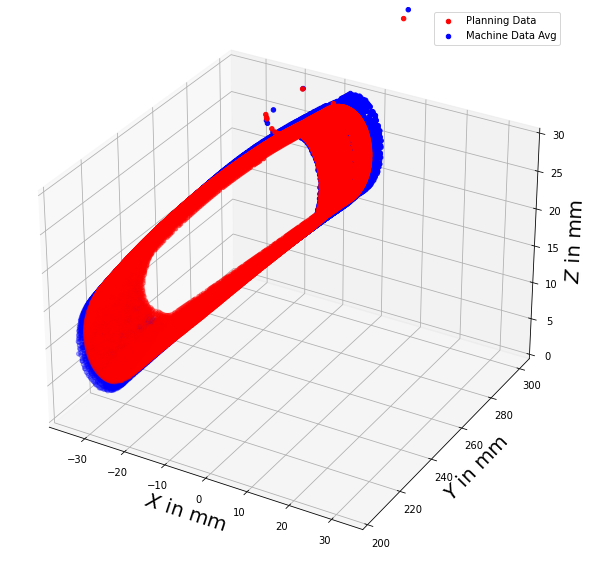

In [31]:
# Plot to show clusters
xdata, ydata, zdata = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.set_zlim3d([0,30])
ax.set_xlabel('$X$ in mm', fontsize=20)
ax.set_ylabel('$Y$ in mm', fontsize=20)
ax.set_zlabel('$Z$ in mm', fontsize=20)

for i in np.arange(len(pltlst)):
    xdata[i] = tool_tip_X[pltlst[i]]
    ydata[i] = tool_tip_Y[pltlst[i]]
    zdata[i] = tool_tip_Z[pltlst[i]]

ax.scatter3D(xdata, ydata, zdata, color = 'red',label = 'Planning Data')
ax.legend()

xdata2, ydata2, zdata2 = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

for i in np.arange(len(pltlst)):
    xdata2[i] = np.average(X[tuple([lst3[pltlst[i]]])])
    ydata2[i] = np.average(Y[tuple([lst3[pltlst[i]]])])
    zdata2[i] = np.average(Z[tuple([lst3[pltlst[i]]])])

ax.scatter3D(xdata2, ydata2, zdata2, color = 'blue',label = 'Machine Data Avg')
ax.legend()

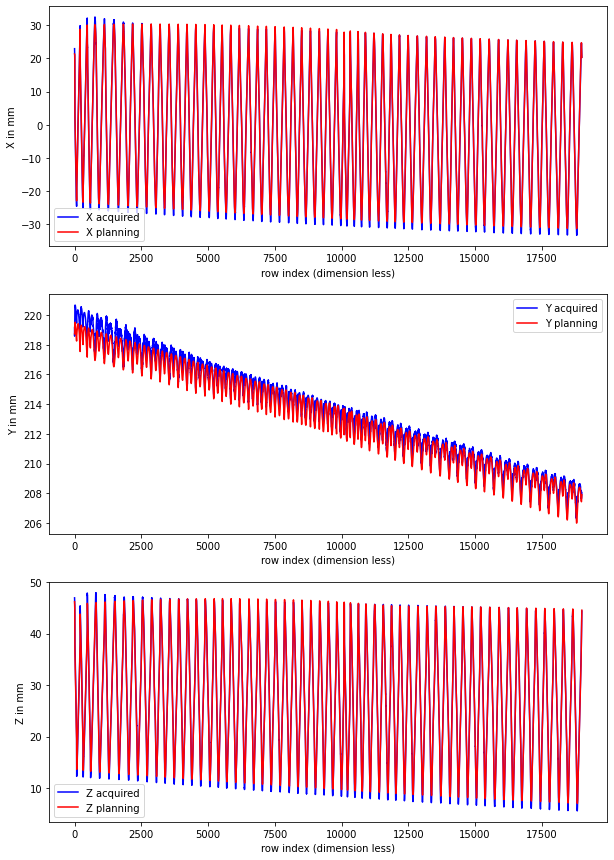

In [32]:
#subplotter(0,xdata.shape[0],xdata2,ydata2,zdata2,xdata,ydata,zdata)
subplotter(0,19000,xdata2,ydata2,zdata2,xdata,ydata,zdata)

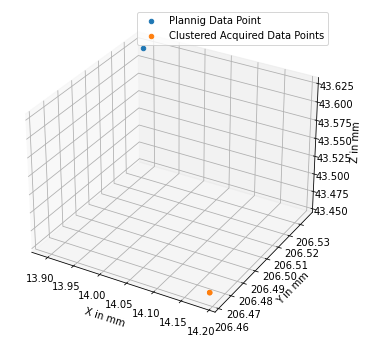

In [33]:
num = -10
xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)

plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]],label='Plannig Data Point')

for i in np.arange(len(lst3[pltlst[num]])):
    xdata[i] = X[lst3[pltlst[num]]][i]
    ydata[i] = Y[lst3[pltlst[num]]][i]
    zdata[i] = Z[lst3[pltlst[num]]][i]
    
ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
ax.set_xlabel('X in mm', fontsize=10)
ax.set_ylabel('Y in mm', fontsize=10)
ax.set_zlabel('Z in mm', fontsize=10)
plt.legend()

Input two numbers between 0 and 21705 with small difference for plots exaple 10000 then 10010
0


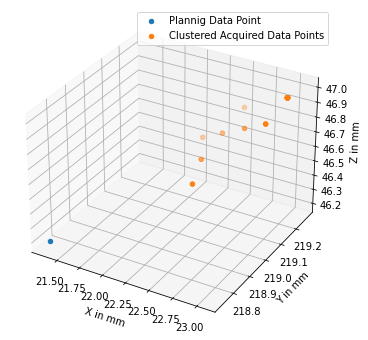

In [34]:
#for num in np.arange(len(pltlst)):
print('Input two numbers between 0 and {} with small difference for plots exaple 10000 then 10010'.format(len(pltlst)))
#lim1 = input()
#lim2 = input()

lim1 = 0
lim2 = 1

for num in np.arange(len(pltlst[int(lim1):int(lim2)])):
    xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)
    
    fig = plt.figure(figsize=(6,6))
    print(num)
    ax = plt.axes(projection='3d')

    ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]], label='Plannig Data Point')

    for i in np.arange(len(lst3[pltlst[num]])):
        xdata[i] = X[lst3[pltlst[num]]][i]
        ydata[i] = Y[lst3[pltlst[num]]][i]
        zdata[i] = Z[lst3[pltlst[num]]][i]
    
    ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
    ax.set_xlabel('X in mm', fontsize=10)
    ax.set_ylabel('Y in mm', fontsize=10)
    ax.set_zlabel('Z in mm', fontsize=10)
    plt.legend()
    plt.pause(0.1)
   

In [35]:
# for the clusterd points the acquired points are averaged
lst4 = []
for i in np.arange(len(lst3)):
    lst4.append(df_m.iloc[list(lst3[i])].mean(axis=0))
    
mean_m = pd.concat(lst4,axis=1).T
mean_m.iloc[-100:-1]

<ipython-input-35-3ecf7367c8c3>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  lst4.append(df_m.iloc[list(lst3[i])].mean(axis=0))


time   MachineX   MachineY    MachineZ  MachineA   MachineC  \
35861  325.737503  -104.2302   -77.5062   -169.2374  -75.6809   335.4168   
35862    321.4025  -104.2857   -77.7523   -169.1062  -75.7318   335.4003   
35863    323.5825 -103.95855  -77.81455   -168.9259  -75.6943   335.4725   
35864         NaN        NaN        NaN         NaN       NaN        NaN   
35865  323.588753 -103.66245   -78.0076   -168.6805 -75.68225  335.53855   
...           ...        ...        ...         ...       ...        ...   
35955  326.412502   -99.9075   -84.0233   -164.4077  -75.2364   339.9877   
35956         NaN        NaN        NaN         NaN       NaN        NaN   
35957  326.512189  -100.1086   -84.5691 -162.248383  -75.2364   339.9877   
35958  326.708127  -100.1086   -84.5691 -154.363188  -75.2364   339.9877   
35959  327.021366  -100.4726 -84.779418 -126.136609  -75.2364   339.9877   

      LoadSpindle    TransfX     TransfY    TransfZ   TransfI   TransfJ  \
35861    9.945455 -20.306062   206.14727  35.923971 -0.186758 -0.207175   
35862   10.022727 -20.223025  206.338128  36.035731 -0.223212 -0.239547   
35863    9.984091 -20.153428  206.246712  36.257833 -0.183098 -0.227038   
35864         NaN        NaN         NaN        NaN       NaN       NaN   
35865    9.990909  -20.05395  206.249578  36.543276 -0.161083 -0.229188   
...           ...        ...         ...        ...       ...       ...   
35955    9.954545  -31.91476  204.300117  44.841702  0.103264 -0.123676   
35956         NaN        NaN         NaN        NaN       NaN       NaN   
35957    9.957955 -31.436747    206.2002  45.919744  0.103264 -0.123676   
35958   10.068182  -28.82735  213.364674   47.92914  0.103264 -0.123676   
35959    9.927273 -19.846873  239.085499  55.325536  0.103264 -0.123676   

        TransfK executionDuration previousExecutionDuration  \
35861  0.960312          0.005411                  0.005575   
35862  0.944877           0.00521                  0.005061   
35863  0.956202          0.006352                  0.002899   
35864       NaN               NaN                       NaN   
35865  0.959671          0.002431                  0.006352   
...         ...               ...                       ...   
35955  0.986935          0.004668                  0.004412   
35956       NaN               NaN                       NaN   
35957  0.986935          0.004206                  0.003845   
35958  0.986935           0.00444                  0.004298   
35959  0.986935          0.004613                  0.005041   

      relativeTimetoPreviousCall program number           timeStamp  \
35861                                  0.007159   63750627074.85878   
35862                                  0.007336  63750627070.523773   
35863                                  0.006561  63750627072.703781   
35864                                       NaN                 NaN   
35865                                  0.007916   63750627072.71003   
...                                         ...                 ...   
35955                                  0.006759  63750627075.533783   
35956                                       NaN                 NaN   
35957                                  0.007554  63750627075.633461   
35958                                  0.007167  63750627075.829407   
35959                                  0.008155  63750627076.142647   

      Tool Length Tool Radius G54-X G54-Y    G54-Z G54-A G54-C ProgNumber  \
35861    226.4591         6.0   0.0   0.0 -510.483  12.0   0.0     1030.0   
35862    226.4591         6.0   0.0   0.0 -510.483  12.0   0.0     1030.0   
35863    226.4591         6.0   0.0   0.0 -510.483  12.0   0.0     1030.0   
35864         NaN         NaN   NaN   NaN      NaN   NaN   NaN        NaN   
35865    226.4591         6.0   0.0   0.0 -510.483  12.0   0.0     1030.0   
...           ...         ...   ...   ...      ...   ...   ...        ...   
35955    226.4591         6.0   0.0   0.0 -510.483

In [36]:
# distances are averaged
tcp_avg = [(lambda x: sum(x)/len(x))(item) if len(item)!=0 else np.nan for item in tcp_val]
len(tcp_avg)
#tcp_avg

35961

In [37]:
# Now the final dataframe with plannind data and the corresponding averaged acquired data is obtained 
final_df = pd.concat([df_p,mean_m, pd.DataFrame({'tcp_error':tcp_avg})], axis=1)
final_df = final_df.drop(['Level','Step'],axis=1)
final_df = final_df.dropna()
print(final_df.shape)
final_df.iloc[0:10]

(21705, 69)


Leading angle  Side tilt angle  Surface Contact point X  \
8        0.605350         0.136441                20.230158   
9        0.597177         0.185822                20.229862   
10       0.586565         0.232489                20.229565   
11       0.573636         0.276109                20.229269   
12       0.558518         0.316495                20.228972   
13       0.541344         0.353585                20.228676   
14       0.522242         0.387416                20.228379   
15       0.501340         0.418094                20.228083   
16       0.478759         0.445778                20.227786   
17       0.454614         0.470650                20.227489   

    Surface contact point Y  Surface contact point z  Surface Orietation X  \
8                220.072035                39.789210             -0.152592   
9                220.072062                39.789089             -0.152594   
10               220.072090                39.788968             -0.152597   
11               220.072117                39.788846             -0.152599   
12               220.072145                39.788725             -0.152602   
13               220.072173                39.788604             -0.152604   
14               220.072200                39.788483             -0.152606   
15               220.072228                39.788361             -0.152609   
16               220.072255                39.788240             -0.152611   
17               220.072283                39.788119             -0.152614   

    Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
8               0.816819              0.556347         21.342939   
9               0.816819              0.556346         21.351183   
10              0.816819              0.556346         21.347464   
11              0.816819              0.556345         21.331797   
12              0.816819              0.556345         21.304243   
13              0.816819              0.556344         21.264914   
14              0.816819              0.556344         21.213966   
15              0.816819              0.556343         21.151604   
16              0.816818              0.556343         21.078077   
17              0.816818              0.556343         20.993679   

    Tool Tip Point Y  Tool Tip Point Z  Tool Orientation X  \
8         218.730804         46.195240            0.001198   
9         218.735870         46.005775            0.001198   
10        218.741852         45.816193            0.001198   
11        218.748688         45.627251            0.001198   
12        218.756363         45.439705            0.001198   
13        218.764847         45.254307            0.001198   
14        218.774109         45.071800            0.001198   
15        218.784103         44.892910            0.001198   
16        218.794815         44.718349            0.001198   
17        218.806168         44.548824            0.001198   

    Tool Orientation Y  Tool Orientation Z  \
8             0.999999            0.000856   
9             0.999999            0.000856   
10            0.999999            0.000856   
11            0.999999            0.000856   
12            0.999999            0.000856   
13            0.999999            0.000856   
14            0.999999            0.000856   
15            0.999999            0.000856   
16            0.999999            0.000856   
17            0.999999            0.000856   

    Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
8                                            5.929007                          
9                                            5.929006                          
10                                           5.929005                          
11                                           5.929004                          
12                                           5.929003                          
13                              

In [38]:
final_df['block'] = block
final_df['angle'] = angle

In [39]:
print(final_df.shape)
final_df.iloc[0:10]

(21705, 71)


Leading angle  Side tilt angle  Surface Contact point X  \
8        0.605350         0.136441                20.230158   
9        0.597177         0.185822                20.229862   
10       0.586565         0.232489                20.229565   
11       0.573636         0.276109                20.229269   
12       0.558518         0.316495                20.228972   
13       0.541344         0.353585                20.228676   
14       0.522242         0.387416                20.228379   
15       0.501340         0.418094                20.228083   
16       0.478759         0.445778                20.227786   
17       0.454614         0.470650                20.227489   

    Surface contact point Y  Surface contact point z  Surface Orietation X  \
8                220.072035                39.789210             -0.152592   
9                220.072062                39.789089             -0.152594   
10               220.072090                39.788968             -0.152597   
11               220.072117                39.788846             -0.152599   
12               220.072145                39.788725             -0.152602   
13               220.072173                39.788604             -0.152604   
14               220.072200                39.788483             -0.152606   
15               220.072228                39.788361             -0.152609   
16               220.072255                39.788240             -0.152611   
17               220.072283                39.788119             -0.152614   

    Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
8               0.816819              0.556347         21.342939   
9               0.816819              0.556346         21.351183   
10              0.816819              0.556346         21.347464   
11              0.816819              0.556345         21.331797   
12              0.816819              0.556345         21.304243   
13              0.816819              0.556344         21.264914   
14              0.816819              0.556344         21.213966   
15              0.816819              0.556343         21.151604   
16              0.816818              0.556343         21.078077   
17              0.816818              0.556343         20.993679   

    Tool Tip Point Y  Tool Tip Point Z  Tool Orientation X  \
8         218.730804         46.195240            0.001198   
9         218.735870         46.005775            0.001198   
10        218.741852         45.816193            0.001198   
11        218.748688         45.627251            0.001198   
12        218.756363         45.439705            0.001198   
13        218.764847         45.254307            0.001198   
14        218.774109         45.071800            0.001198   
15        218.784103         44.892910            0.001198   
16        218.794815         44.718349            0.001198   
17        218.806168         44.548824            0.001198   

    Tool Orientation Y  Tool Orientation Z  \
8             0.999999            0.000856   
9             0.999999            0.000856   
10            0.999999            0.000856   
11            0.999999            0.000856   
12            0.999999            0.000856   
13            0.999999            0.000856   
14            0.999999            0.000856   
15            0.999999            0.000856   
16            0.999999            0.000856   
17            0.999999            0.000856   

    Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
8                                            5.929007                          
9                                            5.929006                          
10                                           5.929005                          
11                                           5.929004                          
12                                           5.929003                          
13                              

In [40]:
final_df = final_df.iloc[int(final_df.shape[0]*0.05):-int(final_df.shape[0]*0.05),:]

In [41]:
print(final_df.shape)
final_df.iloc[0:10]

(19535, 71)


Leading angle  Side tilt angle  Surface Contact point X  \
2582      -0.076452         0.893875                23.126696   
2583      -0.077689         0.894839                23.408515   
2584      -0.079327         0.895797                23.679973   
2585      -0.080504         0.896745                23.962073   
2587      -0.084064         0.898844                24.513465   
2588      -0.084897         0.899846                24.795397   
2589      -0.086334         0.900812                25.048698   
2590      -0.090845         0.901663                25.219482   
2591      -0.098971         0.902955                25.255442   
2592      -0.099455         0.904383                25.292645   

      Surface contact point Y  Surface contact point z  Surface Orietation X  \
2582               219.786425                39.953465              0.439055   
2583               219.756759                40.110489              0.439275   
2584               219.727330                40.261860              0.441178   
2585               219.696680                40.419187              0.441316   
2587               219.635954                40.726824              0.443716   
2588               219.604179                40.884229              0.443850   
2589               219.575631                41.025650              0.443985   
2590               219.556391                41.121113              0.446735   
2591               219.552339                41.141793              0.462635   
2592               219.548092                41.163992              0.477464   

      Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
2582              0.591329             -0.676433         25.352325   
2583              0.590782             -0.676767         25.634026   
2584              0.590139             -0.676091         25.915535   
2585              0.589639             -0.676436         26.197151   
2587              0.588361             -0.675979         26.760536   
2588              0.587869             -0.676318         27.042166   
2589              0.587375             -0.676659         27.295338   
2590              0.586679             -0.675452         27.481909   
2591              0.584602             -0.666491         27.612776   
2592              0.582656             -0.657678         27.738474   

      Tool Tip Point Y  Tool Tip Point Z  Tool Orientation X  \
2582        217.349487         35.945217            0.068227   
2583        217.316620         36.097198            0.068467   
2584        217.283401         36.249489            0.068695   
2585        217.249817         36.401524            0.068913   
2587        217.181534         36.705158            0.069316   
2588        217.146881         36.857010            0.069501   
2589        217.115402         36.993153            0.069656   
2590        217.092026         37.093178            0.069776   
2591        217.075531         37.165581            0.069861   
2592        217.059601         37.238667            0.069941   

      Tool Orientation Y  Tool Orientation Z  \
2582            0.997633           -0.008562   
2583            0.997621           -0.008055   
2584            0.997609           -0.007532   
2585            0.997598           -0.006995   
2587            0.997577           -0.005871   
2588            0.997568           -0.005286   
2589            0.997560           -0.004745   
2590            0.997553           -0.004298   
2591            0.997549           -0.003955   
2592            0.997545           -0.003616   

      Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
2582                                           6.078517                          
2583                                           6.078628                          
2584                                           6.078131                          
2585                                           6.079897                     

### Using Combined dataset Peaks Elimination:
Inspite of the average, there are some high impuse peaks observed in the data (Run the visualiation.ipnby), these must be removed to obtain a flawless, reliable dataset. Using machine data from newly created combined dataset same forward transformation is performed as discribled above. by observing the data, it can be seen that the using just one of the components (in this case Y) all the outlers can be eliminated. Two types of spikes are typicalled observed (check visualizaion by runnung  vizualization.ipnyb) one in positive direction and othes in negetive direction, so for robostness both are considered. At the same time, it is not wise to remove the original expected trajectory of the tool path in begining and the end, so especially for the positive direction they are intentionally not removed. if each peak on a plateu has to be removed its very expensive, so if two neighbous are consicutively classifies as peaks (given by count), it is assumed as plateu and 100 datapoint sare removed. This is a reasonable compromise in accuracy for significant speedup

<img src="images/peak_eli.png">

### Visulaization of outliers peaks

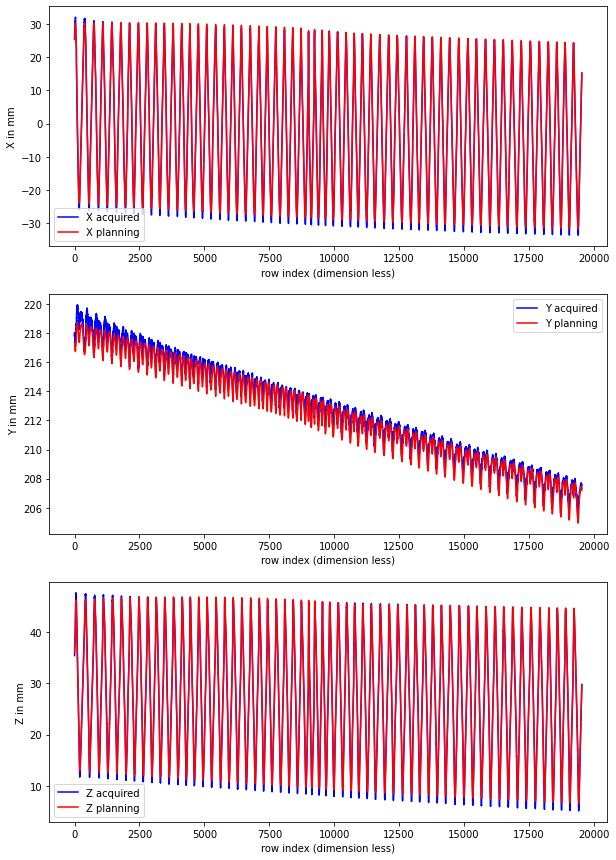

In [42]:
x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
y_final = final_df['MachineY'].copy(deep=True)
z_final = final_df['MachineZ'].copy(deep=True)
a_final = final_df['MachineA'].copy(deep=True)
c_final = final_df['MachineC'].copy(deep=True)

size1_final = x_final.shape[0]

# converting pandas series to numpy array
x_final = x_final.to_numpy()
y_final = y_final.to_numpy()
z_final = z_final.to_numpy()
a_final = a_final.to_numpy(dtype =  np.float64)
a_final = np.deg2rad(a_final)
c_final = c_final.to_numpy(dtype =  np.float64)
c_final = np.deg2rad(c_final)

tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
X_inv_final = tool_tip_X_final
Y_inv_final = tool_tip_Y_final
Z_inv_final = tool_tip_Z_final
    
#compensation_values
compensation_values = compensation_values_df.to_numpy()

# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
size3_final = x_final.shape[0]
conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

# prininting the compensation error values
df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
df_obj3_final.head(5)  

x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated_final = y_final + deltaY1_final*10**-3
z_compensated_final = z_final + deltaZ1_final*10**-3

conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

obj_final = transformation.Transformation(size1_final,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

X_final = tool_position_workpiece_CS_final[0,0,:]
Y_final = tool_position_workpiece_CS_final[1,0,:]
Z_final = tool_position_workpiece_CS_final[2,0,:]

I_final = tool_orientation_workpiece_CS_final[0,0,:]
J_final = tool_orientation_workpiece_CS_final[1,0,:]
K_final = tool_orientation_workpiece_CS_final[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

x_out_final = machine_points_xyz_final[0,0,:]
y_out_final = machine_points_xyz_final[1,0,:]
z_out_final = machine_points_xyz_final[2,0,:]

a_out_final = machine_direction_ac_final[0,0,:]
c_out_final = machine_direction_ac_final[1,0,:]

conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset

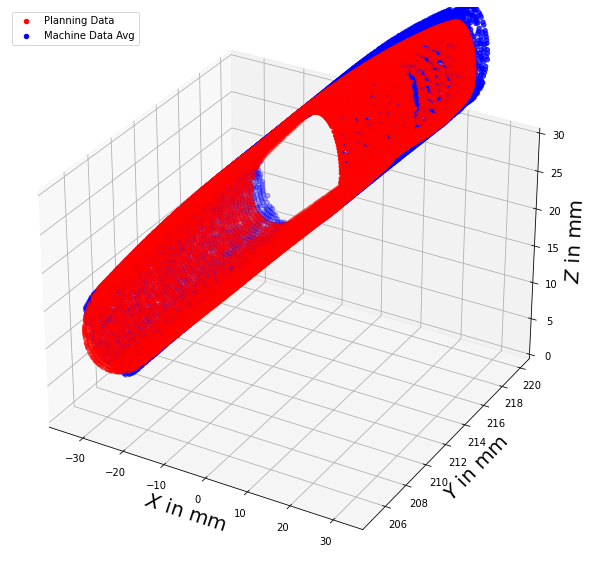

In [43]:
plt.figure(figsize=(10,15))
ax1 = plt.axes(projection='3d')
ax1.set_zlim3d([0,30])

ax1.set_xlabel('$X$ in mm', fontsize=20)
ax1.set_ylabel('$Y$ in mm', fontsize=20)
ax1.set_zlabel('$Z$ in mm', fontsize=20)

ax1.scatter3D(X_inv_final, Y_inv_final, Z_inv_final, color = 'red',label = 'Planning Data')
ax1.legend()

ax1.scatter3D(X_final, Y_final, Z_final, color = 'blue',label = 'Machine Data Avg')
ax1.legend()

In [44]:
def remove_peaks(final_df, compensation_values_df):
    x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
    y_final = final_df['MachineY'].copy(deep=True)
    z_final = final_df['MachineZ'].copy(deep=True)
    a_final = final_df['MachineA'].copy(deep=True)
    c_final = final_df['MachineC'].copy(deep=True)

    size1_final = x_final.shape[0]

    # converting pandas series to numpy array
    x_final = x_final.to_numpy()
    y_final = y_final.to_numpy()
    z_final = z_final.to_numpy()
    a_final = a_final.to_numpy(dtype = np.float64)
    a_final = np.deg2rad(a_final)
    c_final = c_final.to_numpy(dtype = np.float64)
    c_final = np.deg2rad(c_final)

    tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
    tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
    tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
    X_inv_final = tool_tip_X_final
    Y_inv_final = tool_tip_Y_final
    Z_inv_final = tool_tip_Z_final
    
    #compensation_values
    compensation_values = compensation_values_df.to_numpy()

    # Within each cube we have ranges defined in x,y,z for the machine position

    x_range = np.arange(-200,201,100)
    y_range = np.arange(-300,301,150)
    z_range = np.arange(-500,1,50)

    obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

    # Caclculation of compensation error values based on machine positions obtained through inverse transformation
    deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
    size3_final = x_final.shape[0]
    conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

    # prininting the compensation error values
    df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
    df_obj3_final.head(5)  

    x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
    y_compensated_final = y_final + deltaY1_final*10**-3
    z_compensated_final = z_final + deltaZ1_final*10**-3

    conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
    df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

    obj_final = transformation.Transformation(size1_final,angle)
    # Forward Transformation fuction:
    # Input : Machine points in machine coordinate system
    # Output: returns too tip points and orientation in workpiece coordinate system
    tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

    X_final = tool_position_workpiece_CS_final[0,0,:]
    Y_final = tool_position_workpiece_CS_final[1,0,:]
    Z_final = tool_position_workpiece_CS_final[2,0,:]

    I_final = tool_orientation_workpiece_CS_final[0,0,:]
    J_final = tool_orientation_workpiece_CS_final[1,0,:]
    K_final = tool_orientation_workpiece_CS_final[2,0,:]

    # Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
    machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

    x_out_final = machine_points_xyz_final[0,0,:]
    y_out_final = machine_points_xyz_final[1,0,:]
    z_out_final = machine_points_xyz_final[2,0,:]

    a_out_final = machine_direction_ac_final[0,0,:]
    c_out_final = machine_direction_ac_final[1,0,:]

    conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
    df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

    conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
    dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
    #subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset
    
    return Y_final, final_df

In [45]:
# Peak removal: by observing the data,
# it can be seen that the using just one of the components (in this case Y) all the outlers can be eliminated. 
count = 0
col = final_df.columns
while True:
    Y_final, final_df = remove_peaks(final_df,compensation_values_df)
    # Two types of spikes are typicalled observed (check visualizaion by runnung  vizualization.ipnyb) 
    # one in positive direction and othes in negetive direction, so for robostness both are considered. 
    # At the same time, it is not wise to remove the original expected trajectory of the tool path in begining and the end,
    # so especially for the positive direction they are intentionally not removed 
    print(-(np.mean(Y_final)-7*np.std(Y_final)), np.mean(Y_final), np.std(Y_final),(np.mean(Y_final)+7*np.std(Y_final)))
    peaks1, _ = find_peaks(-Y_final, height=(-(np.mean(Y_final)-7*np.std(Y_final)),None))
    #peaks2,_ = find_peaks(Y_final[0:-1000], height=(240,None))
    peaks2,_ = find_peaks(Y_final, height=((np.mean(Y_final)+7*np.std(Y_final)),None))
    peaks = list(peaks1) + list(peaks2)
    print(peaks)
    
    if(len(peaks)==0):
        break
        
    # if each peak on a plateu has to be removed its very expensive, so if two neighbous are consicutively classifies as peaks 
    # (given by count), it is assumed as plateu and 100 datapoints are removed.
    # This is a reasonable compromise in accuracy for significant speedup
        
    #elif(len(peaks)==1 and abs(Y_final[peaks[0]] - Y_final[peaks[0]+20] )<=0.3):
    elif(len(peaks)==1 and count>2 and peaks[-1]+100<final_df.shape[0]):
        arr = final_df.to_numpy()
        arr = np.delete(arr, np.arange(peaks[0],peaks[0]+100), 0)
        final_df = pd.DataFrame(arr,columns=col)
        count = 0
        
    elif(len(peaks)==1 and count>2 and (final_df.shape[0]-100<peaks[-1]<final_df.shape[0])):
        arr = final_df.to_numpy()
        arr = np.delete(arr, np.arange(peaks[0],peaks[0]+(final_df.shape[0]-peaks[-1])), 0)
        final_df = pd.DataFrame(arr,columns=col)
        count = 0
        
    else:
        arr = final_df.to_numpy()
        arr = np.delete(arr,peaks, 0)
        final_df = pd.DataFrame(arr,columns=col)
        count = count+1
        

-188.70205450861917 212.77357303078628 3.438788360309588 236.8450915529534
[]


In [46]:
final_df.shape

(19535, 71)

### Visulaiztion of effect of removing peaks

19535


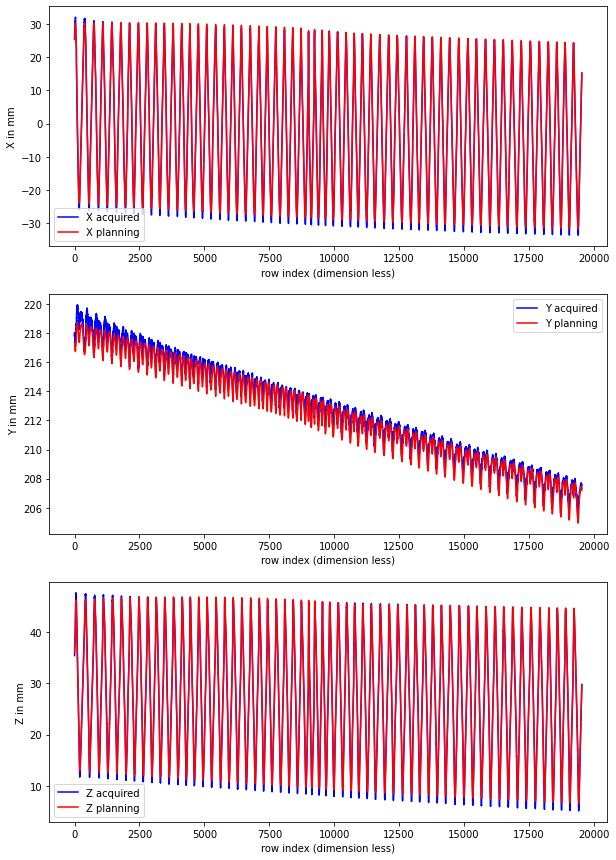

In [47]:
x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
y_final = final_df['MachineY'].copy(deep=True)
z_final = final_df['MachineZ'].copy(deep=True)
a_final = final_df['MachineA'].copy(deep=True)
c_final = final_df['MachineC'].copy(deep=True)

size1_final = x_final.shape[0]
print(size1_final)

# converting pandas series to numpy array
x_final = x_final.to_numpy()
y_final = y_final.to_numpy()
z_final = z_final.to_numpy()
a_final = a_final.to_numpy(dtype =  np.float64)
a_final = np.deg2rad(a_final)
c_final = c_final.to_numpy(dtype =  np.float64)
c_final = np.deg2rad(c_final)

tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
X_inv_final = tool_tip_X_final
Y_inv_final = tool_tip_Y_final
Z_inv_final = tool_tip_Z_final
    
#compensation_values
compensation_values = compensation_values_df.to_numpy()

# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
size3_final = x_final.shape[0]
conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

# prininting the compensation error values
df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
df_obj3_final.head(5)  

x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated_final = y_final + deltaY1_final*10**-3
z_compensated_final = z_final + deltaZ1_final*10**-3

conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

obj_final = transformation.Transformation(size1_final,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

X_final = tool_position_workpiece_CS_final[0,0,:]
Y_final = tool_position_workpiece_CS_final[1,0,:]

Z_final = tool_position_workpiece_CS_final[2,0,:]

I_final = tool_orientation_workpiece_CS_final[0,0,:]
J_final = tool_orientation_workpiece_CS_final[1,0,:]
K_final = tool_orientation_workpiece_CS_final[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

x_out_final = machine_points_xyz_final[0,0,:]
y_out_final = machine_points_xyz_final[1,0,:]
z_out_final = machine_points_xyz_final[2,0,:]

a_out_final = machine_direction_ac_final[0,0,:]
c_out_final = machine_direction_ac_final[1,0,:]

conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset

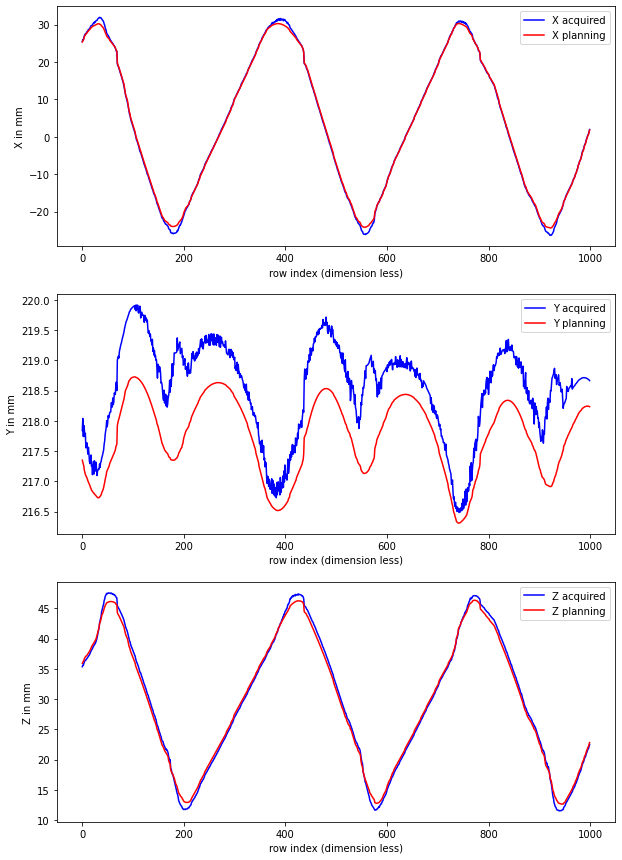

In [48]:
subplotter(0,1000,X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)

In [51]:
def shift(final_df, compensation_values_df):
    x_final = final_df['MachineX']                 # using machine data from newly created combined dataset
    y_final = final_df['MachineY']
    z_final = final_df['MachineZ']
    a_final = final_df['MachineA']
    c_final = final_df['MachineC']

    size1_final = x_final.shape[0]

    # converting pandas series to numpy array
    x_final = x_final.to_numpy()
    y_final = y_final.to_numpy()
    z_final = z_final.to_numpy()
    a_final = a_final.to_numpy(dtype =  np.float64)
    a_final = np.deg2rad(a_final)
    c_final = c_final.to_numpy(dtype =  np.float64)
    c_final = np.deg2rad(c_final)

    tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
    tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
    tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()

    X_inv_final = tool_tip_X_final
    Y_inv_final = tool_tip_Y_final
    Z_inv_final = tool_tip_Z_final

    #compensation_values
    compensation_values = compensation_values_df.to_numpy()

    # Within each cube we have ranges defined in x,y,z for the machine position

    x_range = np.arange(-200,201,100)
    y_range = np.arange(-300,301,150)
    z_range = np.arange(-500,1,50)

    obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

    # Caclculation of compensation error values based on machine positions obtained through inverse transformation
    deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  

    x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
    y_compensated_final = y_final + deltaY1_final*10**-3
    z_compensated_final = z_final + deltaZ1_final*10**-3

    obj_final = transformation.Transformation(size1_final,angle)
    # Forward Transformation fuction:
    # Input : Machine points in machine coordinate system
    # Output: returns too tip points and orientation in workpiece coordinate system
    tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

    X_final = tool_position_workpiece_CS_final[0,0,:]
    Y_final = tool_position_workpiece_CS_final[1,0,:]
    Z_final = tool_position_workpiece_CS_final[2,0,:]

    I_final = tool_orientation_workpiece_CS_final[0,0,:]
    J_final = tool_orientation_workpiece_CS_final[1,0,:]
    K_final = tool_orientation_workpiece_CS_final[2,0,:]

    #Shifting the data 
    div = 20
    length = Y_final.shape[0]
    chunck_len = int(length/div)
    
    for i in np.arange(0,div):
        if(i != div-1):
            diff = Y_final[i*chunck_len:(i+1)*chunck_len] - Y_inv_final[i*chunck_len:(i+1)*chunck_len]
            Y_final[i*chunck_len:(i+1)*chunck_len] = Y_final[i*chunck_len:(i+1)*chunck_len] - np.mean(diff)

        else:
            diff = Y_final[i*chunck_len:length] - Y_inv_final[i*chunck_len:length]
            Y_final[i*chunck_len:length] = Y_final[i*chunck_len:length] - np.mean(diff)

        
    return X_final,Y_final,Z_final



In [52]:
X_mc, Y_mc, Z_mc = shift(final_df,compensation_values_df)

In [53]:
final_df['Tool Tip Point Machine X'] = X_mc
final_df['Tool Tip Point Machine Y'] = Y_mc
final_df['Tool Tip Point Machine Z'] = Z_mc

In [57]:
print(final_df.shape)
final_df.iloc[0:10]

(19535, 74)


Leading angle  Side tilt angle  Surface Contact point X  \
2582      -0.076452         0.893875                23.126696   
2583      -0.077689         0.894839                23.408515   
2584      -0.079327         0.895797                23.679973   
2585      -0.080504         0.896745                23.962073   
2587      -0.084064         0.898844                24.513465   
2588      -0.084897         0.899846                24.795397   
2589      -0.086334         0.900812                25.048698   
2590      -0.090845         0.901663                25.219482   
2591      -0.098971         0.902955                25.255442   
2592      -0.099455         0.904383                25.292645   

      Surface contact point Y  Surface contact point z  Surface Orietation X  \
2582               219.786425                39.953465              0.439055   
2583               219.756759                40.110489              0.439275   
2584               219.727330                40.261860              0.441178   
2585               219.696680                40.419187              0.441316   
2587               219.635954                40.726824              0.443716   
2588               219.604179                40.884229              0.443850   
2589               219.575631                41.025650              0.443985   
2590               219.556391                41.121113              0.446735   
2591               219.552339                41.141793              0.462635   
2592               219.548092                41.163992              0.477464   

      Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
2582              0.591329             -0.676433         25.352325   
2583              0.590782             -0.676767         25.634026   
2584              0.590139             -0.676091         25.915535   
2585              0.589639             -0.676436         26.197151   
2587              0.588361             -0.675979         26.760536   
2588              0.587869             -0.676318         27.042166   
2589              0.587375             -0.676659         27.295338   
2590              0.586679             -0.675452         27.481909   
2591              0.584602             -0.666491         27.612776   
2592              0.582656             -0.657678         27.738474   

      Tool Tip Point Y  Tool Tip Point Z  Tool Orientation X  \
2582        217.349487         35.945217            0.068227   
2583        217.316620         36.097198            0.068467   
2584        217.283401         36.249489            0.068695   
2585        217.249817         36.401524            0.068913   
2587        217.181534         36.705158            0.069316   
2588        217.146881         36.857010            0.069501   
2589        217.115402         36.993153            0.069656   
2590        217.092026         37.093178            0.069776   
2591        217.075531         37.165581            0.069861   
2592        217.059601         37.238667            0.069941   

      Tool Orientation Y  Tool Orientation Z  \
2582            0.997633           -0.008562   
2583            0.997621           -0.008055   
2584            0.997609           -0.007532   
2585            0.997598           -0.006995   
2587            0.997577           -0.005871   
2588            0.997568           -0.005286   
2589            0.997560           -0.004745   
2590            0.997553           -0.004298   
2591            0.997549           -0.003955   
2592            0.997545           -0.003616   

      Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
2582                                           6.078517                          
2583                                           6.078628                          
2584                                           6.078131                          
2585                                           6.079897                     

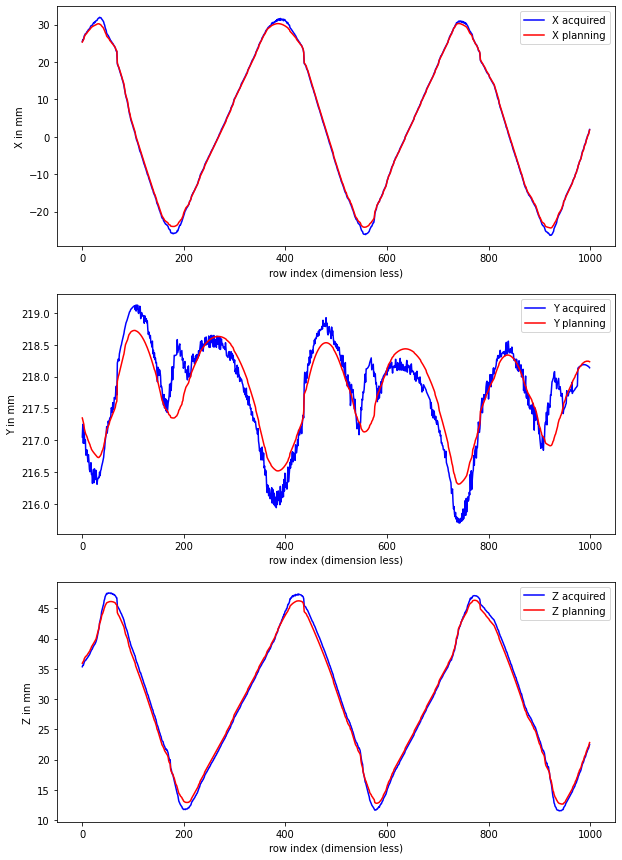

In [72]:
subplotter(0,1000,final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['Tool Tip Point X'].to_numpy(),final_df['Tool Tip Point Y'].to_numpy(),final_df['Tool Tip Point Z'].to_numpy())

0.5398086938507887


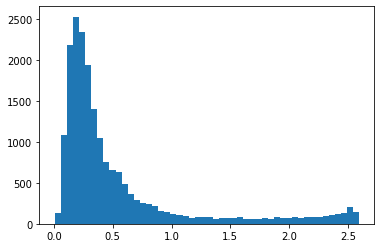

In [73]:
#tool point deviation

tool_point_deviation = np.sqrt(((final_df['Tool Tip Point Machine X'] - final_df['Tool Tip Point X'])**2 + (final_df['Tool Tip Point Machine Y'] - final_df['Tool Tip Point Y'])**2 + (final_df['Tool Tip Point Machine Z'] - final_df['Tool Tip Point Z'])**2).to_numpy(dtype=np.float64))
print(np.mean(tool_point_deviation))
plt.hist(tool_point_deviation, bins=50)
plt.show()

In [61]:
final_df['Tool Point Deviation'] = tool_point_deviation

In [62]:
final_df.iloc[10000:10020]

Leading angle  Side tilt angle  Surface Contact point X  \
18341       0.269050         1.335218               -21.441326   
18342       0.294679         1.360403               -21.287197   
18343       0.327125         1.385782               -21.129674   
18344       0.368200         1.410840               -20.965251   
18346       0.487313         1.458732               -20.621398   
18348       0.542946         1.472471               -20.072746   
18349       0.546510         1.473282               -19.765274   
18350       0.549484         1.474004               -19.461602   
18351       0.551082         1.474222               -19.153343   
18353       0.554936         1.474747               -18.539313   
18355       0.563598         1.476155               -17.926725   
18357       0.570407         1.476952               -17.314898   
18358       0.571762         1.476768               -17.008579   
18359       0.575816         1.477093               -16.702559   
18361       0.582848         1.477266               -16.089390   
18362       0.585118         1.476914               -15.780609   
18367       0.601935         1.475600               -14.244097   
18369       0.614677         1.475896               -13.627408   
18372       0.624111         1.474101               -12.709832   
18373       0.629614         1.473766               -12.398482   

       Surface contact point Y  Surface contact point z  Surface Orietation X  \
18341               216.529669                15.542734              0.338152   
18342               216.706255                15.646386              0.366378   
18343               216.884808                15.752225              0.393430   
18344               217.062262                15.861283              0.418753   
18346               217.405768                16.086372              0.465157   
18348               217.549688                16.401315              0.475786   
18349               217.585908                16.572573              0.475561   
18350               217.621464                16.741587              0.475982   
18351               217.653975                16.912653              0.475652   
18353               217.719190                17.253069              0.475450   
18355               217.789214                17.592803              0.475534   
18357               217.855074                17.931198              0.475799   
18358               217.884296                18.100132              0.475881   
18359               217.916412                18.269042              0.476025   
18361               217.977267                18.606911              0.476155   
18362               218.004798                18.776694              0.475868   
18367               218.142217                19.620316              0.475810   
18369               218.200566                19.958545              0.475501   
18372               218.273156                20.460434              0.476331   
18373               218.298292                20.630613              0.475709   

       Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
18341              0.237305             -0.910681        -19.296221   
18342              0.212542             -0.905866        -18.979788   
18343              0.187313             -0.900070        -18.667397   
18344              0.162133             -0.893509        -18.358841   
18346              0.113283             -0.877950        -17.753283   
18348              0.097248             -0.874169        -17.159067   
18349              0.095075             -0.874530        -16.862574   
18350              0.092943             -0.874530        -16.566343   
18351              0.091247             -0.874888        -16.270369   
18353              0.087610             -0.875369        -15.679132   
18355              0.082888             -0.875783        -15.088892   
18357              0.078574             -0.876037        -14.49962

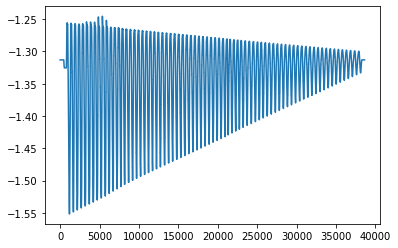

In [63]:
plt.plot(a)

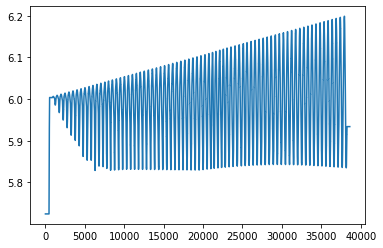

In [64]:
plt.plot(c)

Text(0.5, 1.0, 'TCP Error plot')

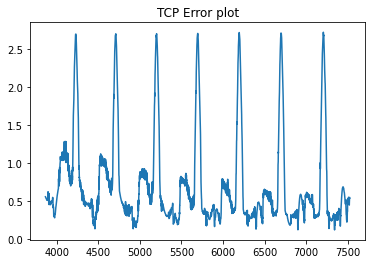

In [65]:
plt.plot((final_df['tcp_error']).iloc[1000:3500])
plt.title('TCP Error plot')

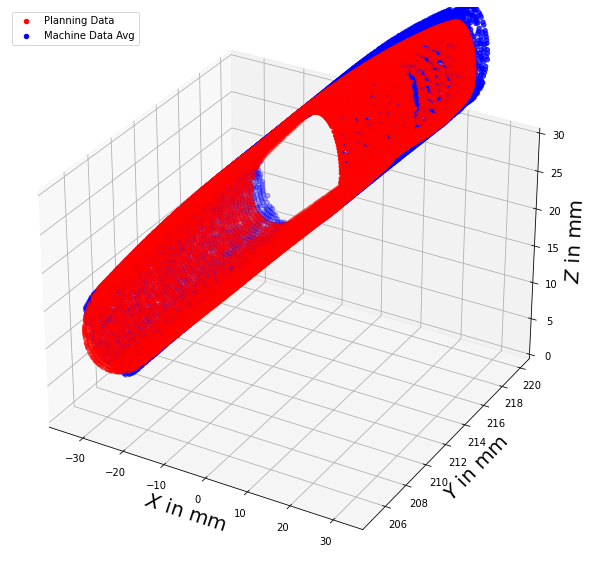

In [66]:
plt.figure(figsize=(10,15))
ax1 = plt.axes(projection='3d')
ax1.set_zlim3d([0,30])

ax1.set_xlabel('$X$ in mm', fontsize=20)
ax1.set_ylabel('$Y$ in mm', fontsize=20)
ax1.set_zlabel('$Z$ in mm', fontsize=20)

ax1.scatter3D(X_inv_final, Y_inv_final, Z_inv_final, color = 'red',label = 'Planning Data')
ax1.legend()

ax1.scatter3D(X_final, Y_final, Z_final, color = 'blue',label = 'Machine Data Avg')
ax1.legend()

In [67]:
mean = final_df['tcp_error'].mean()
mean

0.6231830838225165

In [68]:
median = final_df['tcp_error'].median()
median

0.33742755766827154

In [69]:
minimum = final_df['tcp_error'].min()
minimum

0.08408152629405287

In [70]:
maximum = final_df['tcp_error'].max()  
maximum

2.739395389569158

In [71]:
#final_df = final_df.iloc[0:21500]

In [ ]:
# saving data 
#final_df.to_excel(str(dir_final_save)+'finaldf_forward_with_compensation'+str(block)+'__'+str(angle)+'.xlsx') 